In [29]:
import os
import numpy as np
import pandas as pd
import re
from scipy.stats import norm
from scipy.optimize import minimize
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# DataCleaning

#### Set your working directory where stores all excel file. Also store the excel file name

In [30]:
working_directory = '/Users/bean/Desktop/bu/S3/MF772/Final project/'
# Data From Bloomberg
initial_corp_data_filename = 'Corp_Data.xlsx'
corp_data_filename = initial_corp_data_filename[:-5] + '_with_df.xlsx'
risk_free_data_filename = 'Monthly_Averaged_RiskFree.xlsx'
CDS_data_filename = 'CDS.xlsx'

It is problematic right now because it doesnt consider what if the cds ticker is missing.

In [31]:
def add_monthly_interest_rate(file_path, rates_path, output_path):
    rates_data = pd.read_excel(rates_path)
    rates_dict_col3 = pd.Series(rates_data.iloc[:, 3].values, index=rates_data.iloc[:, 0]).to_dict()
    rates_dict_col4 = pd.Series(rates_data.iloc[:, 4].values, index=rates_data.iloc[:, 0]).to_dict()
    rates_dict_col5 = pd.Series(rates_data.iloc[:, 5].values, index=rates_data.iloc[:, 0]).to_dict()
    rates_dict_col6 = pd.Series(rates_data.iloc[:, 6].values, index=rates_data.iloc[:, 0]).to_dict()
    rates_dict_col7 = pd.Series(rates_data.iloc[:, 7].values, index=rates_data.iloc[:, 0]).to_dict()
    rates_dict_col9 = pd.Series(rates_data.iloc[:, 9].values, index=rates_data.iloc[:, 0]).to_dict()
    with pd.ExcelWriter(output_path) as writer:
        xls = pd.ExcelFile(file_path)
        for sheet_name in xls.sheet_names:
            data = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            dates_column_index = 0
            data.iloc[8:, dates_column_index] = pd.to_datetime(
                data.iloc[8:, dates_column_index]
            ).dt.normalize().dt.to_period('M').dt.to_timestamp('M')
            rows_to_remove = []
            for i in range(8, len(data) - 1):
                current_date = data.iloc[i, dates_column_index]
                next_date = data.iloc[i + 1, dates_column_index]
                if current_date == next_date:
                    rows_to_remove.append(i)
            data.drop(index=rows_to_remove, inplace=True)
            data['rf_0.5Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col3).fillna(0)
            data['rf_1Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col4).fillna(0)
            data['rf_2Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col5).fillna(0)
            data['rf_3Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col6).fillna(0)
            data['rf_5Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col7).fillna(0)
            data['rf_10Y'] = data.iloc[8:, dates_column_index].map(rates_dict_col9).fillna(0)
            data = data.drop(index=7)
            while len(data.columns) < 19:
                data[len(data.columns)] = ''
            data.iloc[6, 17] = 'rf_0.5Y' 
            data.iloc[6, 18] = 'rf_1Y' 
            data.iloc[6, 19] = 'rf_2Y' 
            data.iloc[6, 20] = 'rf_3Y' 
            data.iloc[6, 21] = 'rf_5Y' 
            data.iloc[6, 22] = 'rf_10Y' 
            data.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

    return output_path
add_monthly_interest_rate(working_directory + initial_corp_data_filename,\
                          working_directory + risk_free_data_filename, \
                          working_directory + corp_data_filename)

'/Users/bean/Desktop/bu/S3/MF772/Final project/Corp_Data_with_df.xlsx'

In [32]:
def load_corp_xlsx(file_name = corp_data_filename, wd = working_directory):
    os.chdir(wd)
    xls = pd.ExcelFile(file_name)
    ticker_lst = xls.sheet_names
    return ticker_lst, xls

In [33]:
def load_cds_xlsx(ticker, ticker_cds,\
                  file_name = CDS_data_filename, \
                  maturities=['6M', '1Y', '2Y', '3Y', '5Y', '10Y']):
    '''
    The column that is being substituted is using the 10Y column name.
    '''
    xls = pd.ExcelFile(file_name)
    combined_df = pd.DataFrame()

    for mat in maturities:
        df_each_mat = xls.parse(mat, header=None)[3:]
        # Setting the first row as header
        df_each_mat.columns = df_each_mat.iloc[0]
        df_each_mat = df_each_mat[1:]  # Drop the header row
        df_each_mat = df_each_mat.reset_index(drop=True)
        df_each_mat = df_each_mat.rename(columns={'Name': 'Date'})  # Rename the 'Name' column to 'Date'
        df_each_mat['Date'] = pd.to_datetime(df_each_mat['Date']) 
        
        modified_ticker_cds = ticker_cds.replace("10Y", mat)

        # Find the matching column by exact name
        if modified_ticker_cds in df_each_mat.columns:
            # If the combined_df is empty, initialize it with the date column
            if combined_df.empty:
                combined_df['Date'] = df_each_mat['Date']
            
            # Merge the current maturity data with the combined_df
            combined_df = pd.merge(combined_df, df_each_mat[['Date', modified_ticker_cds]], on='Date', how='left')
            
            # Rename the merged column to include the ticker and the current maturity
            combined_df = combined_df.rename(columns={modified_ticker_cds: f'{ticker}_{mat}'})
        
    # Change the 6M CDS data to 0.5Y for convenience
    # Check if DataFrame has at least two columns
    if  combined_df.shape[1] < 2:
        raise ValueError("DataFrame needs to have at least two columns")

    # Rename the second column
    # Getting the original column name that is currently at index 1 (second column)
    second_column_name =  combined_df.columns[1]
    
    # Renaming the second column
    combined_df =  combined_df.rename(columns={second_column_name: ticker + '_0.5Y'})

    return combined_df

In [34]:
def create_corp_df():
    import os
    import numpy as np
    import pandas as pd
    '''
    Store all ticker information into a dictionary
    Store both corporate data and corresponding CDS data into the dictionary.
    The dictionary's key is the stock ticker, item is a list in order of 
    Bloomberg ticker name, Bloomberg ticker data, DataStream CDS ticker name, DataStream CDS data dict.
    '''
    # Load corp data
    ticker_lst, corp_xls = load_corp_xlsx()
    df_dict = {}
    # 以corp xlsx为基准，从cds xlsx里找到对应的数据，所以要确保corp xlsx每一个sheet都是对的。
    for ticker in ticker_lst:
        df = corp_xls.parse(ticker, header = None)
        if ticker in df_dict:
            break
            print('multiple ticker names in corp_data.xlsx')
        else:
            ticker_cds = df.iloc[3,1]
            ticker_blmbg = df.iloc[4,1]
            df_data = df[6:]
            df_data.columns = df_data.iloc[0]
            df_data = df_data[1:]
            df_data = df_data.reset_index(drop=True)
            df_cds = load_cds_xlsx(ticker, ticker_cds)
            df_dict[ticker] = [ticker_blmbg, df_data, ticker_cds, df_cds]
            
    
    
    return df_dict

#### When adding a new column, change the corp_columns list accordingly

In [35]:
def combine_corp_cds_df(ticker, full_dict):
    df_Corp = full_dict[ticker][1]
    df_CDS = full_dict[ticker][3]
    # Assuming df_Corp and df_CDS are your DataFrames
    # Convert date columns to datetime
    df_Corp['Dates'] = pd.to_datetime(df_Corp['Dates'])
    df_CDS = df_CDS.copy()  # Create a copy to avoid SettingWithCopyWarning
    df_CDS['Date'] = pd.to_datetime(df_CDS['Date'])
    df_Corp.sort_values(by='Dates', inplace=True)

    # Function to find the most recent non-NaN Corp data for each CDS date
    def find_recent_non_nan(cds_date, column):
        # Filter Corp data to find entries before the CDS date
        filtered_df = df_Corp[df_Corp['Dates'] < cds_date]

        # Get the most recent non-NaN value for the specified column
        recent_non_nan = filtered_df[column].dropna().tail(1).values
        return recent_non_nan[0] if len(recent_non_nan) > 0 else np.nan

    # Columns from df_Corp to be considered
    corp_columns = ['BS_ST_BORROW', 'BS_LT_BORROW', 'SHORT_AND_LONG_TERM_DEBT', 'CUR_MKT_CAP', 
                    'TOTAL_EQUITY', 'BS_TOT_ASSET', 'PX_LAST', 'BS_CUR_LIAB', 'NON_CUR_LIAB', 
                    'BS_SH_OUT', 'TOTAl_DEBT_PER_SHARE', 'HIST_CALL_IMP_VOL', \
                    'rf_0.5Y', 'rf_1Y', 'rf_2Y','rf_3Y','rf_5Y','rf_10Y']

    # Iterate through each column and apply the function
    for col in corp_columns:
        df_CDS[col] = df_CDS['Date'].apply(lambda x: find_recent_non_nan(x, col))

    return df_CDS

Construct the full dictionary stores all corp and cds data first

In [36]:
full_dict = create_corp_df()

In [37]:
full_dict['MMM']

['MMM US Equity',
 6                  Dates BS_ST_BORROW BS_LT_BORROW SHORT_AND_LONG_TERM_DEBT  \
 0    2008-01-31 00:00:00          NaN          NaN                      NaN   
 1    2008-02-29 00:00:00          NaN          NaN                      NaN   
 2    2008-03-31 00:00:00         2042         4140                     6182   
 3    2008-04-30 00:00:00          NaN          NaN                      NaN   
 4    2008-05-31 00:00:00          NaN          NaN                      NaN   
 ..                   ...          ...          ...                      ...   
 175  2022-08-31 00:00:00          NaN          NaN                      NaN   
 176  2022-09-30 00:00:00         2097        14419                    16516   
 177  2022-10-31 00:00:00          NaN          NaN                      NaN   
 178  2022-11-30 00:00:00          NaN          NaN                      NaN   
 179  2022-12-31 00:00:00         2199        14581                    16780   
 
 6   CUR_MKT_CAP TOT

In [38]:
def test_df_validity(df, column_name = 'BS_ST_BORROW', min_length = 13):
    """
    Check if there are at least `min_length` continuous non-NaN entries in the DataFrame
    for the specified column after the first non-NaN entry is detected.
    If true, return the DataFrame from the first non-NaN row.
    
    :param df: DataFrame to check
    :param column_name: Column name to check for continuous non-NaN entries
    :param min_length: Minimum length of continuous non-NaN entries required
    :return: DataFrame from the first non-NaN row if the condition is met, otherwise None
    """
    # Drop NaN values before the first non-NaN entry
    first_non_nan_index = df[column_name].first_valid_index()
    if first_non_nan_index is None:
        return None  # No non-NaN entries in the column

    trimmed_df = df.loc[first_non_nan_index:]

    # Check for continuous non-NaN entries
    continuous_count = 0
    for value in trimmed_df[column_name]:
        if pd.notna(value):
            continuous_count += 1
            if continuous_count >= min_length:
                return trimmed_df
        else:
            continuous_count = 0  # Reset count if NaN is encountered

    return None

In [39]:
def check_nans(df):
    """
    Check if NaN exists in the DataFrame. If it does, concatenate the rows with NaN
    and return the resulting DataFrame. Otherwise, return None.
    
    :param df: DataFrame to check and process
    :return: DataFrame with concatenated rows containing NaN if NaN exists, otherwise None
    """
    if df.isna().values.any():
        # Filter rows with NaN values
        nan_rows_df = df[df.isna().any(axis=1)]
        return nan_rows_df
    else:
        return None

In [40]:
def check_validity_and_nans(ticker, full_dict = full_dict):
    """
    Check if the DataFrame is valid (has at least 13 months of data) and if there are NaN values.
    
    :param ticker: Ticker symbol for the data
    :param full_dict: Dictionary containing data for various tickers
    :return: Tuple containing (trimmed DataFrame, DataFrame of NaNs, indication message)
    """
    print(ticker)
    raw_df = combine_corp_cds_df(ticker, full_dict)
    df = test_df_validity(raw_df)
    df = df.reset_index(drop = True)
    df = test_df_validity(df, column_name = df.columns[3])
    
    # Check if the DataFrame is long enough
    if df is None:
        message = f'{ticker} df is not valid in testing if it has long enough (13 months at least) data'
#         print(message)
        return None, None, message
    
    # Check for NaNs in the DataFrame
    nans_df = check_nans(df)
    if nans_df is not None:
        # Check if NaN indices are consecutive and at the end
        if (nans_df.index == range(nans_df.index[0], nans_df.index[-1] + 1)).all() and nans_df.index[-1] == df.index[-1]:
            # Trim the DataFrame by removing rows with NaNs at the end
            trimmed_df = df.iloc[:nans_df.index[0],]
            message = f'Trimmed {ticker} df to remove NaNs at the end'
        elif (nans_df.index == range(nans_df.index[0], nans_df.index[-1] + 1)).all():
            # Trim the DataFrame to the portion before NaNs
            trimmed_df = df.iloc[:nans_df.index[0]]
            print(trimmed_df)
            message = f'Trimmed {ticker} df up to first occurrence of NaNs'
        else:
            # NaNs are not consecutive, cannot process
            message = f'{ticker} df has non-consecutive NaNs, cannot process'
            print(message)
            return None, nans_df, message
        
#         print(message)
#         print('trimmed_df')
#         print(trimmed_df.tail())
        return trimmed_df, nans_df, message
    
    message = f'{ticker} df is perfect for further analysis'
#     print(message)
    return df, None, message


# Merton Model

In [41]:
def objective_function(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    # d1
    d1 = (np.log(value_of_assets / DPT) + ((volatility_of_assets ** 2) / 2 + rf) * time_horizon) / (volatility_of_assets * np.sqrt(time_horizon))
    d1_df = pd.DataFrame({'d1': d1})

    # d2
    d2 = d1 - volatility_of_assets * np.sqrt(time_horizon)
    d2_df = pd.DataFrame({'d2': d2})
    
    fair_values = value_of_assets * norm.cdf(d1) - DPT * np.exp(-rf * time_horizon) * norm.cdf(d2)
    # Expected distance to default
    EDF = norm.cdf(-1 * d2)
    
    # Calculate the sum of squared mispricing
    mispricing = market_cap - fair_values
    sum_of_squared = np.sum(mispricing ** 2)
    return sum_of_squared

def optimize_assets(initial_value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    # Define the optimization objective function
    def objective(value_of_assets):
        return objective_function(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon)

    # Define bounds to keep the value of assets strictly positive
    lower_bound = 1e-6  # lower_bound of asset > 0 at least
    upper_bound = np.inf  # No upper limit
    bounds = [(lower_bound, upper_bound) for _ in initial_value_of_assets]

    # Perform optimization to find the asset values that minimize mispricing
    result = minimize(objective, initial_value_of_assets, method='SLSQP', bounds=bounds)
    optimized_value_of_assets = result.x

    # Calculate returns of optimized assets
    returns_of_assets = np.diff(optimized_value_of_assets) / optimized_value_of_assets[:-1]

    # Calculate the volatility of the returns of assets
    volatility_of_returns = np.std(returns_of_assets) * np.sqrt(12)

    return optimized_value_of_assets, returns_of_assets, volatility_of_returns


def Merton_iteration(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    if isinstance(value_of_assets, pd.DataFrame):
        value_of_assets = value_of_assets.iloc[:, 0]
    
    # If 'volatility_of_assets', 'market_cap', DPT' are DataFrames, convert them to Series
    if isinstance(volatility_of_assets, pd.DataFrame):
        volatility_of_assets = volatility_of_assets.iloc[:, 0]
    if isinstance(market_cap, pd.DataFrame):
        market_cap = market_cap.iloc[:, 0]
    if isinstance(DPT, pd.DataFrame):
        DPT = DPT.iloc[:, 0]
    optimized_assets, returns_of_assets, volatility_of_returns = \
    optimize_assets(value_of_assets, volatility_of_assets,\
                    market_cap, DPT, rf, time_horizon)
    return optimized_assets, returns_of_assets, volatility_of_returns


def Merton_model(df, time_horizon, ticker):
    
    PD_df = pd.DataFrame()
    # Implement the model now
    for i in range(12, len(df)):
        sub_df = df.iloc[i-12:i+1]
#         sub_df = sub_df.reset_index(drop=True)
#         print(sub_df)
        
        # DPT
        DPT_start = sub_df['SHORT_AND_LONG_TERM_DEBT'].iloc[0]
        DPT_end = sub_df['SHORT_AND_LONG_TERM_DEBT'].iloc[-1]
        DPT_drift = DPT_end/DPT_start - 1
        horizon = DPT_end * (1 + DPT_drift)**time_horizon
        #         print(horizon)

        #         print(DPT_start)
        #         print(DPT_end)
        
        # Modify here
        market_cap = sub_df['PX_LAST'] * sub_df['BS_SH_OUT']
        equity_returns = market_cap.pct_change().dropna()
        
        
        market_value_vol = np.std(equity_returns) * np.sqrt(12)
#         print(market_cap)
        
        # Model iteration implemnentation
        
        # construct fixed default point df.
        DPT_values = [DPT_start]
        for _ in range(1, 13):
            next_value = DPT_values[-1] * (1 + DPT_drift)**(1/12)
            DPT_values.append(next_value)
        DPT = pd.DataFrame({'DPT': DPT_values})

#         print(DPT)
        
        # get the risk free rate 
        rf = sub_df['rf_1Y'].iloc[-1]
        # rf = sub_df['rf_5Y'].iloc[-1]
        
        # Initialize the asset volatility as 13 identical market cap volatility,
        # the value of assets as market cap,
        initial_volatility = market_value_vol
        
        initial_value_of_assets = market_cap
        initial_volatility_of_assets = pd.DataFrame({'Initial Volatility': [initial_volatility] * 13})

        
        
        iteration = 1
        while True:
            iteration += 1
            
            optimized_assets, returns_of_assets, new_volatility = \
                Merton_iteration(initial_value_of_assets, initial_volatility_of_assets, market_cap, DPT, rf, time_horizon)
            # Check each iteration results
            # print(iteration)
            # iteration += 1
            # print(initial_volatility)
            # print(new_volatility)

            # Check if the change in volatility is less than 2 basis point
            if abs(new_volatility - initial_volatility) <= 0.0002:
                final_optimized_assets = optimized_assets
                final_optimized_volatility = new_volatility
                break

            # Update initial values for the next iteration
            initial_value_of_assets = optimized_assets
            initial_volatility_of_assets = pd.DataFrame({'Initial Volatility': [new_volatility] * 13})
            initial_volatility = new_volatility
#         print(final_optimized_volatility)
        d1 = (np.log(final_optimized_assets[-1] /DPT.iloc[-1]) + ((final_optimized_volatility ** 2) / 2 + rf) * time_horizon) / (final_optimized_volatility * np.sqrt(time_horizon))
        d2 = d1 - final_optimized_volatility * np.sqrt(time_horizon)
        EDF = float(d2[0])
        PD = norm.cdf(-1 * EDF)
        new_row = pd.DataFrame({'Date': [sub_df['Date'].iloc[-1]],\
                                f'{time_horizon}Y_EDF_Merton_{ticker}': [EDF],\
                                f'{time_horizon}Y_PD_Merton_{ticker}': [PD]})
        new_row.index = [sub_df.index[-1]]
        PD_df = pd.concat([PD_df, new_row])
    return PD_df

In [42]:
def Merton(ticker):
    df, df_nans, df_messages = check_validity_and_nans(ticker, full_dict)
    if df is None:
        print(df_messages)
        return None
    print(df_messages)
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
    # time_horizon_lst = [0.5]
    # extract CDS price info
    df_combined_CDS_and_PD_info = df.iloc[:, :7]
    
    # Extract rf infos
    df_last_six_columns = df.iloc[:, -6:]


    df_combined_CDS_and_PD_info = pd.concat([df_combined_CDS_and_PD_info, df_last_six_columns], axis=1)
    for time_horizon in time_horizon_lst:
        PD_df = Merton_model(df, time_horizon, ticker)
        df_combined_CDS_and_PD_info = pd.merge(df_combined_CDS_and_PD_info, PD_df, on='Date', how='inner')
    
    return df_combined_CDS_and_PD_info
Merton_df = Merton('MMM')
print(Merton_df)

MMM
MMM df is perfect for further analysis
          Date  MMM_0.5Y    MMM_1Y    MMM_2Y    MMM_3Y    MMM_5Y   MMM_10Y  \
0   2009-04-14  68.93999  70.82999  73.65999     78.39  83.10999  83.10999   
1   2009-05-14        45        45  50.01999  55.04999     65.12  58.95999   
2   2009-06-14  30.31999  30.15999     35.12     40.14  50.21999  46.01999   
3   2009-07-14        30        30     35.03  40.06999  50.15999  45.98999   
4   2009-08-14     18.64     21.45  23.03999  26.71999  32.20999  28.73999   
..         ...       ...       ...       ...       ...       ...       ...   
171 2023-07-14      8.95     11.07  27.53999     40.83  64.82001    104.09   
172 2023-08-14     11.99     14.32     29.78  42.92999  67.24001    107.64   
173 2023-09-14     10.16     12.46     28.39     41.38     68.42    113.86   
174 2023-10-14     23.28     28.06     44.77     62.19  90.32001    135.48   
175 2023-11-14      9.65     11.52     33.41     51.58     81.62    130.52   

      rf_0.5Y     rf

# KMV merton model

In [43]:
def objective_function(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    # d1
    d1 = (np.log(value_of_assets / DPT) + ((volatility_of_assets ** 2) / 2 + rf) * time_horizon) / (volatility_of_assets * np.sqrt(time_horizon))
    d1_df = pd.DataFrame({'d1': d1})

    # d2
    d2 = d1 - volatility_of_assets * np.sqrt(time_horizon)
    d2_df = pd.DataFrame({'d2': d2})
    
    fair_values = value_of_assets * norm.cdf(d1) - DPT * np.exp(-rf * time_horizon) * norm.cdf(d2)
    # Expected distance to default
    EDF = norm.cdf(-1 * d2)
    
    # Calculate the sum of squared mispricing
    mispricing = market_cap - fair_values
    sum_of_squared = np.sum(mispricing ** 2)
    return sum_of_squared

def optimize_assets(initial_value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    # Define the optimization objective function
    def objective(value_of_assets):
        return objective_function(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon)

    # Define bounds to keep the value of assets strictly positive
    lower_bound = 1e-6  # lower_bound of asset > 0 at least
    upper_bound = np.inf  # No upper limit
    bounds = [(lower_bound, upper_bound) for _ in initial_value_of_assets]

    # Perform optimization to find the asset values that minimize mispricing
    result = minimize(objective, initial_value_of_assets, method='SLSQP', bounds=bounds)
    optimized_value_of_assets = result.x

    # Calculate returns of optimized assets
    returns_of_assets = np.diff(optimized_value_of_assets) / optimized_value_of_assets[:-1]

    # Calculate the volatility of the returns of assets
    volatility_of_returns = np.std(returns_of_assets) * np.sqrt(12)

    return optimized_value_of_assets, returns_of_assets, volatility_of_returns


def KMV_iteration(value_of_assets, volatility_of_assets, market_cap, DPT, rf, time_horizon):
    if isinstance(value_of_assets, pd.DataFrame):
        value_of_assets = value_of_assets.iloc[:, 0]
    
    # If 'volatility_of_assets', 'market_cap', DPT' are DataFrames, convert them to Series
    if isinstance(volatility_of_assets, pd.DataFrame):
        volatility_of_assets = volatility_of_assets.iloc[:, 0]
    if isinstance(market_cap, pd.DataFrame):
        market_cap = market_cap.iloc[:, 0]
    if isinstance(DPT, pd.DataFrame):
        DPT = DPT.iloc[:, 0]
    optimized_assets, returns_of_assets, volatility_of_returns = \
    optimize_assets(value_of_assets, volatility_of_assets,\
                    market_cap, DPT, rf, time_horizon)
    return optimized_assets, returns_of_assets, volatility_of_returns


def KMV_model(df, time_horizon, ticker):
    
    PD_df = pd.DataFrame()
    # Implement the model now
    for i in range(12, len(df)):
        sub_df = df.iloc[i-12:i+1]
#         sub_df = sub_df.reset_index(drop=True)
#         print(sub_df)
        
        # DPT
        DPT_start = sub_df['BS_ST_BORROW'].iloc[0] + 0.5 * sub_df['BS_LT_BORROW'].iloc[0]
        DPT_end = sub_df['BS_ST_BORROW'].iloc[-1] + 0.5 * sub_df['BS_LT_BORROW'].iloc[-1]
        DPT_drift = DPT_end/DPT_start - 1
        horizon = DPT_end * (1 + DPT_drift)**time_horizon
        #         print(horizon)

        #         print(DPT_start)
        #         print(DPT_end)
        
        # Modify here
        market_cap = sub_df['CUR_MKT_CAP']
        equity_returns = sub_df['CUR_MKT_CAP'].pct_change().dropna()
        
        
        market_value_vol = np.std(equity_returns) * np.sqrt(12)
#         print(market_cap)
        
        # Model iteration implemnentation
        
        # construct fixed default point df.
        DPT_values = [DPT_start]
        for _ in range(1, 13):
            next_value = DPT_values[-1] * (1 + DPT_drift)**(1/12)
            DPT_values.append(next_value)
        DPT = pd.DataFrame({'DPT': DPT_values})

#         print(DPT)
        
        # get the risk free rate 
        rf = sub_df['rf_1Y'].iloc[-1]
        # rf = sub_df['rf_5Y'].iloc[-1]
        
        # Initialize the asset volatility as 13 identical market cap volatility,
        # the value of assets as market cap,
        initial_volatility = market_value_vol
        
        initial_value_of_assets = sub_df['CUR_MKT_CAP']
        initial_value_of_assets = market_cap
        initial_volatility_of_assets = pd.DataFrame({'Initial Volatility': [initial_volatility] * 13})

        
        
        iteration = 1
        while True:
            iteration += 1
            
            optimized_assets, returns_of_assets, new_volatility = \
                KMV_iteration(initial_value_of_assets, initial_volatility_of_assets, market_cap, DPT, rf, time_horizon)
            # Check each iteration results
            # print(iteration)
            # iteration += 1
            # print(initial_volatility)
            # print(new_volatility)

            # Check if the change in volatility is less than 2 basis point
            if abs(new_volatility - initial_volatility) <= 0.0002:
                final_optimized_assets = optimized_assets
                final_optimized_volatility = new_volatility
                break

            # Update initial values for the next iteration
            initial_value_of_assets = optimized_assets
            initial_volatility_of_assets = pd.DataFrame({'Initial Volatility': [new_volatility] * 13})
            initial_volatility = new_volatility
#         print(final_optimized_volatility)
        d1 = (np.log(final_optimized_assets[-1] /DPT.iloc[-1]) + ((final_optimized_volatility ** 2) / 2 + rf) * time_horizon) / (final_optimized_volatility * np.sqrt(time_horizon))
        d2 = d1 - final_optimized_volatility * np.sqrt(time_horizon)
        EDF = float(d2[0])
        PD = norm.cdf(-1 * EDF)
        new_row = pd.DataFrame({'Date': [sub_df['Date'].iloc[-1]],\
                                f'{time_horizon}Y_EDF_KMV_{ticker}': [EDF],\
                                f'{time_horizon}Y_PD_KMV_{ticker}': [PD]})
        new_row.index = [sub_df.index[-1]]
        PD_df = pd.concat([PD_df, new_row])
        #####################################################
#         if i >= 20:
#             break
    return PD_df
        

In [44]:
def KMV(ticker):
    df, df_nans, df_messages = check_validity_and_nans(ticker, full_dict)
    if df is None:
        print(df_messages)
        return None
    print(df_messages)
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
    # time_horizon_lst = [0.5]
    # extract CDS price info
    df_combined_CDS_and_PD_info = df.iloc[:, :7]
    
    # Extract rf infos
    df_last_six_columns = df.iloc[:, -6:]


    df_combined_CDS_and_PD_info = pd.concat([df_combined_CDS_and_PD_info, df_last_six_columns], axis=1)
    for time_horizon in time_horizon_lst:
        PD_df = KMV_model(df, time_horizon, ticker)
        df_combined_CDS_and_PD_info = pd.merge(df_combined_CDS_and_PD_info, PD_df, on='Date', how='inner')
        
    return df_combined_CDS_and_PD_info
KMV_df = KMV('MMM')
print(KMV_df)

MMM
MMM df is perfect for further analysis
          Date  MMM_0.5Y    MMM_1Y    MMM_2Y    MMM_3Y    MMM_5Y   MMM_10Y  \
0   2009-04-14  68.93999  70.82999  73.65999     78.39  83.10999  83.10999   
1   2009-05-14        45        45  50.01999  55.04999     65.12  58.95999   
2   2009-06-14  30.31999  30.15999     35.12     40.14  50.21999  46.01999   
3   2009-07-14        30        30     35.03  40.06999  50.15999  45.98999   
4   2009-08-14     18.64     21.45  23.03999  26.71999  32.20999  28.73999   
..         ...       ...       ...       ...       ...       ...       ...   
171 2023-07-14      8.95     11.07  27.53999     40.83  64.82001    104.09   
172 2023-08-14     11.99     14.32     29.78  42.92999  67.24001    107.64   
173 2023-09-14     10.16     12.46     28.39     41.38     68.42    113.86   
174 2023-10-14     23.28     28.06     44.77     62.19  90.32001    135.48   
175 2023-11-14      9.65     11.52     33.41     51.58     81.62    130.52   

      rf_0.5Y     rf

Check column names

In [45]:
print(KMV_df.columns)

Index(['Date', 'MMM_0.5Y', 'MMM_1Y', 'MMM_2Y', 'MMM_3Y', 'MMM_5Y', 'MMM_10Y',
       'rf_0.5Y', 'rf_1Y', 'rf_2Y', 'rf_3Y', 'rf_5Y', 'rf_10Y',
       '0.5Y_EDF_KMV_MMM', '0.5Y_PD_KMV_MMM', '1Y_EDF_KMV_MMM',
       '1Y_PD_KMV_MMM', '2Y_EDF_KMV_MMM', '2Y_PD_KMV_MMM', '3Y_EDF_KMV_MMM',
       '3Y_PD_KMV_MMM', '5Y_EDF_KMV_MMM', '5Y_PD_KMV_MMM', '10Y_EDF_KMV_MMM',
       '10Y_PD_KMV_MMM'],
      dtype='object')


# Credit Grades Model

In [46]:
def CreditGrades_model(df, time_horizon, ticker, L_bar=0.5, lamb=0.3):
    '''
    L_bar: average recovery rate of debt
    lamb: vol of L_bar
    '''
    results_df = pd.DataFrame()

    for i in range(12, len(df)):
        sub_df = df.iloc[i-12:i+1]
        
        # Financial Debt calculation
        FD = sub_df['BS_ST_BORROW'].iloc[-1] + sub_df['BS_LT_BORROW'].iloc[-1] \
        + 0.5 * sub_df['BS_CUR_LIAB'].iloc[-1] + 0.5 * sub_df['NON_CUR_LIAB'].iloc[-1]
        
        # Shares outstanding and other calculations
        out_shares = sub_df['BS_SH_OUT'].iloc[-1]
        debt_per_share = FD/out_shares
        sigma_e = sub_df['HIST_CALL_IMP_VOL'].iloc[-1]/100
        rf = sub_df['rf_1Y'].iloc[-1]
        equity_per_share = sub_df['PX_LAST'].iloc[-1]
        asset_per_share = equity_per_share + L_bar * debt_per_share
        d = asset_per_share/(L_bar * debt_per_share) * np.exp(lamb ** 2)
        
        # Volatility of Asset calculation
        At_squared = sigma_e ** 2 * (equity_per_share/asset_per_share) * time_horizon + lamb**2
        At = At_squared ** 0.5
        
        # Survival probability calculation
        Qt = norm.cdf(-1 * At/2 + np.log(d)/At) - d * norm.cdf(-1 * At/2 - np.log(d)/At)
        PD = 1 - Qt

        # Append results to the DataFrame
        sub_df = pd.DataFrame({
            'Date': [sub_df['Date'].iloc[-1]], 
            f'{time_horizon}Y_Qt_CreditGrades_{ticker}': [Qt],
            f'{time_horizon}Y_PD_CreditGrades_{ticker}': [PD]
        })
        results_df = pd.concat([results_df,sub_df])

        #####################################################
#         if i >= 50:
#             break
    return results_df

In [47]:
def CreditGrades(ticker):
    df, df_nans, df_messages = check_validity_and_nans(ticker, full_dict)
    if df is None:
        print(df_messages)
        return None
    print(df_messages)
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
#     time_horizon_lst = [0.5]
    # extract CDS price info
    df_combined_CDS_and_PD_info = df.iloc[:, :7]
    
    # Extract rf infos
    df_last_six_columns = df.iloc[:, -6:]


    df_combined_CDS_and_PD_info = pd.concat([df_combined_CDS_and_PD_info, df_last_six_columns], axis=1)
    for time_horizon in time_horizon_lst:
        PD_df = CreditGrades_model(df, time_horizon, ticker)
        df_combined_CDS_and_PD_info = pd.merge(df_combined_CDS_and_PD_info, PD_df, on='Date', how='inner')
        
    
    return df_combined_CDS_and_PD_info
CreditGrades_df = CreditGrades('ABT')
print(CreditGrades_df)

ABT
Trimmed ABT df to remove NaNs at the end
          Date  ABT_0.5Y    ABT_1Y    ABT_2Y    ABT_3Y    ABT_5Y   ABT_10Y  \
0   2009-04-14        76        78        84        92       103       103   
1   2009-05-14        59        60        66        74        85        85   
2   2009-06-14        44        45        51        59        70        70   
3   2009-07-14  34.28999  39.28999  49.03999     53.89  63.64999  63.60999   
4   2009-08-14      5.03      10.1     19.84  24.62999     34.34  34.06999   
..         ...       ...       ...       ...       ...       ...       ...   
167 2023-03-14      8.66      9.12     15.28     24.61  44.82001  71.67999   
168 2023-04-14      8.57      8.96        15     24.11     44.34     71.37   
169 2023-05-14     8.616     9.009    15.057  24.15601  44.37199  71.34599   
170 2023-06-14      8.59      8.98     14.98     24.08  44.28999     71.34   
171 2023-07-14      8.58      8.97     14.98     24.09     44.31  71.35001   

      rf_0.5Y     

Check column names

# Calculation of Implied CDS spread

In [48]:
def D(rf, t):
    return 1 / ((1 + rf) ** t)

In [49]:
def CDS_implied_spread(df):
    '''
    Recovery rate is assumed to be 0.4 in pricing CDS
    '''
    R = 0.4  
    
    ticker = df.columns[1][:-5]
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
    master_df = pd.DataFrame()  # Master DataFrame to store all results

    for _, row in df.iterrows():
        implied_spreads = {}  # Dictionary to store implied spreads for this row
        
        time_horizon_last = 0
        Q_last = 0
        prem_leg = 0
        default_leg = 0

        for i, time_horizon in enumerate(time_horizon_lst):
            rf = row[7 + i]
            DF = D(rf, time_horizon)  # Assuming D() is defined elsewhere
            PD = row[14 + 2*i]
            Q = 1 - PD

            if time_horizon == 0.5:
                prem_leg = 0.5 * DF * Q + 0.5 * 0.5 * DF * 1
                default_leg = (1 - R) * 0.5 * 0.5 * DF * (1 - Q)
            else:
                delta = time_horizon - time_horizon_last
                prem_leg += delta * DF * Q + 0.5 * delta * DF * Q_last
                default_leg += (1 - R) * 0.5 * delta * DF * (Q_last - Q)

            time_horizon_last = time_horizon
            Q_last = Q

            s = default_leg / prem_leg
            s_bp = s * 10000

            # Store implied spread for this time horizon
            implied_spreads[f'implied_{ticker}_{time_horizon}Y'] = [s_bp]

        # Create a DataFrame for this row's implied spreads
        implied_df = pd.DataFrame(implied_spreads)
        row_df = pd.DataFrame([row])
        implied_df.index = row_df.index
#         print('each iter')
#         print(row_df)
#         print(implied_df)

        # Combine with the original row data
        combined_row = pd.concat([row_df, implied_df], axis=1)
#         print(combined_row)
        
        # Append combined data to the master DataFrame
        master_df = pd.concat([master_df, combined_row])
        

    return master_df

# Test Model Accuracy

In [502]:
def test_each_time_horizon_relationship(df):
    # Extract time horizon
    time_horizon_str = df.columns[1].split('_')[1]
    time_horizon = float(time_horizon_str[:-1])
    
#     print(df)
    
    # Dictionary to store the results
    results = {'CDS maturity': [time_horizon_str]}

    # Reference 'spread' and 'implied_spread' columns
    spread = df.columns[1]
    implied_spread = df.columns[2]
    # Check for NaNs in these columns
    na_filter = df[spread].isna() | df[implied_spread].isna()

    # Print rows with NaNs in either of these columns
    if na_filter.any():
        print("Rows with NaNs in either 'spread' or 'implied_spread':")
        print(df[na_filter])
    else:
#         print("No NaNs found in 'spread' or 'implied_spread' columns.")
        pass

    # Storing results
    results['Pearson Cor'] = [df[spread].corr(df[implied_spread], method='pearson')]
    results['Spearman Cor'] = [df[spread].corr(df[implied_spread], method='spearman')]
    
    # Linear Regression
    X = df[[implied_spread]]  
    y = df[spread]            
    X = sm.add_constant(X)    
    model = sm.OLS(y, X).fit()  
    results['p-value (coef of implied spread)'] = [model.pvalues[1]]  # P-value for the coefficient of implied_spread
    results['Beta of Implied Spread'] = [model.params[1]] 
    
    # Linear regression residuals
    residuals = model.resid
    mean_residual = residuals.mean()
    results['Regression Residual Mean'] = [mean_residual]

    # You can add more statistics from the regression results as needed
    # For example, results['R-squared'] = [model.rsquared]
    
    
    # CRV SSRNid1800212 page 11-12, CRV as actual spread/theoretical credit spread
    # Small p_values means the time series is stationary
    CRV = np.log(df[spread]/df[implied_spread])
    CRV.replace([np.inf, -np.inf], np.nan, inplace=True)
    has_nan = CRV.isna().any()
    nan_count = CRV.isna().sum()
    if nan_count != 0:
        results['Dickey Fuller test p_value'] = ['NA']
    else:
        dickey_fuller_result = adfuller(CRV)
        df_test_statistic = dickey_fuller_result[0]
        p_value = dickey_fuller_result[1]
        critical_values = dickey_fuller_result[4]

        results['Dickey Fuller test p_value'] = [p_value]

    
#     print(CRV)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(CRV, label='Spread / Implied Spread')
#     plt.xlabel('Index')
#     plt.ylabel('Ratio')
#     plt.title('Spread to Implied Spread Ratio')
#     plt.legend()
#     plt.show()
    
#     dickey_fuller_result = adfuller(CRV)

#     # Extract the relevant results
#     df_test_statistic = dickey_fuller_result[0]
#     p_value = dickey_fuller_result[1]
#     critical_values = dickey_fuller_result[4]

#     results['Dickey Fuller test p_value'] = [p_value]
    

    results_df = pd.DataFrame(results)
#     print(time_horizon_str + 'tested')
    
    return results_df
    
    

In [503]:
def test_model_IS_accuracy(df):
    quality_df = pd.DataFrame()
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
    results_dfs = []  # List to store individual DataFrames

    for i in range(len(time_horizon_lst)):
        S_column_name = list(df.columns)[i + 1]
        IS_column_name = list(df.columns)[i + 25]
        each_df = df[['Date', S_column_name, IS_column_name]]
        results_df = test_each_time_horizon_relationship(each_df)
        results_dfs.append(results_df)
        

    # Concatenate all individual DataFrames
    quality_df = pd.concat(results_dfs, ignore_index=True)

    return quality_df

In [504]:


def draw_results_table(df):
    # Convert columns to numeric if possible, except for 'CDS maturity'
    numeric_cols = df.columns.drop('CDS maturity')
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Format the floating point numbers for better readability, excluding 'CDS maturity'
    format_dict = {col: "{:.3f}" for col in numeric_cols}
    formatted_df = df.style.format(format_dict)

    # Function to apply subtle grayscale based on rank
    def rank_coloring(column):
        # Get the rank as percentage and map it to a color gradient
        ranked = column.rank(pct=True)
        colors = sns.light_palette("grey", as_cmap=True)  # Use Seaborn to create a light grey color palette
        return [f'background-color: {colors(x)}' for x in ranked]

    # Apply the rank_coloring function to each numeric column
    styled_df = formatted_df.apply(rank_coloring, subset=numeric_cols)

    # Enhance table aesthetics
    styled_df = styled_df.set_properties(**{
        'border': '1.5px solid black',
        'text-align': 'center',
        'font-family': 'Arial'
    }).set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f4f4f4'), ('color', 'black')]
    }])

    return styled_df


Store each ticker's all information S and IS here.

In [459]:
IS_full_dict = {}

# Initialize the dictionary to store ticker and error messages
error_log = {}
# ticker_lst =['XRX', 'CNW']
# Loop through the ticker list and execute the functions, handling any errors
for ticker in ticker_lst:
    try:
        Merton_df = Merton(ticker)
        KMV_df = KMV(ticker)
        CreditGrades_df = CreditGrades(ticker)
        
        Merton_IS_df = CDS_implied_spread(Merton_df)
        KMV_IS_df = CDS_implied_spread(KMV_df)
        CreditGrades_IS_df = CDS_implied_spread(CreditGrades_df)
        
        IS_full_dict[ticker] = [Merton_IS_df, KMV_IS_df, CreditGrades_IS_df]
    except Exception as e:
        # Store the error message associated with the ticker in error_log
        error_log[ticker] = str(e)

# # Output the error log
# error_log



MMM
MMM df is perfect for further analysis
MMM
MMM df is perfect for further analysis
MMM
MMM df is perfect for further analysis
ABT
Trimmed ABT df to remove NaNs at the end
ABT
Trimmed ABT df to remove NaNs at the end
ABT
Trimmed ABT df to remove NaNs at the end
AET
AET df is perfect for further analysis
AET
AET df is perfect for further analysis
AET
AET df is perfect for further analysis
A
A df is perfect for further analysis
A
A df is perfect for further analysis
A
A df is perfect for further analysis
APD
APD df is perfect for further analysis
APD
APD df is perfect for further analysis
APD
APD df is perfect for further analysis
AGN
AGN df is perfect for further analysis
AGN
AGN df is perfect for further analysis
AGN
AGN df is perfect for further analysis
LNT
Trimmed LNT df to remove NaNs at the end
LNT
Trimmed LNT df to remove NaNs at the end
LNT
Trimmed LNT df to remove NaNs at the end
MO
MO df is perfect for further analysis
MO
MO df is perfect for further analysis
MO
MO df is per

In [506]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cds_spreads(full_dict, ticker, index_number, maturity):
    """
    Plot actual vs implied CDS spreads for a given ticker, model (index), and maturity,
    using the 'Date' column in the DataFrame.

    :param full_dict: Dictionary containing PnL results for different models and tickers.
    :param ticker: Ticker symbol for the company.
    :param index_number: Index to select the model (0 for 'Merton', 1 for 'KMV', 2 for 'CreditGrades').
    :param maturity: Maturity time as a string ('0.5Y' or '1Y').
    """
    # Define model names for index mapping
    models = ['Merton', 'KMV', 'CreditGrades']

    # Check if the index number is valid
    if index_number not in [0, 1, 2]:
        print("Invalid index number. Please choose 0 for 'Merton', 1 for 'KMV', or 2 for 'CreditGrades'.")
        return

    # Select the model and DataFrame
    model = models[index_number]
    df = full_dict[ticker][index_number]

    if df is None or df.empty:
        print(f"No data available for ticker {ticker} and model {model}.")
        return

    # Ensure that the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Column names
    actual_col = f'{ticker}_{maturity}'
    implied_col = f'implied_{ticker}_{maturity}'

    # Check if the columns exist
    if actual_col not in df.columns or implied_col not in df.columns:
        print(f"Columns for {maturity} maturity not found in the DataFrame.")
        return

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df[actual_col], label=f'Actual {maturity} CDS Spread', color='black')
    plt.plot(df['Date'], df[implied_col], label=f'Implied {maturity} CDS Spread', color='orange')

    plt.title(f'Actual vs Implied {maturity} CDS Spread for {ticker} - {model}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_cds_spreads(IS_full_dict, 'DHI', 2, '1Y')


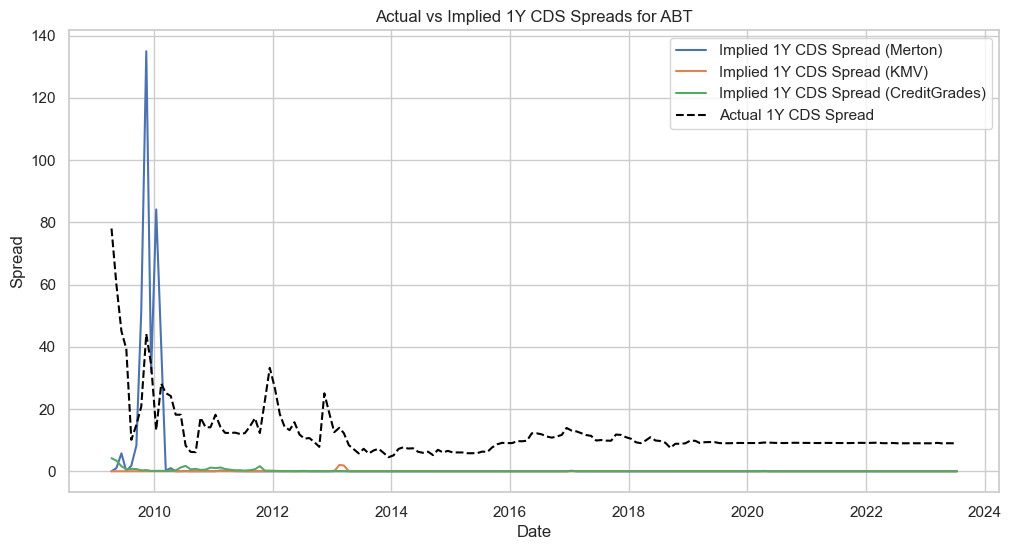

In [484]:
plot_cds_spreads(IS_full_dict, 'ABT', '1Y')

In [475]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cds_spreads(full_dict, ticker, maturity):
    """
    Plot actual vs implied CDS spreads for a given ticker and maturity,
    including all models (Merton, KMV, CreditGrades).

    :param full_dict: Dictionary containing PnL results for different models and tickers.
    :param ticker: Ticker symbol for the company.
    :param maturity: Maturity time as a string ('0.5Y' or '1Y').
    """
    # Define model names
    models = ['Merton', 'KMV', 'CreditGrades']
    plt.figure(figsize=(12, 6))

    # Column names
    actual_col = f'{ticker}_{maturity}'

    # Plot each model's implied spread
    for index, model in enumerate(models):
        df = full_dict[ticker][index]

        if df is None or df.empty:
            print(f"No data available for ticker {ticker} and model {model}.")
            continue

        # Ensure that the 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        implied_col = f'implied_{ticker}_{maturity}'

        # Check if the columns exist
        if actual_col not in df.columns or implied_col not in df.columns:
            print(f"Columns for {maturity} maturity not found in the DataFrame for model {model}.")
            continue

        plt.plot(df['Date'], df[implied_col], label=f'Implied {maturity} CDS Spread ({model})')

    # Assuming the actual market spread data is consistent across models, use the first model's DataFrame
    if full_dict[ticker][0] is not None and not full_dict[ticker][0].empty:
        df = full_dict[ticker][0]
        if actual_col in df.columns:
            plt.plot(df['Date'], df[actual_col], label=f'Actual {maturity} CDS Spread', color='black', linestyle='dashed')

    plt.title(f'Actual vs Implied {maturity} CDS Spreads for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_cds_spreads(IS_full_dict, 'DHI', '1Y')


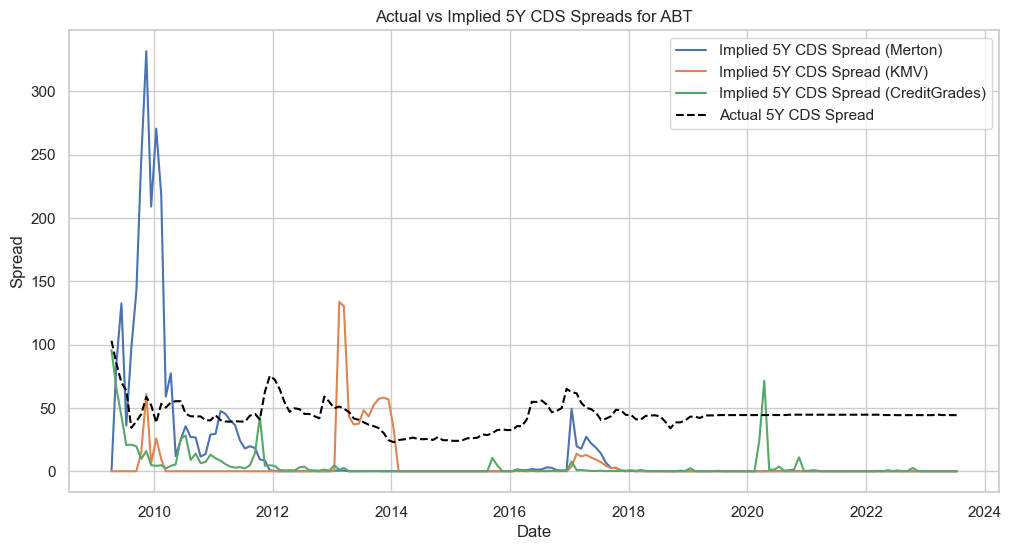

In [501]:
plot_cds_spreads(IS_full_dict, 'ABT', '5Y')

Looking at the model performance for each ticker seperately

In [507]:
count = 0
for ticker in ticker_lst:
    count += 1
    try:
        print(ticker)
        Merton_IS_df = IS_full_dict[ticker][0]
        KMV_IS_df = IS_full_dict[ticker][1]
        CreditGrades_IS_df = IS_full_dict[ticker][2]
        
        start_date = '2010-01-01'
        end_date = '2021-01-01'
        
        Merton_results_df = test_model_IS_accuracy(Merton_IS_df[(Merton_IS_df['Date'] >= pd.Timestamp(start_date)) \
                                    & (Merton_IS_df['Date'] <= pd.Timestamp(end_date))])
        KMV_results_df = test_model_IS_accuracy(KMV_IS_df[(KMV_IS_df['Date'] >= pd.Timestamp(start_date)) \
                                    & (KMV_IS_df['Date'] <= pd.Timestamp(end_date))])
        CreditGrades_results_df = test_model_IS_accuracy(CreditGrades_IS_df[(CreditGrades_IS_df['Date'] >= pd.Timestamp(start_date)) \
                                    & (CreditGrades_IS_df['Date'] <= pd.Timestamp(end_date))])

        print('Merton')
        display(draw_results_table(Merton_results_df))
        print('KMV')
        display(draw_results_table(KMV_results_df))
        print('CreditGrades')
        display(draw_results_table(CreditGrades_results_df))
    except Exception as e:
        print(ticker)
        print(e)

MMM
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.034,0.162,0.696,-838734.909,-0.000,nan
1,1Y,0.038,0.581,0.664,120.237,-0.000,nan
2,2Y,0.083,0.712,0.347,1.822,0.000,nan
3,3Y,0.133,0.709,0.128,0.762,-0.000,nan
4,5Y,0.204,0.658,0.019,0.257,-0.000,nan
5,10Y,-0.307,-0.337,0.000,-0.077,0.000,0.200


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.035,0.026,0.692,-871014400.966,0.000,nan
1,1Y,0.028,0.228,0.754,2643.204,0.000,nan
2,2Y,0.040,0.535,0.646,4.792,0.000,nan
3,3Y,0.072,0.655,0.412,1.303,-0.000,nan
4,5Y,0.177,0.698,0.043,0.462,0.000,nan
5,10Y,-0.111,-0.345,0.207,-0.044,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.152,0.762,0.083,14.651,0.000,nan
1,1Y,0.149,0.833,0.087,1.972,0.000,nan
2,2Y,0.143,0.814,0.102,0.248,-0.000,0.818
3,3Y,0.145,0.766,0.097,0.147,0.000,0.786
4,5Y,0.098,0.693,0.262,0.046,0.000,0.595
5,10Y,-0.244,-0.224,0.005,-0.035,-0.000,0.425


ABT
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.061,0.317,0.485,0.103,0.000,nan
1,1Y,0.178,0.631,0.041,0.107,0.000,nan
2,2Y,0.182,0.693,0.037,0.053,0.000,nan
3,3Y,0.190,0.612,0.029,0.059,0.000,nan
4,5Y,0.121,0.480,0.167,0.039,0.000,nan
5,10Y,-0.072,0.214,0.412,-0.017,0.000,0.049


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.013,-0.165,0.884,-21.304,-0.000,nan
1,1Y,0.056,-0.033,0.520,1.151,-0.000,nan
2,2Y,0.060,0.181,0.491,0.097,0.000,nan
3,3Y,0.025,0.186,0.776,0.025,0.000,nan
4,5Y,-0.021,0.175,0.808,-0.011,0.000,nan
5,10Y,0.078,0.266,0.375,0.015,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.072,0.479,0.414,1.159,-0.000,0.516
1,1Y,0.244,0.722,0.005,3.851,0.000,0.302
2,2Y,0.233,0.731,0.007,1.267,-0.000,0.150
3,3Y,0.182,0.647,0.037,0.587,-0.000,0.106
4,5Y,0.120,0.480,0.170,0.148,-0.000,0.066
5,10Y,-0.017,0.175,0.844,-0.006,0.000,0.049


AET
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.247,0.360,0.004,0.796,0.000,nan
1,1Y,0.215,0.402,0.013,0.252,-0.000,nan
2,2Y,0.219,0.458,0.012,0.114,0.000,nan
3,3Y,0.266,0.458,0.002,0.135,0.000,nan
4,5Y,0.345,0.432,0.000,0.139,-0.000,nan
5,10Y,0.352,0.402,0.000,0.071,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.248,0.327,0.004,171.070,0.000,nan
1,1Y,0.216,0.362,0.013,4.352,-0.000,nan
2,2Y,0.191,0.461,0.029,0.465,-0.000,nan
3,3Y,0.216,0.436,0.013,0.367,0.000,nan
4,5Y,0.269,0.411,0.002,0.244,-0.000,nan
5,10Y,0.203,0.351,0.020,0.063,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.601,0.416,0.000,0.446,-0.000,0.917
1,1Y,0.686,0.526,0.000,0.523,0.000,0.948
2,2Y,0.755,0.613,0.000,0.341,0.000,0.954
3,3Y,0.763,0.605,0.000,0.331,0.000,0.974
4,5Y,0.717,0.575,0.000,0.235,0.000,0.957
5,10Y,0.580,0.503,0.000,0.089,0.000,0.958


A
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.070,0.201,0.423,26.574,-0.000,nan
1,1Y,0.048,0.055,0.585,0.901,0.000,nan
2,2Y,0.140,0.183,0.110,0.303,-0.000,nan
3,3Y,0.242,0.321,0.005,0.274,0.000,nan
4,5Y,0.265,0.455,0.002,0.086,0.000,nan
5,10Y,-0.243,-0.323,0.005,-0.095,0.000,0.058


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.036,0.169,0.680,170.819,-0.000,nan
1,1Y,0.028,0.101,0.753,2.584,0.000,nan
2,2Y,0.060,0.127,0.497,0.425,0.000,nan
3,3Y,0.120,0.235,0.170,0.402,0.000,nan
4,5Y,0.171,0.400,0.049,0.138,0.000,nan
5,10Y,-0.184,-0.225,0.034,-0.127,-0.000,0.101


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.039,-0.022,0.661,1.245,0.000,0.751
1,1Y,0.015,0.025,0.864,0.134,0.000,0.694
2,2Y,0.086,0.092,0.325,0.154,0.000,0.650
3,3Y,0.153,0.223,0.080,0.156,0.000,0.635
4,5Y,0.242,0.411,0.005,0.074,0.000,0.554
5,10Y,-0.185,-0.301,0.034,-0.067,0.000,0.521


APD
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.520,0.334,0.000,44640.674,0.000,nan
1,1Y,0.521,0.595,0.000,116.672,0.000,nan
2,2Y,0.469,0.790,0.000,3.850,-0.000,nan
3,3Y,0.433,0.846,0.000,1.597,-0.000,nan
4,5Y,0.424,0.820,0.000,0.620,-0.000,nan
5,10Y,0.395,0.728,0.000,0.167,0.000,0.452


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.411,0.211,0.000,344421.534,0.000,nan
1,1Y,0.451,0.264,0.000,337.535,-0.000,nan
2,2Y,0.414,0.691,0.000,6.488,0.000,nan
3,3Y,0.333,0.811,0.000,1.931,0.000,nan
4,5Y,0.186,0.786,0.033,0.361,0.000,nan
5,10Y,0.094,0.694,0.285,0.049,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.241,0.483,0.005,56.431,-0.000,nan
1,1Y,0.231,0.667,0.008,9.266,0.000,0.806
2,2Y,0.282,0.773,0.001,1.699,0.000,0.681
3,3Y,0.339,0.816,0.000,1.166,0.000,0.618
4,5Y,0.393,0.736,0.000,0.601,-0.000,0.554
5,10Y,0.423,0.631,0.000,0.176,-0.000,0.486


AGN
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.132,-0.284,0.131,-0.044,0.000,nan
1,1Y,-0.186,-0.299,0.033,-0.054,0.000,nan
2,2Y,-0.200,-0.312,0.021,-0.038,0.000,nan
3,3Y,-0.202,-0.263,0.020,-0.039,0.000,0.307
4,5Y,-0.159,-0.195,0.068,-0.029,-0.000,0.309
5,10Y,-0.048,0.053,0.581,-0.010,0.000,0.664


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.015,-0.180,0.861,-8.887,0.000,nan
1,1Y,-0.085,-0.217,0.330,-1.395,0.000,nan
2,2Y,-0.070,-0.227,0.424,-0.102,0.000,nan
3,3Y,-0.072,-0.177,0.414,-0.063,-0.000,nan
4,5Y,-0.061,-0.139,0.490,-0.028,0.000,0.138
5,10Y,0.019,0.067,0.828,0.006,-0.000,0.164


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.039,-0.113,0.656,0.831,0.000,0.019
1,1Y,0.016,-0.210,0.856,0.184,0.000,0.010
2,2Y,-0.045,-0.256,0.612,-0.114,-0.000,0.003
3,3Y,-0.052,-0.248,0.556,-0.081,0.000,0.003
4,5Y,-0.130,-0.318,0.139,-0.094,0.000,0.006
5,10Y,-0.259,-0.232,0.003,-0.113,0.000,0.030


LNT
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.051,0.067,0.565,-0.010,-0.000,nan
1,1Y,-0.032,0.124,0.718,-0.007,-0.000,nan
2,2Y,0.028,0.055,0.746,0.006,-0.000,0.010
3,3Y,0.026,0.053,0.765,0.006,0.000,0.012
4,5Y,-0.076,-0.053,0.385,-0.015,0.000,0.017
5,10Y,0.134,0.176,0.125,0.026,0.000,0.031


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.056,0.031,0.522,-0.191,-0.000,nan
1,1Y,-0.066,-0.085,0.449,-0.088,0.000,nan
2,2Y,-0.082,-0.162,0.347,-0.049,0.000,nan
3,3Y,-0.106,-0.163,0.228,-0.056,0.000,nan
4,5Y,-0.206,-0.240,0.018,-0.077,0.000,0.002
5,10Y,-0.076,0.019,0.384,-0.023,0.000,0.002


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.552,0.560,0.000,2.068,0.000,0.029
1,1Y,0.433,0.497,0.000,1.700,0.000,0.089
2,2Y,0.256,0.334,0.003,0.378,0.000,0.123
3,3Y,0.201,0.277,0.021,0.201,-0.000,0.000
4,5Y,0.078,0.086,0.375,0.034,0.000,0.000
5,10Y,0.049,0.209,0.578,0.011,-0.000,0.000


MO
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.040,0.224,0.652,-1987.414,-0.000,nan
1,1Y,-0.054,0.282,0.537,-13.433,0.000,nan
2,2Y,-0.061,0.422,0.487,-0.650,0.000,nan
3,3Y,-0.054,0.431,0.539,-0.275,0.000,nan
4,5Y,-0.063,0.392,0.474,-0.132,0.000,0.767
5,10Y,-0.060,0.382,0.497,-0.044,-0.000,0.772


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.024,0.072,0.784,-13345624169316.527,-0.000,nan
1,1Y,-0.034,0.182,0.701,-978215.500,0.000,nan
2,2Y,-0.034,0.235,0.700,-140.747,0.000,nan
3,3Y,-0.021,0.272,0.812,-6.378,-0.000,nan
4,5Y,-0.034,0.270,0.698,-0.819,0.000,nan
5,10Y,-0.081,0.244,0.357,-0.199,-0.000,0.025


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.000,0.831,0.997,-0.011,0.000,0.581
1,1Y,-0.014,0.817,0.875,-0.181,-0.000,0.812
2,2Y,-0.008,0.801,0.928,-0.026,-0.000,0.791
3,3Y,0.006,0.754,0.950,0.013,-0.000,0.765
4,5Y,0.009,0.669,0.918,0.012,-0.000,0.721
5,10Y,0.008,0.531,0.929,0.004,0.000,0.636


AMGN
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.091,0.066,0.300,-1005.538,-0.000,nan
1,1Y,0.015,-0.010,0.868,0.863,0.000,nan
2,2Y,0.221,0.094,0.011,0.606,0.000,0.013
3,3Y,0.318,0.147,0.000,0.448,0.000,0.015
4,5Y,0.327,0.146,0.000,0.208,0.000,0.019
5,10Y,0.345,0.319,0.000,0.094,-0.000,0.031


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,nan,nan,nan,0.000,0.000,nan
1,1Y,-0.010,-0.033,0.907,-291294.326,-0.000,nan
2,2Y,-0.004,-0.005,0.962,-11.554,-0.000,nan
3,3Y,0.069,0.005,0.429,11.809,0.000,nan
4,5Y,0.112,-0.031,0.202,1.245,-0.000,0.106
5,10Y,0.069,0.020,0.431,0.074,-0.000,0.143


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.250,0.099,0.004,64.499,0.000,0.000
1,1Y,0.104,0.127,0.234,8.582,0.000,0.000
2,2Y,0.066,0.232,0.451,0.484,0.000,0.000
3,3Y,0.059,0.230,0.501,0.196,0.000,0.000
4,5Y,0.013,0.166,0.879,0.015,0.000,0.000
5,10Y,-0.063,0.044,0.471,-0.021,0.000,0.000


APC
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.149,0.112,0.107,0.114,-0.000,nan
1,1Y,0.132,0.040,0.154,0.110,-0.000,nan
2,2Y,0.179,0.124,0.053,0.137,-0.000,nan
3,3Y,0.236,0.279,0.010,0.193,-0.000,0.231
4,5Y,0.321,0.437,0.000,0.256,-0.000,0.193
5,10Y,0.280,0.461,0.002,0.157,0.000,0.114


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.021,0.120,0.821,-0.393,-0.000,nan
1,1Y,0.017,0.119,0.851,0.095,-0.000,nan
2,2Y,0.087,0.170,0.347,0.168,-0.000,nan
3,3Y,0.132,0.278,0.154,0.209,0.000,nan
4,5Y,0.206,0.379,0.025,0.225,0.000,nan
5,10Y,0.212,0.394,0.021,0.119,0.000,0.165


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.629,0.435,0.000,2.093,-0.000,0.042
1,1Y,0.621,0.442,0.000,1.569,-0.000,0.027
2,2Y,0.649,0.551,0.000,0.945,0.000,0.050
3,3Y,0.686,0.653,0.000,0.895,-0.000,0.145
4,5Y,0.737,0.727,0.000,0.742,-0.000,0.661
5,10Y,0.711,0.736,0.000,0.433,-0.000,0.928


CAR
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.049,0.167,0.626,0.241,0.000,0.083
1,1Y,0.072,0.234,0.471,0.118,-0.000,0.013
2,2Y,0.114,0.342,0.254,0.054,-0.000,0.008
3,3Y,0.169,0.413,0.090,0.050,-0.000,0.005
4,5Y,0.308,0.490,0.002,0.060,-0.000,0.011
5,10Y,0.416,0.514,0.000,0.083,0.000,0.161


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.117,0.281,0.242,0.024,-0.000,0.030
1,1Y,0.146,0.299,0.143,0.031,-0.000,0.014
2,2Y,0.226,0.384,0.022,0.042,-0.000,0.134
3,3Y,0.307,0.447,0.002,0.058,0.000,0.105
4,5Y,0.465,0.530,0.000,0.104,-0.000,0.400
5,10Y,0.598,0.471,0.000,0.206,-0.000,0.459


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.509,0.530,0.000,0.258,-0.000,0.048
1,1Y,0.595,0.507,0.000,0.509,0.000,0.016
2,2Y,0.662,0.515,0.000,0.688,-0.000,0.030
3,3Y,0.686,0.557,0.000,0.786,-0.000,0.062
4,5Y,0.695,0.637,0.000,0.813,-0.000,0.027
5,10Y,0.681,0.644,0.000,0.782,-0.000,0.004


AVP
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.523,0.621,0.000,0.022,-0.000,nan
1,1Y,0.573,0.663,0.000,0.038,0.000,0.442
2,2Y,0.631,0.777,0.000,0.097,0.000,0.605
3,3Y,0.600,0.787,0.000,0.161,-0.000,0.576
4,5Y,0.487,0.728,0.000,0.247,-0.000,0.561
5,10Y,0.492,0.682,0.000,0.368,-0.000,0.128


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.117,0.461,0.183,0.016,0.000,nan
1,1Y,0.280,0.510,0.001,0.078,0.000,nan
2,2Y,0.516,0.634,0.000,0.344,0.000,0.211
3,3Y,0.638,0.695,0.000,0.673,0.000,0.150
4,5Y,0.686,0.710,0.000,1.025,-0.000,0.050
5,10Y,0.643,0.641,0.000,0.903,0.000,0.002


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.614,0.698,0.000,0.173,-0.000,0.305
1,1Y,0.694,0.740,0.000,0.338,0.000,0.153
2,2Y,0.803,0.843,0.000,0.627,0.000,0.207
3,3Y,0.846,0.870,0.000,0.891,-0.000,0.314
4,5Y,0.847,0.851,0.000,1.059,-0.000,0.457
5,10Y,0.853,0.852,0.000,0.942,-0.000,0.065


BAX
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.011,0.179,0.901,71.671,0.000,nan
1,1Y,0.027,0.373,0.754,1.610,0.000,nan
2,2Y,0.244,0.444,0.005,0.768,0.000,nan
3,3Y,0.265,0.308,0.002,0.410,0.000,nan
4,5Y,0.265,0.205,0.002,0.174,-0.000,nan
5,10Y,0.010,0.063,0.909,0.002,-0.000,0.152


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.052,0.175,0.556,0.602,0.000,nan
1,1Y,0.026,0.101,0.763,0.040,0.000,nan
2,2Y,0.097,0.332,0.269,0.037,-0.000,nan
3,3Y,0.158,0.348,0.070,0.051,0.000,nan
4,5Y,0.339,0.333,0.000,0.084,0.000,nan
5,10Y,0.365,0.094,0.000,0.048,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.014,-0.031,0.872,0.061,0.000,0.636
1,1Y,0.027,0.126,0.755,0.120,0.000,0.543
2,2Y,0.168,0.307,0.054,0.271,0.000,0.431
3,3Y,0.169,0.217,0.053,0.179,0.000,0.379
4,5Y,0.150,0.144,0.086,0.080,0.000,0.302
5,10Y,0.001,0.068,0.993,0.000,0.000,0.204


BA
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.037,0.344,0.672,0.003,-0.000,nan
1,1Y,0.036,0.524,0.685,0.004,0.000,nan
2,2Y,-0.018,0.573,0.842,-0.003,0.000,nan
3,3Y,0.014,0.578,0.876,0.003,0.000,nan
4,5Y,-0.000,0.604,0.998,-0.000,0.000,0.056
5,10Y,0.084,0.644,0.340,0.017,-0.000,0.047


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.042,0.192,0.630,0.074,0.000,nan
1,1Y,0.048,0.270,0.585,0.030,0.000,nan
2,2Y,-0.016,0.536,0.855,-0.006,0.000,nan
3,3Y,0.007,0.561,0.932,0.003,0.000,nan
4,5Y,-0.035,0.586,0.689,-0.014,0.000,nan
5,10Y,0.011,0.625,0.902,0.003,-0.000,0.070


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.055,0.561,0.530,-0.009,-0.000,0.122
1,1Y,-0.054,0.603,0.540,-0.008,0.000,0.175
2,2Y,-0.047,0.582,0.590,-0.007,0.000,0.098
3,3Y,-0.009,0.601,0.919,-0.002,-0.000,0.121
4,5Y,0.024,0.628,0.783,0.005,0.000,0.193
5,10Y,0.148,0.691,0.090,0.024,0.000,0.328


BWA
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.069,0.447,0.435,0.179,-0.000,nan
1,1Y,0.121,0.527,0.168,0.103,0.000,nan
2,2Y,0.068,0.399,0.441,0.025,0.000,nan
3,3Y,0.105,0.360,0.229,0.040,0.000,nan
4,5Y,0.214,0.382,0.014,0.074,-0.000,0.311
5,10Y,0.188,0.302,0.031,0.037,0.000,0.278


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.129,0.326,0.140,103.578,0.000,nan
1,1Y,0.170,0.522,0.052,2.826,0.000,nan
2,2Y,0.055,0.419,0.528,0.096,0.000,nan
3,3Y,0.088,0.370,0.317,0.105,-0.000,nan
4,5Y,0.166,0.374,0.057,0.110,-0.000,nan
5,10Y,0.135,0.282,0.124,0.034,-0.000,0.146


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.119,0.388,0.173,0.234,0.000,0.543
1,1Y,0.211,0.527,0.015,0.228,-0.000,0.617
2,2Y,0.311,0.452,0.000,0.173,-0.000,0.585
3,3Y,0.396,0.439,0.000,0.220,0.000,0.572
4,5Y,0.493,0.479,0.000,0.219,-0.000,0.418
5,10Y,0.401,0.420,0.000,0.087,0.000,0.704


BSX
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.695,0.777,0.000,0.531,0.000,nan
1,1Y,0.799,0.804,0.000,0.494,-0.000,nan
2,2Y,0.852,0.806,0.000,0.415,-0.000,nan
3,3Y,0.845,0.799,0.000,0.449,0.000,nan
4,5Y,0.824,0.773,0.000,0.427,-0.000,0.095
5,10Y,0.732,0.719,0.000,0.235,-0.000,0.080


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.493,0.616,0.000,871.916,0.000,nan
1,1Y,0.612,0.682,0.000,24.383,-0.000,nan
2,2Y,0.707,0.720,0.000,2.900,0.000,nan
3,3Y,0.701,0.695,0.000,1.827,0.000,nan
4,5Y,0.650,0.663,0.000,0.882,0.000,nan
5,10Y,0.558,0.602,0.000,0.276,-0.000,0.099


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.702,0.848,0.000,1.446,-0.000,0.632
1,1Y,0.781,0.848,0.000,1.213,0.000,0.566
2,2Y,0.869,0.881,0.000,0.686,-0.000,0.593
3,3Y,0.886,0.865,0.000,0.622,-0.000,0.596
4,5Y,0.869,0.810,0.000,0.449,0.000,0.598
5,10Y,0.755,0.733,0.000,0.192,0.000,0.608


BMY
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.008,0.066,0.925,-0.008,0.000,nan
1,1Y,-0.065,0.209,0.460,-0.019,0.000,nan
2,2Y,-0.111,0.158,0.206,-0.013,-0.000,nan
3,3Y,-0.128,0.120,0.142,-0.015,0.000,nan
4,5Y,-0.156,0.067,0.074,-0.019,-0.000,nan
5,10Y,-0.293,-0.147,0.001,-0.023,-0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.001,0.002,0.993,-5.666,-0.000,nan
1,1Y,-0.054,0.054,0.540,-2.010,0.000,nan
2,2Y,-0.108,0.162,0.217,-0.161,-0.000,nan
3,3Y,-0.130,0.138,0.137,-0.097,0.000,nan
4,5Y,-0.168,0.067,0.055,-0.061,0.000,nan
5,10Y,-0.306,-0.148,0.000,-0.043,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.000,0.489,0.995,-0.021,0.000,nan
1,1Y,-0.038,0.434,0.662,-0.486,0.000,0.855
2,2Y,-0.073,0.366,0.409,-0.151,0.000,0.720
3,3Y,-0.084,0.289,0.339,-0.106,-0.000,0.187
4,5Y,-0.098,0.217,0.266,-0.061,-0.000,0.097
5,10Y,-0.215,-0.053,0.013,-0.043,0.000,0.000


CAM
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.055,0.065,0.633,-18.164,0.000,nan
1,1Y,-0.065,0.270,0.569,-1.219,0.000,nan
2,2Y,-0.048,0.193,0.679,-0.116,-0.000,nan
3,3Y,-0.040,0.091,0.730,-0.062,0.000,nan
4,5Y,-0.124,0.038,0.278,-0.085,0.000,nan
5,10Y,0.017,0.252,0.882,0.004,0.000,0.005


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.044,-0.105,0.699,-1862.996,0.000,nan
1,1Y,-0.038,0.270,0.739,-8.655,0.000,nan
2,2Y,0.026,0.248,0.819,0.242,0.000,nan
3,3Y,0.065,0.150,0.573,0.272,-0.000,nan
4,5Y,-0.068,0.021,0.554,-0.088,0.000,0.411
5,10Y,-0.065,0.207,0.575,-0.023,-0.000,0.403


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.090,-0.055,0.434,16.908,0.000,0.038
1,1Y,0.298,0.135,0.008,7.766,0.000,0.007
2,2Y,0.444,0.358,0.000,1.465,0.000,0.002
3,3Y,0.488,0.302,0.000,0.963,0.000,0.002
4,5Y,0.547,0.358,0.000,0.430,0.000,0.003
5,10Y,0.628,0.461,0.000,0.175,0.000,0.002


CRS
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.291,0.136,0.100,-1.395,0.000,nan
1,1Y,-0.304,0.141,0.085,-0.420,0.000,0.218
2,2Y,-0.306,-0.107,0.083,-0.079,0.000,0.227
3,3Y,-0.242,0.273,0.174,-0.076,0.000,0.188
4,5Y,-0.216,0.089,0.227,-0.046,0.000,0.180
5,10Y,-0.095,0.137,0.598,-0.015,0.000,0.150


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.160,0.099,0.374,-0.004,0.000,nan
1,1Y,-0.159,0.133,0.378,-0.004,0.000,nan
2,2Y,-0.181,-0.106,0.314,-0.003,0.000,0.174
3,3Y,-0.142,0.268,0.430,-0.003,0.000,0.135
4,5Y,-0.150,0.110,0.405,-0.003,0.000,0.106
5,10Y,0.119,0.274,0.511,0.010,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.035,-0.286,0.846,-1.069,0.000,0.175
1,1Y,-0.087,-0.329,0.630,-0.523,0.000,0.188
2,2Y,0.116,-0.218,0.521,0.073,0.000,0.161
3,3Y,-0.105,-0.201,0.561,-0.065,0.000,0.169
4,5Y,-0.132,-0.278,0.464,-0.043,0.000,0.163
5,10Y,-0.153,-0.249,0.394,-0.032,0.000,0.183


CAT
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.145,0.631,0.097,0.005,0.000,0.030
1,1Y,0.266,0.700,0.002,0.016,0.000,0.033
2,2Y,0.459,0.727,0.000,0.046,0.000,0.031
3,3Y,0.555,0.750,0.000,0.084,0.000,0.037
4,5Y,0.618,0.756,0.000,0.139,0.000,0.083
5,10Y,0.400,0.590,0.000,0.088,-0.000,0.001


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.089,0.698,0.313,0.014,-0.000,nan
1,1Y,0.203,0.770,0.019,0.042,0.000,nan
2,2Y,0.383,0.744,0.000,0.079,0.000,0.024
3,3Y,0.447,0.751,0.000,0.112,-0.000,0.024
4,5Y,0.502,0.721,0.000,0.136,0.000,0.021
5,10Y,0.370,0.585,0.000,0.073,-0.000,0.012


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.476,0.504,0.000,0.458,0.000,0.030
1,1Y,0.545,0.588,0.000,0.508,0.000,0.003
2,2Y,0.573,0.597,0.000,0.307,0.000,0.000
3,3Y,0.555,0.583,0.000,0.297,0.000,0.000
4,5Y,0.478,0.518,0.000,0.204,0.000,0.001
5,10Y,0.306,0.309,0.000,0.075,0.000,0.349


CVX
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.003,0.335,0.970,12.156,0.000,nan
1,1Y,-0.015,0.416,0.868,-0.532,-0.000,nan
2,2Y,0.019,0.403,0.830,0.051,-0.000,nan
3,3Y,0.082,0.471,0.348,0.149,-0.000,nan
4,5Y,0.194,0.580,0.026,0.213,0.000,nan
5,10Y,0.316,0.589,0.000,0.124,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.001,0.196,0.989,571210.525,-0.000,nan
1,1Y,-0.009,0.325,0.918,-139.967,-0.000,nan
2,2Y,0.026,0.548,0.765,1.653,0.000,nan
3,3Y,0.083,0.465,0.343,1.341,-0.000,nan
4,5Y,0.158,0.520,0.070,0.606,0.000,nan
5,10Y,0.222,0.549,0.010,0.157,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.233,0.416,0.007,2.537,0.000,0.651
1,1Y,0.209,0.407,0.016,0.569,-0.000,0.139
2,2Y,0.298,0.631,0.001,0.247,0.000,0.064
3,3Y,0.357,0.679,0.000,0.283,0.000,0.044
4,5Y,0.394,0.732,0.000,0.259,0.000,0.023
5,10Y,0.442,0.731,0.000,0.117,0.000,0.015


CI
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.095,0.499,0.280,-0.014,0.000,nan
1,1Y,-0.138,0.451,0.115,-0.029,-0.000,nan
2,2Y,-0.147,0.477,0.093,-0.033,0.000,nan
3,3Y,-0.109,0.458,0.213,-0.029,0.000,nan
4,5Y,-0.033,0.423,0.710,-0.009,-0.000,nan
5,10Y,0.045,0.256,0.612,0.009,0.000,0.065


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.062,0.240,0.479,-1.874,-0.000,nan
1,1Y,-0.057,0.401,0.517,-0.256,-0.000,nan
2,2Y,-0.032,0.468,0.714,-0.034,-0.000,nan
3,3Y,-0.019,0.435,0.830,-0.016,0.000,nan
4,5Y,0.000,0.401,0.997,0.000,0.000,nan
5,10Y,-0.028,0.227,0.753,-0.007,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.774,0.659,0.000,0.158,0.000,0.566
1,1Y,0.785,0.744,0.000,0.268,-0.000,0.295
2,2Y,0.727,0.767,0.000,0.214,0.000,0.422
3,3Y,0.702,0.729,0.000,0.214,0.000,0.383
4,5Y,0.643,0.664,0.000,0.177,-0.000,0.326
5,10Y,0.481,0.482,0.000,0.080,0.000,0.278


CL
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,nan,nan,nan,0.000,-0.000,nan
1,1Y,nan,nan,nan,0.000,0.000,nan
2,2Y,0.096,0.307,0.275,12384466.701,-0.000,nan
3,3Y,0.102,0.325,0.246,26414.939,0.000,nan
4,5Y,0.095,0.109,0.278,83.100,0.000,nan
5,10Y,-0.041,-0.210,0.643,-0.422,0.000,0.003


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,nan,nan,nan,0.000,-0.000,nan
1,1Y,nan,nan,nan,0.000,0.000,nan
2,2Y,0.098,0.135,0.261,2903057258.223,-0.000,nan
3,3Y,0.104,0.248,0.236,959861.032,0.000,nan
4,5Y,0.093,0.152,0.289,648.606,0.000,nan
5,10Y,0.012,-0.241,0.895,0.320,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.151,0.429,0.083,3997.743,0.000,0.000
1,1Y,0.153,0.516,0.080,83.373,-0.000,0.000
2,2Y,0.140,0.494,0.108,2.300,0.000,0.000
3,3Y,0.131,0.490,0.135,0.722,-0.000,0.000
4,5Y,0.089,0.374,0.312,0.101,0.000,0.001
5,10Y,-0.051,-0.043,0.563,-0.013,-0.000,0.001


CMCSA
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.403,0.648,0.000,0.089,0.000,nan
1,1Y,0.626,0.760,0.000,0.142,-0.000,nan
2,2Y,0.733,0.703,0.000,0.165,0.000,0.294
3,3Y,0.739,0.631,0.000,0.210,-0.000,0.302
4,5Y,0.735,0.602,0.000,0.246,-0.000,0.458
5,10Y,0.645,0.575,0.000,0.168,-0.000,0.328


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.167,0.627,0.055,6.866,-0.000,nan
1,1Y,0.332,0.749,0.000,1.760,0.000,nan
2,2Y,0.475,0.696,0.000,0.707,-0.000,nan
3,3Y,0.558,0.632,0.000,0.737,0.000,nan
4,5Y,0.674,0.614,0.000,0.629,0.000,0.295
5,10Y,0.657,0.565,0.000,0.262,-0.000,0.125


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.469,0.653,0.000,0.469,0.000,0.292
1,1Y,0.457,0.749,0.000,0.441,-0.000,0.229
2,2Y,0.469,0.643,0.000,0.295,-0.000,0.185
3,3Y,0.478,0.548,0.000,0.307,-0.000,0.172
4,5Y,0.483,0.483,0.000,0.255,0.000,0.158
5,10Y,0.369,0.363,0.000,0.097,-0.000,0.139


CMC
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.566,0.435,0.000,0.100,0.000,nan
1,1Y,0.620,0.394,0.000,0.216,0.000,0.017
2,2Y,0.640,0.393,0.000,0.355,-0.000,0.013
3,3Y,0.646,0.473,0.000,0.452,0.000,0.016
4,5Y,0.567,0.428,0.000,0.430,0.000,0.018
5,10Y,0.414,0.433,0.000,0.241,0.000,0.020


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.380,0.369,0.000,4.027,0.000,nan
1,1Y,0.506,0.324,0.000,2.324,0.000,nan
2,2Y,0.535,0.325,0.000,0.998,-0.000,0.002
3,3Y,0.566,0.490,0.000,0.898,-0.000,0.002
4,5Y,0.531,0.445,0.000,0.539,0.000,0.003
5,10Y,0.452,0.462,0.000,0.234,0.000,0.002


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.603,0.566,0.000,0.984,0.000,0.025
1,1Y,0.602,0.509,0.000,1.117,-0.000,0.009
2,2Y,0.590,0.453,0.000,0.708,-0.000,0.007
3,3Y,0.554,0.466,0.000,0.605,-0.000,0.006
4,5Y,0.457,0.382,0.000,0.350,0.000,0.010
5,10Y,0.335,0.333,0.000,0.154,0.000,0.027


COP
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.240,0.667,0.005,0.152,0.000,nan
1,1Y,0.279,0.602,0.001,0.103,-0.000,nan
2,2Y,0.347,0.616,0.000,0.108,0.000,nan
3,3Y,0.366,0.646,0.000,0.152,0.000,nan
4,5Y,0.354,0.535,0.000,0.175,0.000,nan
5,10Y,0.346,0.397,0.000,0.121,0.000,0.013


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.044,0.482,0.616,2.087,0.000,nan
1,1Y,0.087,0.512,0.324,0.398,-0.000,nan
2,2Y,0.177,0.564,0.042,0.214,0.000,nan
3,3Y,0.210,0.588,0.016,0.240,-0.000,nan
4,5Y,0.227,0.473,0.009,0.199,-0.000,nan
5,10Y,0.280,0.336,0.001,0.117,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.138,0.795,0.115,0.137,0.000,0.062
1,1Y,0.202,0.794,0.020,0.128,0.000,0.079
2,2Y,0.321,0.776,0.000,0.158,0.000,0.075
3,3Y,0.359,0.785,0.000,0.213,-0.000,0.069
4,5Y,0.393,0.684,0.000,0.235,-0.000,0.062
5,10Y,0.447,0.577,0.000,0.154,0.000,0.044


CVG
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.225,-0.297,0.010,-14.945,0.000,nan
1,1Y,-0.210,-0.424,0.016,-2.621,0.000,nan
2,2Y,-0.125,-0.322,0.153,-0.370,-0.000,nan
3,3Y,-0.129,-0.342,0.140,-0.267,0.000,nan
4,5Y,-0.125,-0.278,0.155,-0.152,-0.000,nan
5,10Y,-0.055,-0.083,0.528,-0.038,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.256,-0.297,0.003,-255.654,-0.000,nan
1,1Y,-0.225,-0.394,0.010,-11.321,0.000,nan
2,2Y,-0.131,-0.348,0.135,-0.747,-0.000,nan
3,3Y,-0.134,-0.378,0.125,-0.431,0.000,nan
4,5Y,-0.134,-0.283,0.125,-0.189,-0.000,nan
5,10Y,-0.102,-0.032,0.244,-0.060,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.038,0.293,0.664,-0.462,0.000,0.328
1,1Y,0.149,0.313,0.088,0.670,0.000,0.391
2,2Y,0.338,0.411,0.000,0.328,0.000,0.394
3,3Y,0.343,0.385,0.000,0.203,-0.000,0.376
4,5Y,0.263,0.404,0.002,0.076,-0.000,0.345
5,10Y,0.235,0.155,0.007,0.035,0.000,0.302


GLW
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.122,-0.141,0.163,-83.251,0.000,nan
1,1Y,-0.118,0.178,0.178,-2.403,-0.000,nan
2,2Y,-0.156,0.149,0.074,-0.354,-0.000,nan
3,3Y,-0.154,0.131,0.078,-0.228,0.000,0.093
4,5Y,-0.104,0.120,0.233,-0.111,0.000,0.121
5,10Y,-0.030,0.158,0.731,-0.014,-0.000,0.098


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.025,-0.133,0.774,-647946919.999,0.000,nan
1,1Y,-0.029,0.104,0.740,-3399.941,-0.000,nan
2,2Y,-0.094,0.165,0.282,-15.563,-0.000,nan
3,3Y,-0.108,0.166,0.218,-2.873,0.000,nan
4,5Y,-0.123,0.119,0.162,-0.640,0.000,nan
5,10Y,-0.125,0.135,0.152,-0.116,0.000,0.098


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.080,0.152,0.364,-0.241,0.000,0.871
1,1Y,-0.068,0.163,0.437,-0.114,-0.000,0.768
2,2Y,-0.082,0.228,0.347,-0.063,-0.000,0.694
3,3Y,-0.069,0.179,0.434,-0.046,0.000,0.645
4,5Y,-0.008,0.235,0.924,-0.005,0.000,0.575
5,10Y,0.100,0.227,0.255,0.029,-0.000,0.484


CVS
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.139,0.597,0.111,0.001,0.000,nan
1,1Y,0.127,0.655,0.146,0.001,-0.000,nan
2,2Y,0.151,0.617,0.084,0.003,0.000,nan
3,3Y,0.226,0.635,0.009,0.008,0.000,nan
4,5Y,0.460,0.697,0.000,0.053,0.000,nan
5,10Y,0.422,0.572,0.000,0.099,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.022,0.391,0.799,0.001,0.000,nan
1,1Y,0.066,0.581,0.450,0.004,0.000,nan
2,2Y,0.166,0.650,0.056,0.016,0.000,nan
3,3Y,0.250,0.596,0.004,0.029,-0.000,nan
4,5Y,0.495,0.677,0.000,0.091,0.000,nan
5,10Y,0.592,0.607,0.000,0.093,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.189,0.527,0.030,0.031,0.000,0.884
1,1Y,0.185,0.593,0.034,0.035,-0.000,0.875
2,2Y,0.178,0.596,0.042,0.036,-0.000,0.866
3,3Y,0.251,0.629,0.004,0.054,0.000,0.852
4,5Y,0.425,0.678,0.000,0.110,0.000,0.853
5,10Y,0.523,0.634,0.000,0.086,0.000,0.571


DHI
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.516,0.689,0.000,0.228,-0.000,nan
1,1Y,0.594,0.764,0.000,0.277,0.000,nan
2,2Y,0.629,0.748,0.000,0.316,0.000,0.149
3,3Y,0.588,0.709,0.000,0.349,-0.000,0.146
4,5Y,0.501,0.640,0.000,0.309,0.000,0.143
5,10Y,0.385,0.521,0.000,0.170,0.000,0.147


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.351,0.562,0.000,1.439,-0.000,nan
1,1Y,0.372,0.686,0.000,0.687,0.000,nan
2,2Y,0.360,0.696,0.000,0.382,-0.000,nan
3,3Y,0.336,0.652,0.000,0.359,-0.000,nan
4,5Y,0.285,0.589,0.001,0.254,0.000,0.115
5,10Y,0.237,0.506,0.006,0.120,-0.000,0.116


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.655,0.862,0.000,2.936,0.000,0.595
1,1Y,0.609,0.890,0.000,1.590,-0.000,0.547
2,2Y,0.627,0.854,0.000,0.820,-0.000,0.524
3,3Y,0.627,0.812,0.000,0.765,0.000,0.527
4,5Y,0.604,0.734,0.000,0.565,0.000,0.561
5,10Y,0.547,0.633,0.000,0.289,-0.000,0.511


DE
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.121,-0.020,0.168,-0.000,-0.000,0.829
1,1Y,-0.153,-0.058,0.079,-0.001,-0.000,0.871
2,2Y,0.045,0.121,0.608,0.000,-0.000,0.812
3,3Y,0.221,0.280,0.011,0.003,0.000,0.738
4,5Y,0.471,0.352,0.000,0.019,-0.000,0.300
5,10Y,-0.034,0.078,0.703,-0.004,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.053,0.337,0.549,0.001,0.000,0.137
1,1Y,0.069,0.344,0.429,0.002,0.000,0.121
2,2Y,0.350,0.463,0.000,0.020,-0.000,0.062
3,3Y,0.539,0.556,0.000,0.052,0.000,0.025
4,5Y,0.641,0.546,0.000,0.119,-0.000,0.003
5,10Y,0.230,0.299,0.008,0.053,-0.000,0.001


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.218,0.207,0.012,0.041,-0.000,0.578
1,1Y,0.357,0.338,0.000,0.105,-0.000,0.179
2,2Y,0.587,0.603,0.000,0.149,0.000,0.001
3,3Y,0.630,0.691,0.000,0.171,0.000,0.092
4,5Y,0.578,0.690,0.000,0.145,0.000,0.263
5,10Y,0.343,0.444,0.000,0.057,-0.000,0.540


DLX
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.025,0.392,0.776,0.002,0.000,nan
1,1Y,0.030,0.316,0.731,0.004,0.000,nan
2,2Y,0.108,0.383,0.216,0.029,0.000,nan
3,3Y,0.105,0.404,0.231,0.047,0.000,nan
4,5Y,0.185,0.460,0.034,0.137,0.000,0.337
5,10Y,0.289,0.430,0.001,0.180,-0.000,0.093


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.023,0.348,0.794,-0.012,-0.000,nan
1,1Y,0.026,0.268,0.770,0.017,0.000,nan
2,2Y,0.116,0.395,0.187,0.088,-0.000,nan
3,3Y,0.094,0.415,0.285,0.093,0.000,nan
4,5Y,0.138,0.475,0.114,0.160,0.000,nan
5,10Y,0.193,0.437,0.026,0.141,0.000,0.241


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.037,0.395,0.671,-0.039,-0.000,0.754
1,1Y,-0.029,0.304,0.743,-0.031,-0.000,0.685
2,2Y,0.022,0.379,0.807,0.020,0.000,0.837
3,3Y,0.018,0.399,0.835,0.020,-0.000,0.842
4,5Y,0.075,0.452,0.391,0.086,0.000,0.812
5,10Y,0.158,0.373,0.070,0.107,-0.000,0.749


DVN
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.741,0.528,0.000,0.030,-0.000,nan
1,1Y,0.739,0.406,0.000,0.044,-0.000,nan
2,2Y,0.663,0.488,0.000,0.087,0.000,0.505
3,3Y,0.615,0.643,0.000,0.141,0.000,0.470
4,5Y,0.538,0.750,0.000,0.183,0.000,0.398
5,10Y,0.488,0.706,0.000,0.154,0.000,0.196


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.494,0.545,0.000,0.071,0.000,nan
1,1Y,0.579,0.437,0.000,0.106,0.000,nan
2,2Y,0.535,0.495,0.000,0.153,-0.000,0.325
3,3Y,0.485,0.626,0.000,0.208,0.000,0.314
4,5Y,0.453,0.714,0.000,0.235,0.000,0.281
5,10Y,0.468,0.685,0.000,0.187,0.000,0.201


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.580,0.469,0.000,0.130,0.000,0.140
1,1Y,0.665,0.395,0.000,0.169,0.000,0.138
2,2Y,0.651,0.501,0.000,0.220,-0.000,0.106
3,3Y,0.613,0.682,0.000,0.297,-0.000,0.083
4,5Y,0.611,0.795,0.000,0.348,-0.000,0.482
5,10Y,0.655,0.753,0.000,0.305,-0.000,0.372


D
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.273,0.360,0.002,0.026,-0.000,nan
1,1Y,0.257,0.270,0.003,0.028,-0.000,0.123
2,2Y,0.124,0.172,0.157,0.015,-0.000,0.117
3,3Y,0.121,0.217,0.166,0.018,0.000,0.103
4,5Y,0.072,0.145,0.409,0.014,0.000,0.088
5,10Y,0.064,0.097,0.466,0.013,-0.000,0.068


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.195,0.172,0.025,0.605,-0.000,nan
1,1Y,0.202,0.226,0.020,0.199,-0.000,nan
2,2Y,0.131,0.059,0.135,0.057,0.000,nan
3,3Y,0.105,0.059,0.229,0.046,0.000,nan
4,5Y,0.074,0.012,0.396,0.032,-0.000,0.128
5,10Y,0.046,0.002,0.602,0.014,-0.000,0.103


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.211,0.607,0.015,0.388,-0.000,0.000
1,1Y,0.103,0.557,0.239,0.130,0.000,0.000
2,2Y,0.067,0.477,0.447,0.039,-0.000,0.000
3,3Y,0.080,0.484,0.364,0.041,-0.000,0.000
4,5Y,0.048,0.315,0.584,0.019,-0.000,0.000
5,10Y,0.098,0.321,0.262,0.020,0.000,0.000


DOV
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.132,0.170,0.132,-2.660,0.000,nan
1,1Y,-0.162,0.185,0.063,-0.533,0.000,nan
2,2Y,-0.095,0.282,0.277,-0.083,0.000,0.002
3,3Y,0.002,0.261,0.985,0.001,-0.000,0.011
4,5Y,0.117,0.238,0.182,0.041,0.000,0.013
5,10Y,-0.058,-0.053,0.506,-0.011,0.000,0.023


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.004,-0.064,0.967,-2739744.405,-0.000,nan
1,1Y,0.015,0.281,0.868,350.748,0.000,nan
2,2Y,0.020,0.297,0.818,1.557,0.000,nan
3,3Y,-0.050,0.257,0.571,-0.726,0.000,nan
4,5Y,-0.133,0.220,0.129,-0.321,0.000,0.000
5,10Y,-0.181,0.034,0.038,-0.092,-0.000,0.000


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.275,0.086,0.001,3.685,-0.000,0.011
1,1Y,0.285,0.264,0.001,1.149,-0.000,0.001
2,2Y,0.338,0.432,0.000,0.296,0.000,0.000
3,3Y,0.425,0.427,0.000,0.237,0.000,0.000
4,5Y,0.472,0.401,0.000,0.136,-0.000,0.000
5,10Y,0.288,0.168,0.001,0.043,-0.000,0.000


ETN
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.022,0.319,0.799,0.027,0.000,nan
1,1Y,0.183,0.477,0.036,0.098,0.000,nan
2,2Y,0.457,0.638,0.000,0.105,0.000,nan
3,3Y,0.589,0.696,0.000,0.130,-0.000,nan
4,5Y,0.753,0.699,0.000,0.141,-0.000,0.071
5,10Y,0.746,0.427,0.000,0.089,0.000,0.082


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.003,0.238,0.969,-22.854,0.000,nan
1,1Y,0.096,0.490,0.274,5.252,0.000,nan
2,2Y,0.248,0.607,0.004,0.697,0.000,nan
3,3Y,0.322,0.654,0.000,0.478,0.000,nan
4,5Y,0.433,0.646,0.000,0.276,0.000,nan
5,10Y,0.510,0.348,0.000,0.120,0.000,0.027


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.372,0.225,0.000,4.179,0.000,0.000
1,1Y,0.358,0.438,0.000,1.316,-0.000,0.000
2,2Y,0.373,0.627,0.000,0.347,0.000,0.000
3,3Y,0.394,0.680,0.000,0.285,-0.000,0.000
4,5Y,0.379,0.608,0.000,0.166,0.000,0.000
5,10Y,0.212,0.049,0.015,0.041,-0.000,0.187


LLY
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.137,0.173,0.117,15324.341,-0.000,nan
1,1Y,0.100,0.112,0.256,23.072,-0.000,nan
2,2Y,0.041,0.027,0.638,0.325,0.000,nan
3,3Y,0.021,0.096,0.813,0.076,0.000,nan
4,5Y,-0.035,0.115,0.692,-0.051,-0.000,nan
5,10Y,-0.236,-0.220,0.006,-0.115,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.137,0.122,0.117,294427585383.922,-0.000,nan
1,1Y,0.098,0.153,0.265,103938.907,0.000,nan
2,2Y,0.037,-0.067,0.671,20.666,0.000,nan
3,3Y,0.018,0.077,0.836,1.209,-0.000,nan
4,5Y,-0.029,0.050,0.737,-0.237,-0.000,nan
5,10Y,-0.209,-0.215,0.016,-0.243,-0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.259,0.571,0.003,36678.806,0.000,0.048
1,1Y,0.002,0.626,0.977,8.177,0.000,0.014
2,2Y,-0.040,0.442,0.648,-2.592,0.000,0.000
3,3Y,-0.045,0.389,0.606,-0.743,0.000,0.000
4,5Y,-0.056,0.244,0.522,-0.164,0.000,0.000
5,10Y,-0.087,-0.048,0.322,-0.038,-0.000,0.000


EMR
Merton


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.023,0.153,0.792,-241.734,0.000,nan
1,1Y,0.005,0.481,0.950,0.317,0.000,nan
2,2Y,0.066,0.606,0.449,0.166,-0.000,nan
3,3Y,0.160,0.614,0.066,0.182,0.000,nan
4,5Y,0.257,0.520,0.003,0.115,-0.000,nan
5,10Y,0.449,0.501,0.000,0.071,-0.000,0.188


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.011,0.130,0.897,-235120.196,-0.000,nan
1,1Y,0.025,0.344,0.773,70.293,-0.000,nan
2,2Y,0.055,0.576,0.531,1.054,0.000,nan
3,3Y,0.103,0.591,0.239,0.507,0.000,nan
4,5Y,0.137,0.471,0.118,0.151,-0.000,nan
5,10Y,0.314,0.477,0.000,0.079,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.000,0.235,0.999,0.002,-0.000,0.012
1,1Y,0.040,0.419,0.647,0.151,-0.000,0.009
2,2Y,0.093,0.487,0.291,0.075,-0.000,0.006
3,3Y,0.160,0.569,0.068,0.091,-0.000,0.004
4,5Y,0.280,0.516,0.001,0.093,-0.000,0.093
5,10Y,0.499,0.469,0.000,0.067,0.000,0.100


EEP
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.105,0.346,0.229,-0.001,0.000,0.823
1,1Y,-0.134,0.300,0.124,-0.002,0.000,0.899
2,2Y,-0.118,0.318,0.177,-0.002,0.000,0.957
3,3Y,-0.149,0.245,0.088,-0.004,0.000,0.748
4,5Y,-0.129,0.251,0.142,-0.004,-0.000,0.883
5,10Y,-0.082,0.235,0.350,-0.003,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,0.012,0.451,0.893,0.003,-0.000,nan
1,1Y,0.105,0.514,0.229,0.033,-0.000,nan
2,2Y,0.326,0.540,0.000,0.137,-0.000,nan
3,3Y,0.390,0.561,0.000,0.212,-0.000,nan
4,5Y,0.507,0.589,0.000,0.354,-0.000,nan
5,10Y,0.516,0.564,0.000,0.260,0.000,nan


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.001,0.335,0.991,-0.001,0.000,0.430
1,1Y,0.114,0.346,0.192,0.092,-0.000,0.433
2,2Y,0.320,0.461,0.000,0.239,0.000,0.898
3,3Y,0.403,0.424,0.000,0.325,-0.000,0.905
4,5Y,0.519,0.485,0.000,0.405,0.000,0.926
5,10Y,0.592,0.520,0.000,0.265,0.000,0.904


ETR
Merton


/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.334,-0.235,0.000,-0.006,0.000,0.005
1,1Y,-0.259,-0.169,0.003,-0.007,0.000,0.014
2,2Y,-0.190,-0.079,0.029,-0.014,0.000,0.065
3,3Y,-0.143,-0.044,0.101,-0.024,0.000,0.169
4,5Y,0.121,0.174,0.168,0.061,-0.000,nan
5,10Y,0.320,0.378,0.000,0.152,0.000,nan


KMV


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.135,-0.306,0.123,-0.489,0.000,nan
1,1Y,-0.161,-0.248,0.066,-0.271,0.000,0.016
2,2Y,-0.177,-0.182,0.042,-0.174,-0.000,0.026
3,3Y,-0.207,-0.164,0.017,-0.235,0.000,0.042
4,5Y,-0.208,-0.127,0.017,-0.239,-0.000,0.067
5,10Y,-0.146,-0.100,0.094,-0.130,0.000,0.120


CreditGrades


,CDS maturity,Pearson Cor,Spearman Cor,p-value (coef of implied spread),Beta of Implied Spread,Regression Residual Mean,Dickey Fuller test p_value
0,0.5Y,-0.347,-0.156,0.000,-0.398,-0.000,0.024
1,1Y,-0.260,-0.075,0.003,-0.415,0.000,0.035
2,2Y,-0.160,0.023,0.067,-0.240,0.000,0.117
3,3Y,-0.134,0.060,0.126,-0.230,0.000,0.192
4,5Y,-0.141,0.121,0.108,-0.217,0.000,0.306
5,10Y,-0.161,-0.064,0.065,-0.150,0.000,0.305


In [508]:
# Maturities
maturities_lst = ['0.5Y', '1Y', '2Y', '3Y', '5Y', '10Y']

# Initialize dictionaries
Merton_results_dict = {maturity: pd.DataFrame() for maturity in maturities_lst}
KMV_results_dict = {maturity: pd.DataFrame() for maturity in maturities_lst}
CreditGrades_results_dict = {maturity: pd.DataFrame() for maturity in maturities_lst}

for ticker in ticker_lst:
#     try:

        # Extract data for each model
        Merton_IS_df = IS_full_dict[ticker][0]
        KMV_IS_df = IS_full_dict[ticker][1]
        CreditGrades_IS_df = IS_full_dict[ticker][2]

        # Filter data based on the date range
        Merton_results_df = test_model_IS_accuracy(Merton_IS_df[(Merton_IS_df['Date'] >= pd.Timestamp(start_date)) & 
                                                          (Merton_IS_df['Date'] <= pd.Timestamp(end_date))])
        
        KMV_results_df = test_model_IS_accuracy(KMV_IS_df[(KMV_IS_df['Date'] >= pd.Timestamp(start_date)) & 
                                                          (KMV_IS_df['Date'] <= pd.Timestamp(end_date))])
        
        CreditGrades_results_df = test_model_IS_accuracy(CreditGrades_IS_df[(CreditGrades_IS_df['Date'] >= pd.Timestamp(start_date)) & 
                                                                            (CreditGrades_IS_df['Date'] <= pd.Timestamp(end_date))])

        # Update dictionaries for each maturity
        for i in range(len(maturities_lst)):
            maturity = maturities_lst[i]
            # Merton model
            merton_row = Merton_results_df.iloc[i].copy()  # Assuming the rows are ordered by maturity
            merton_row = pd.DataFrame([merton_row])
            merton_row['CDS maturity'] = ticker
            merton_row.rename(columns={'CDS maturity': 'Ticker'}, inplace=True)
            Merton_results_dict[maturity] = pd.concat([Merton_results_dict[maturity], merton_row], ignore_index=True)
            
            
            
            # KMV model
            kmv_row = KMV_results_df.iloc[i].copy()  # Assuming the rows are ordered by maturity
            kmv_row = pd.DataFrame([kmv_row])
            kmv_row['CDS maturity'] = ticker
            kmv_row.rename(columns={'CDS maturity': 'Ticker'}, inplace=True)
            KMV_results_dict[maturity] = pd.concat([KMV_results_dict[maturity], kmv_row], ignore_index=True)

            # CreditGrades model
            creditgrades_row = CreditGrades_results_df.iloc[i].copy()
            creditgrades_row = pd.DataFrame([creditgrades_row])
            creditgrades_row['CDS maturity'] = ticker
            creditgrades_row.rename(columns={'CDS maturity': 'Ticker'}, inplace=True)
            CreditGrades_results_dict[maturity] = pd.concat([CreditGrades_results_dict[maturity], creditgrades_row], ignore_index=True)
            

#     except Exception as e:
#         print(f"Error processing {ticker}: {e}")


/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/bean/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is const

Plot of distribution of pearson and spearman correlation in each model with each maturities of all ticker

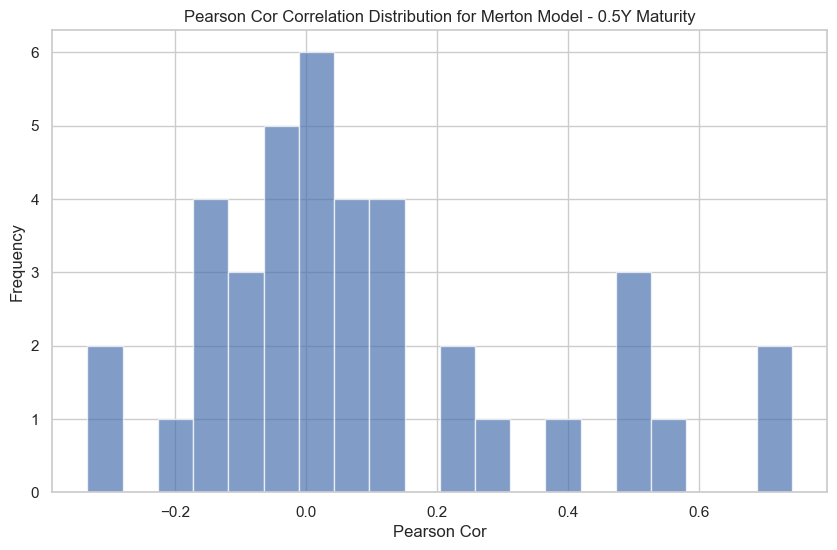

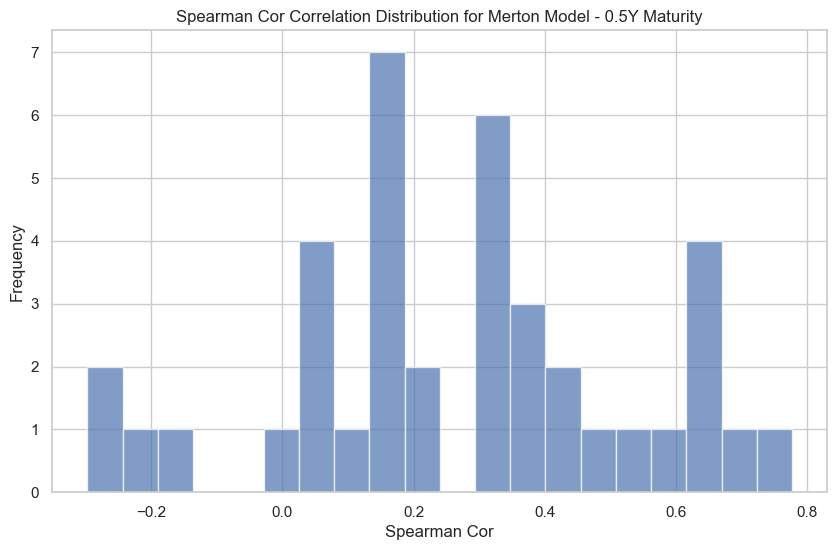

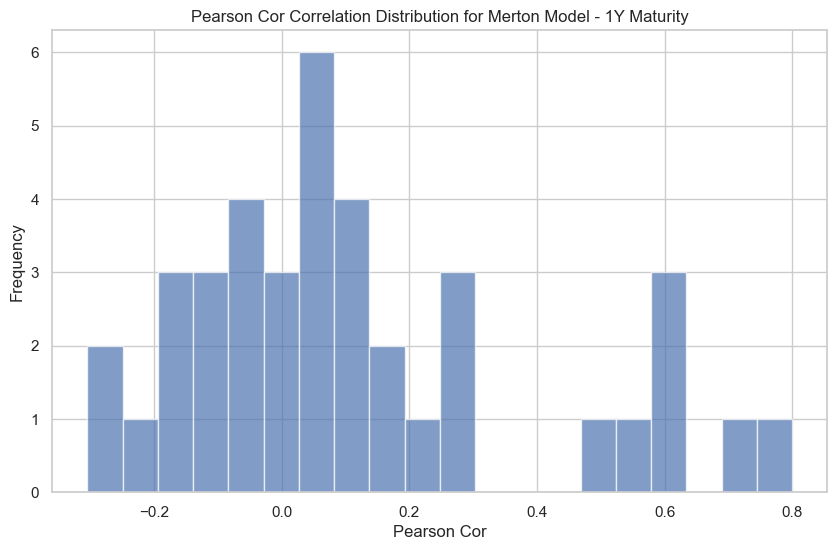

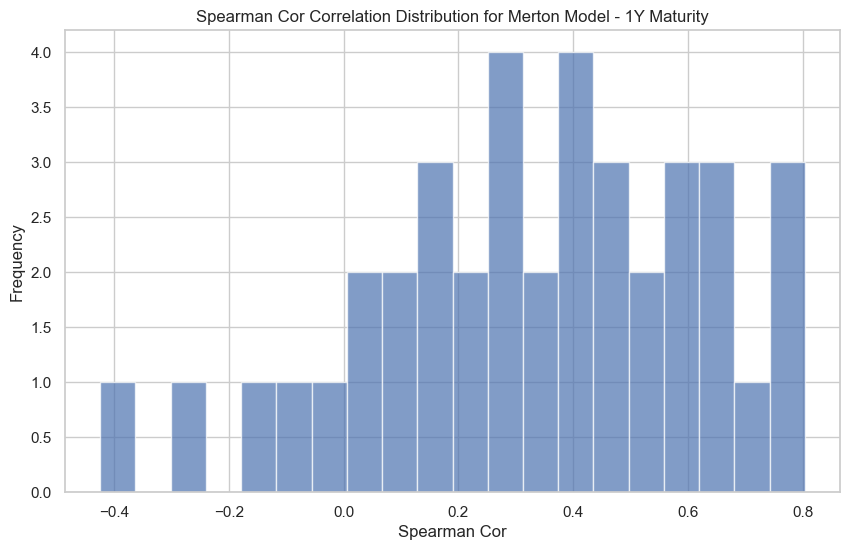

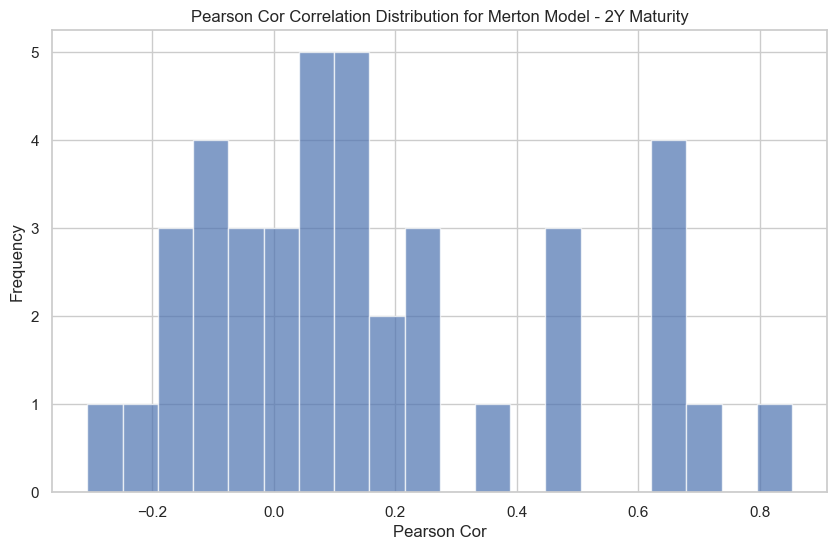

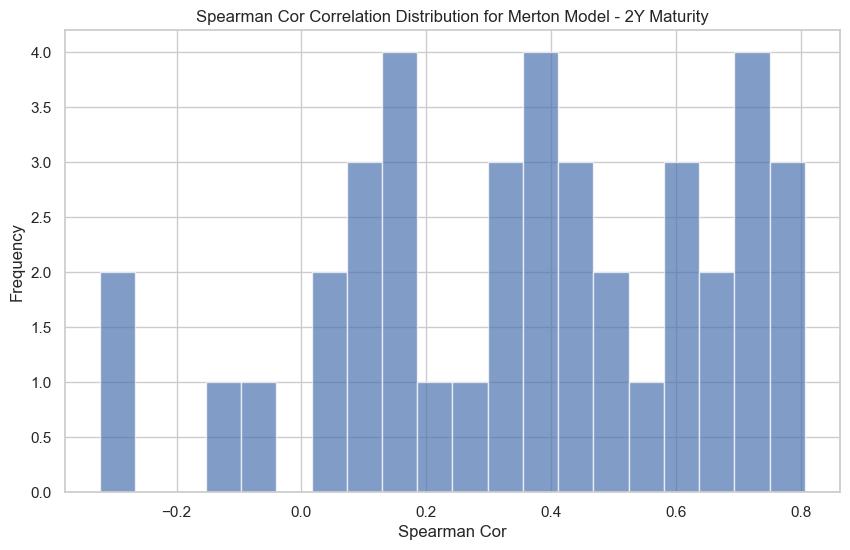

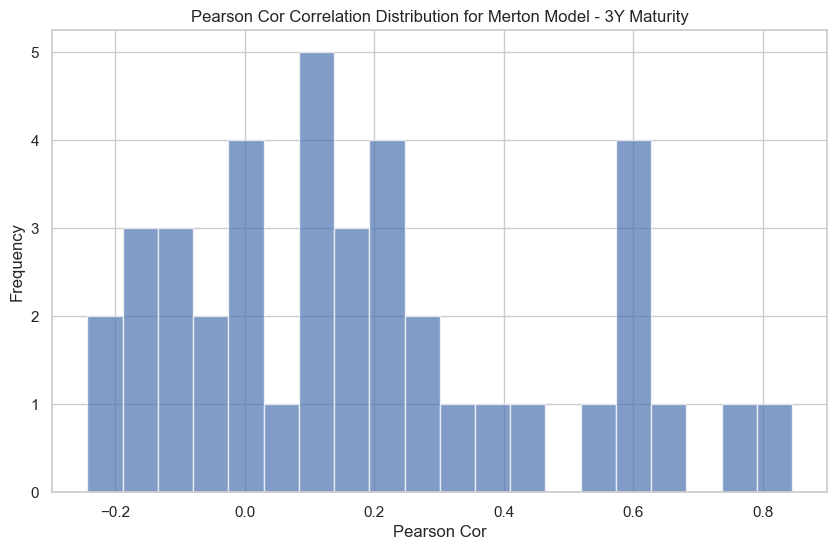

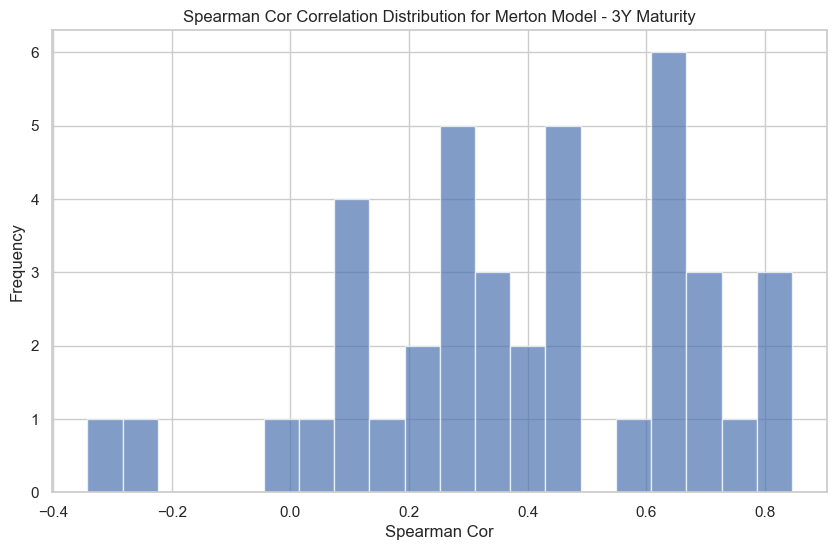

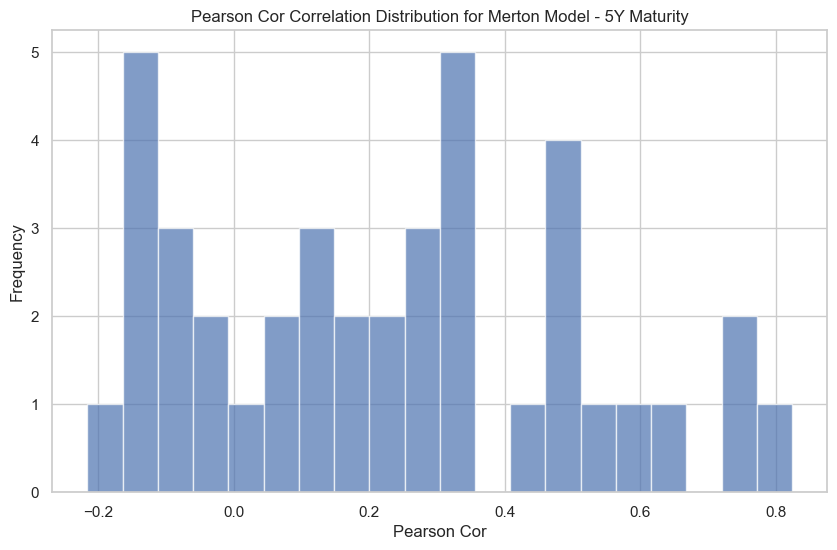

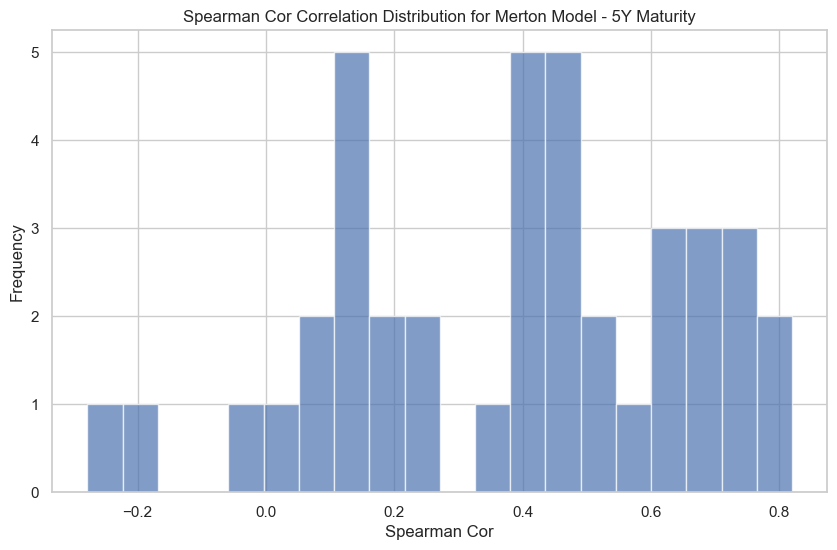

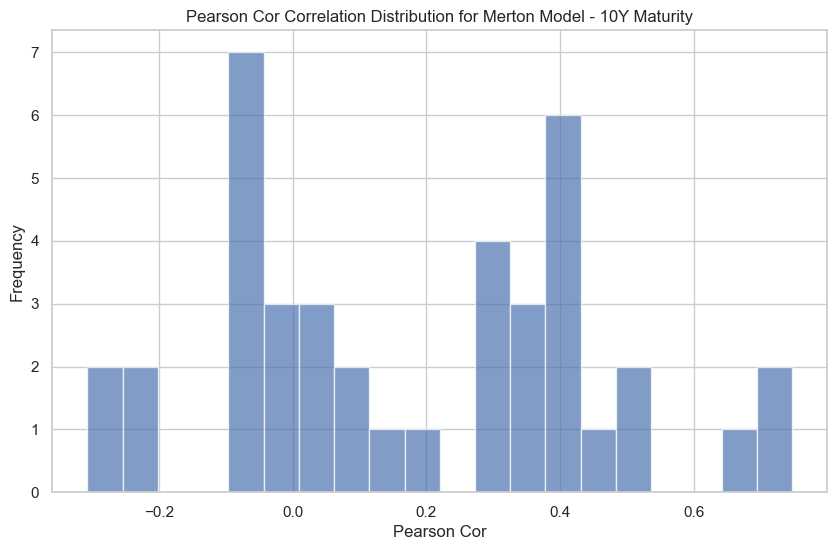

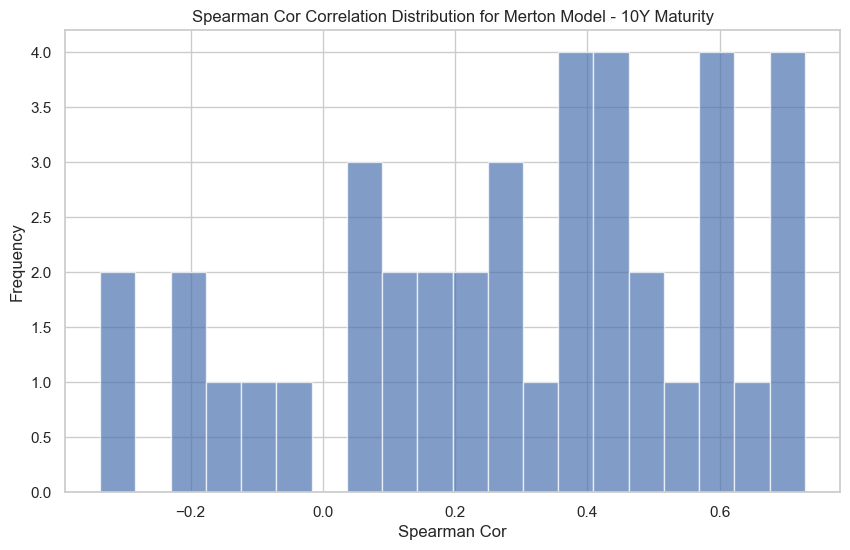

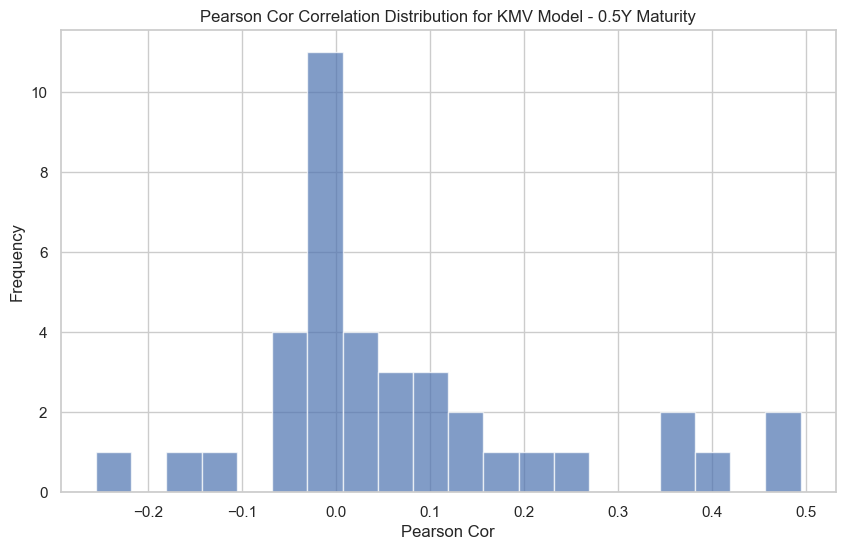

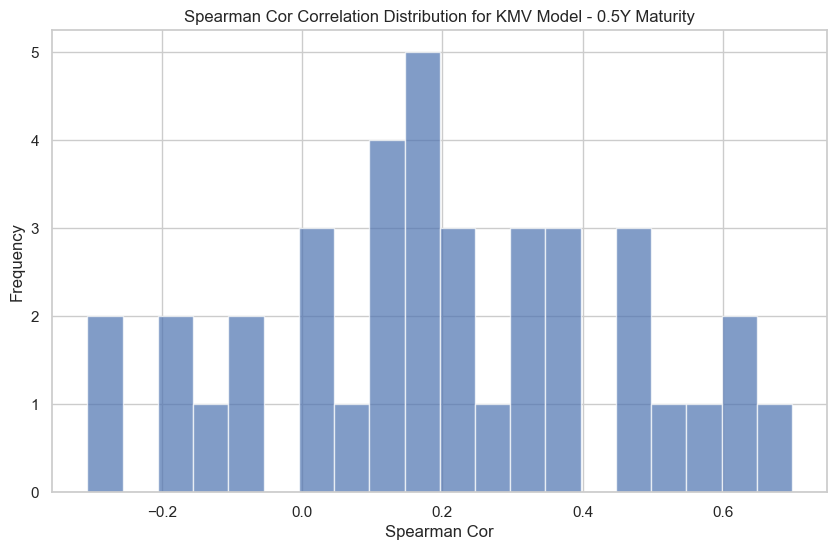

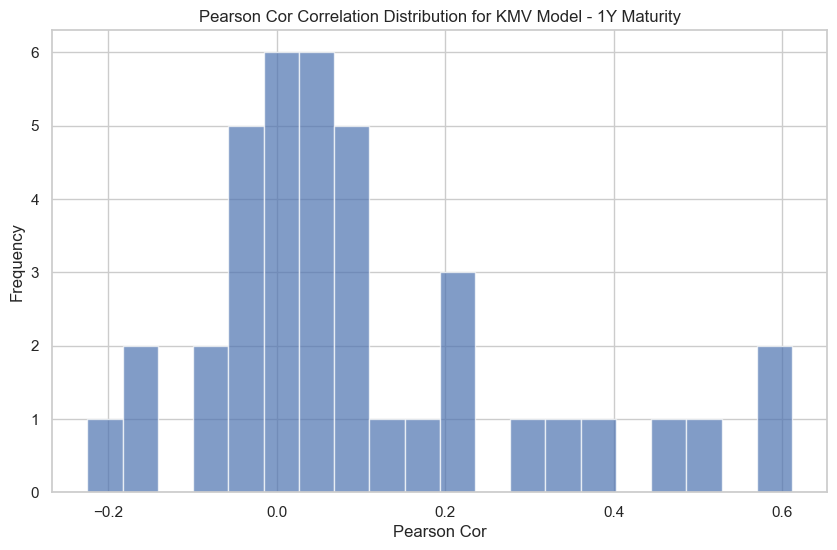

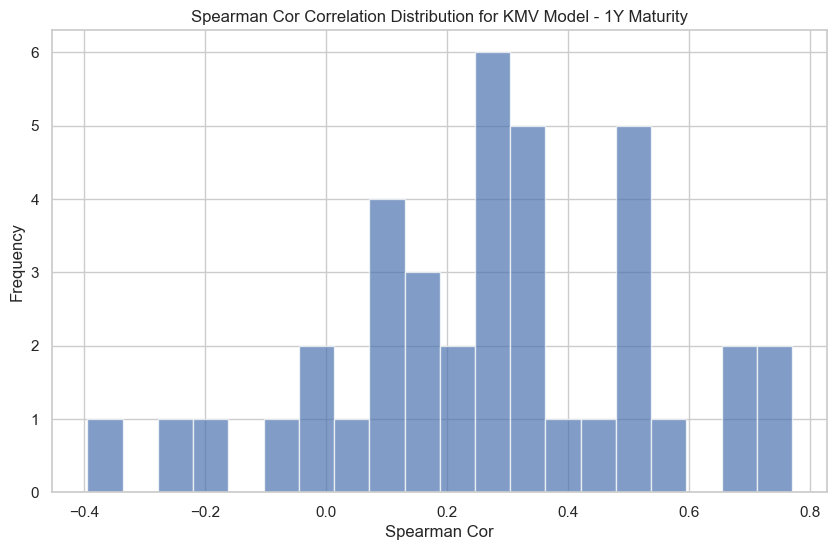

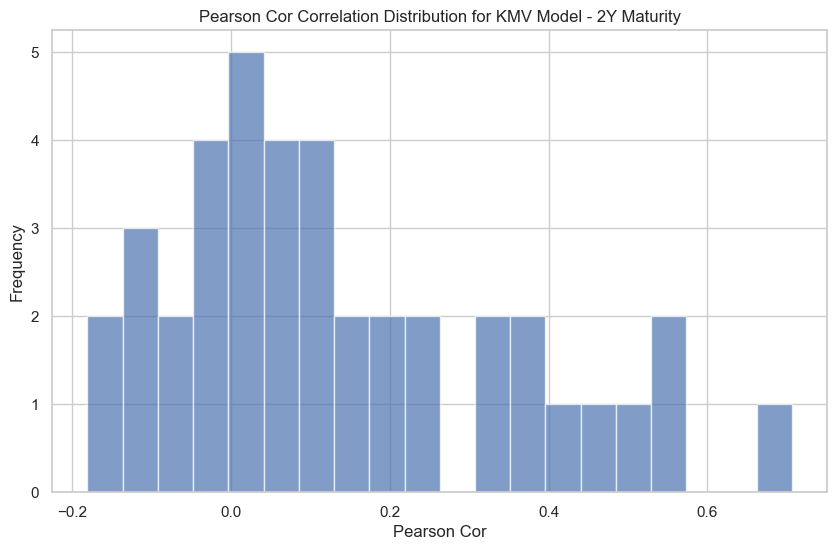

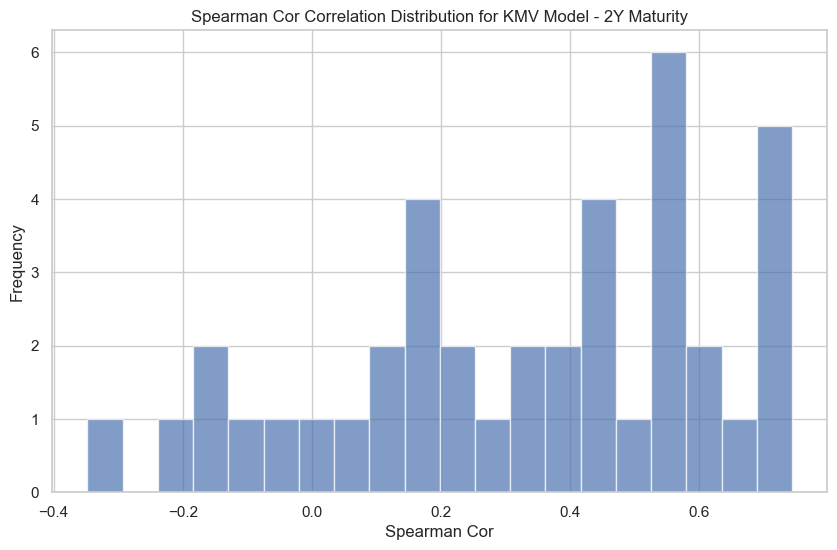

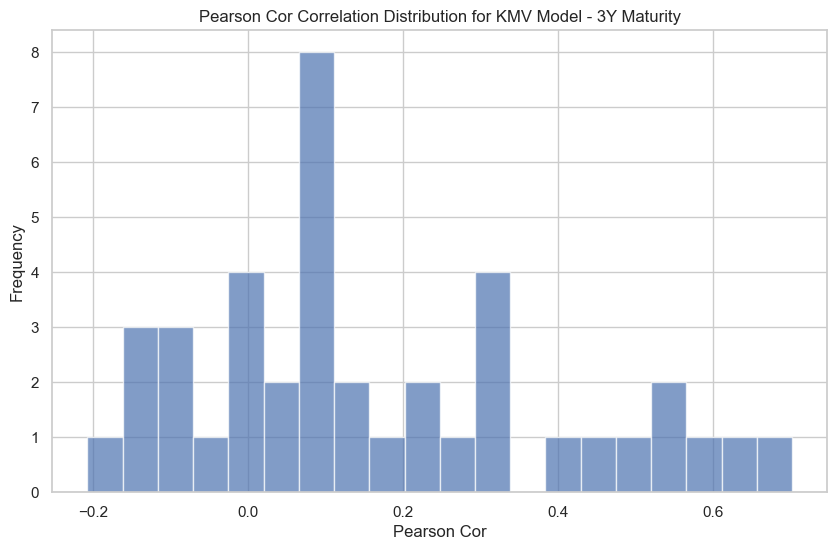

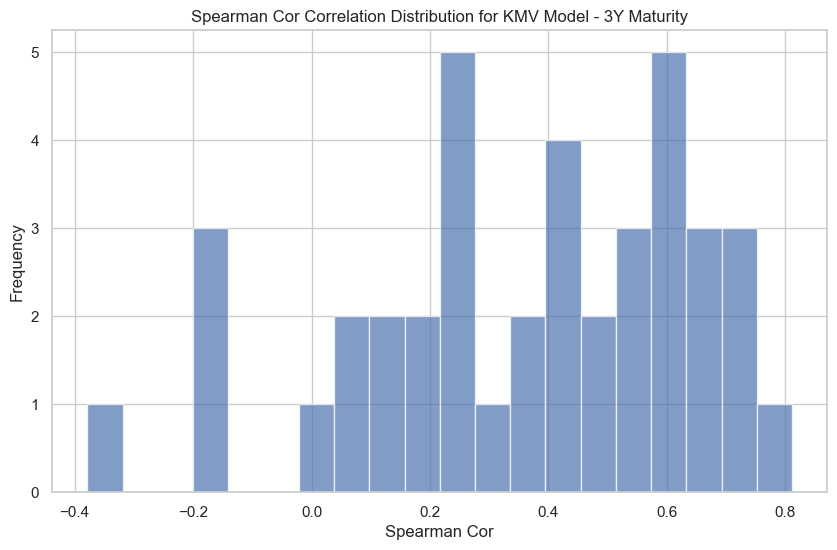

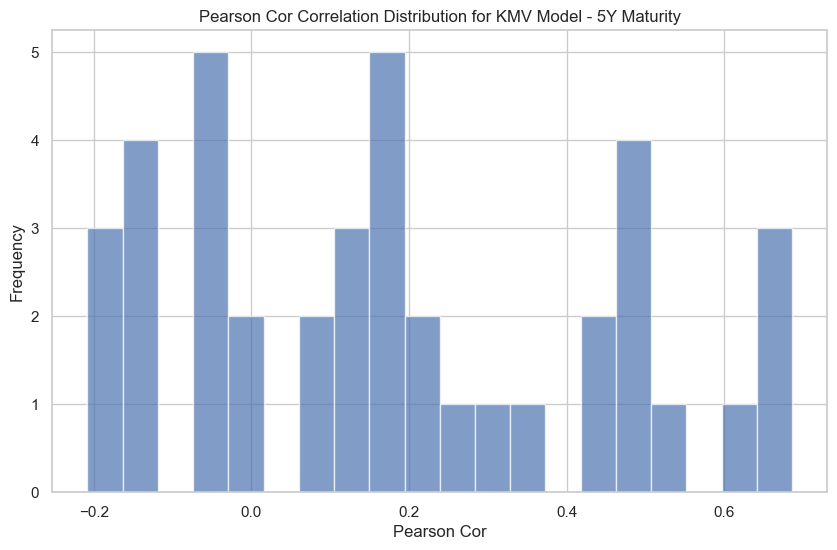

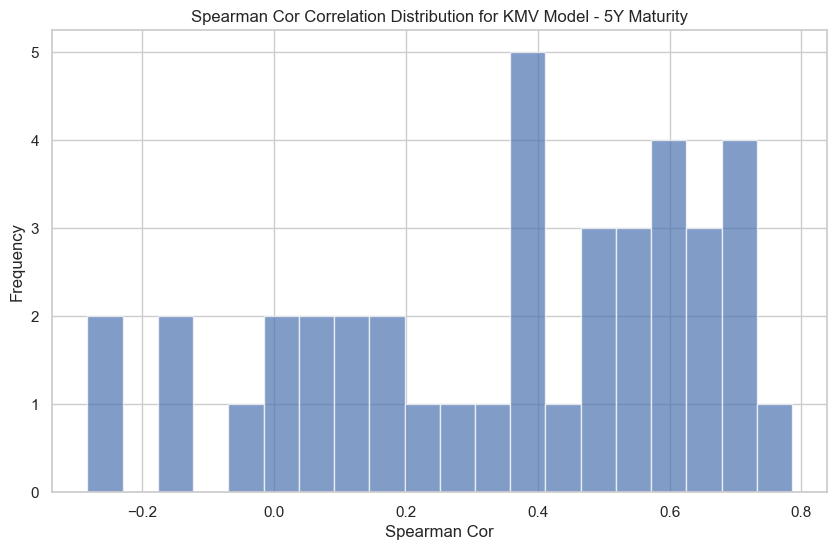

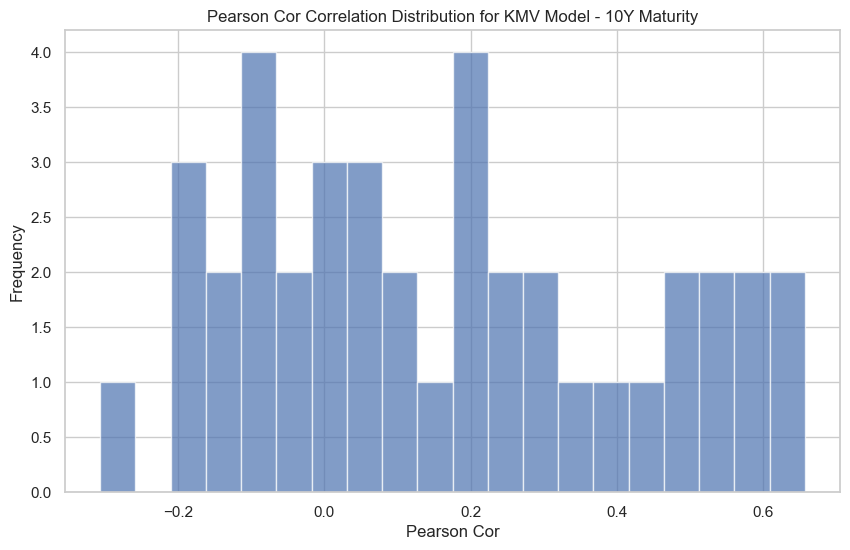

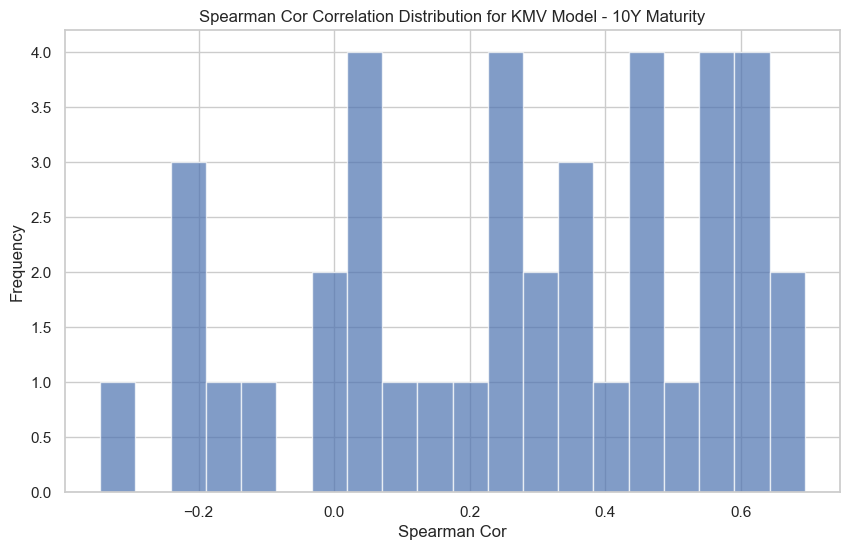

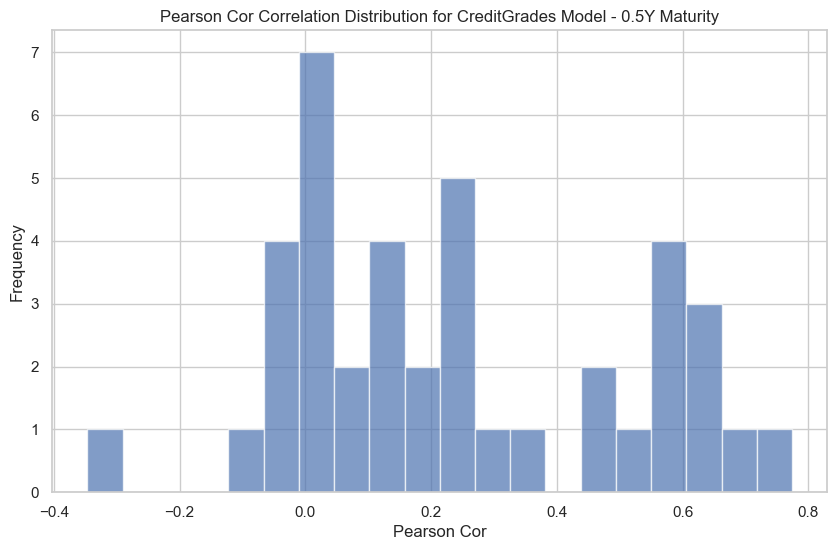

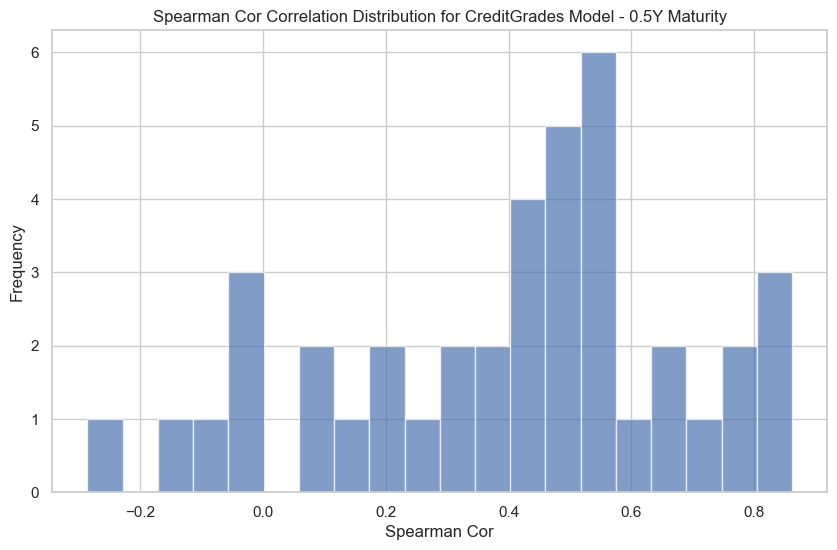

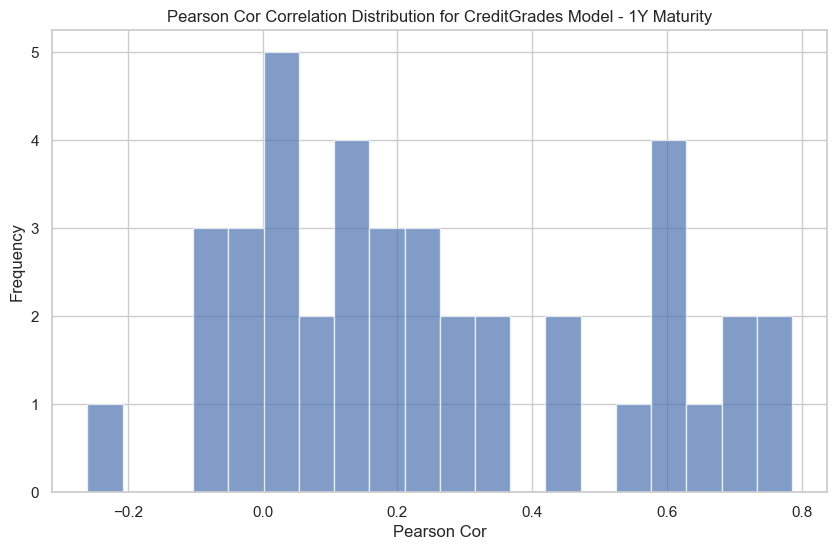

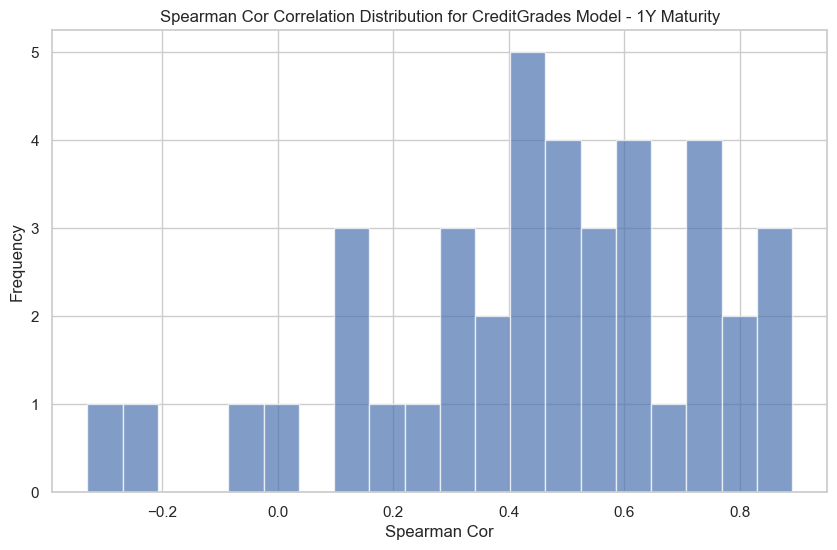

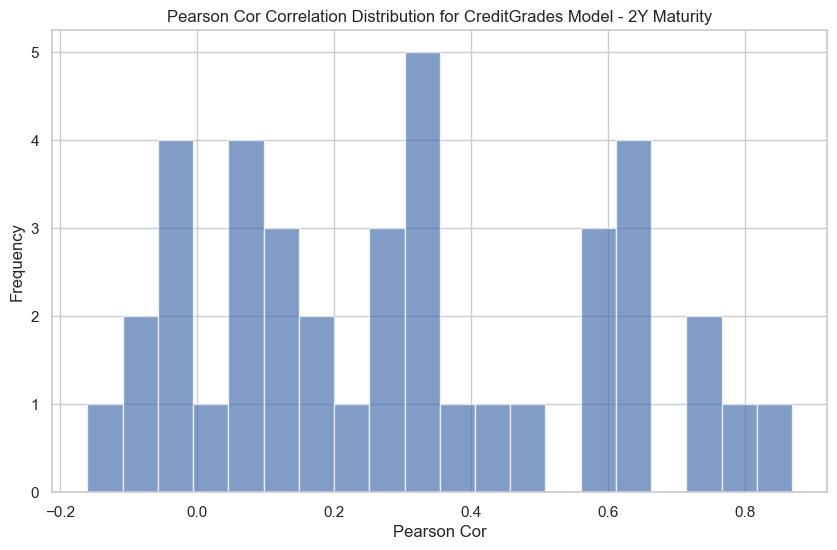

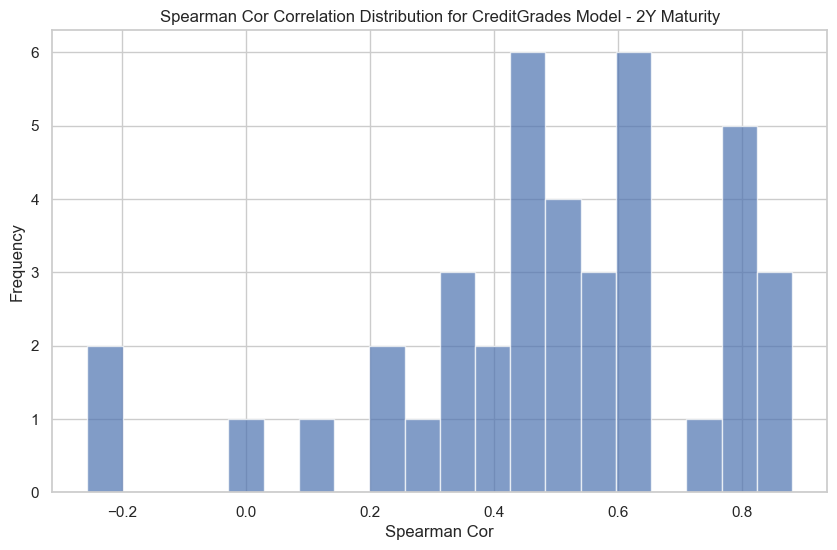

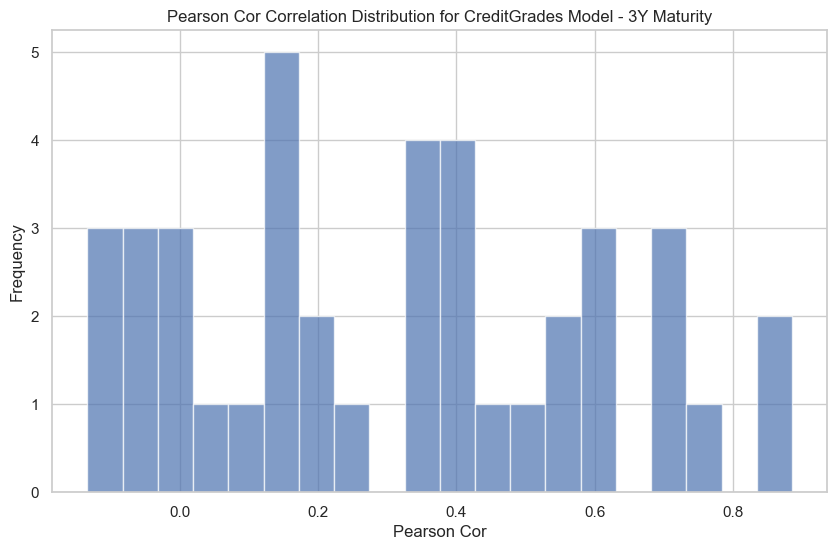

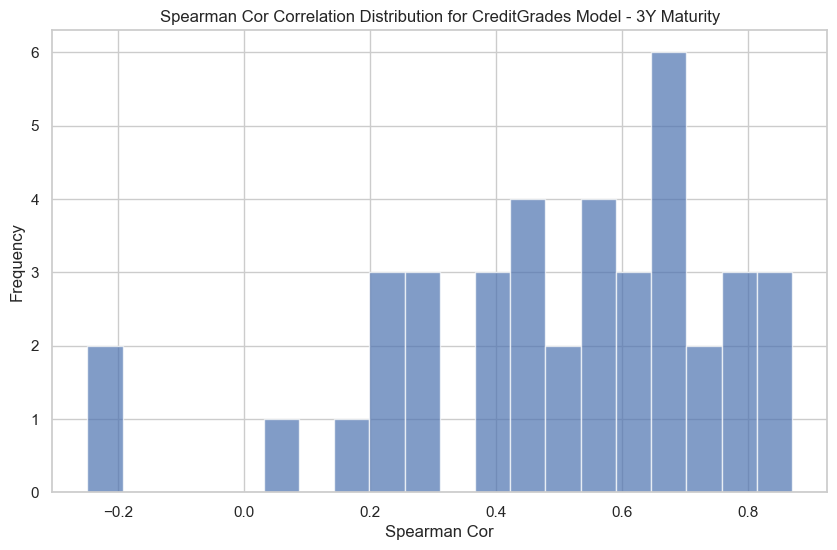

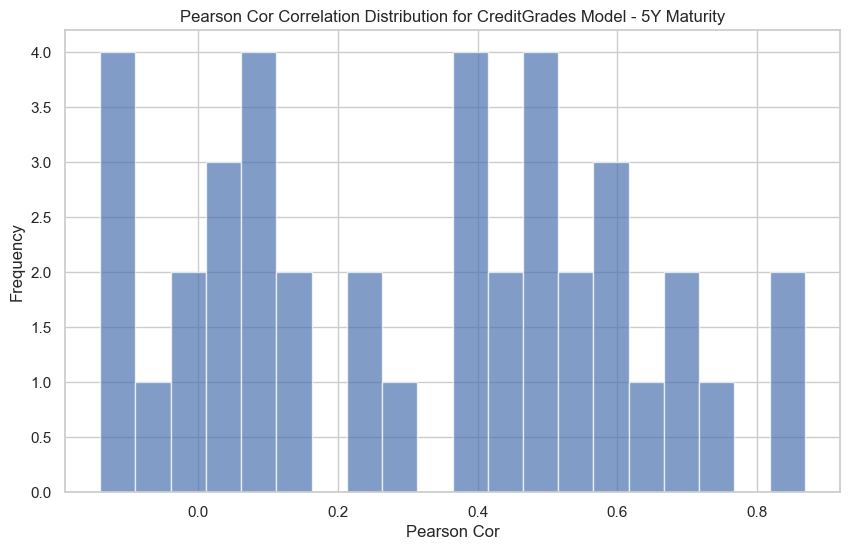

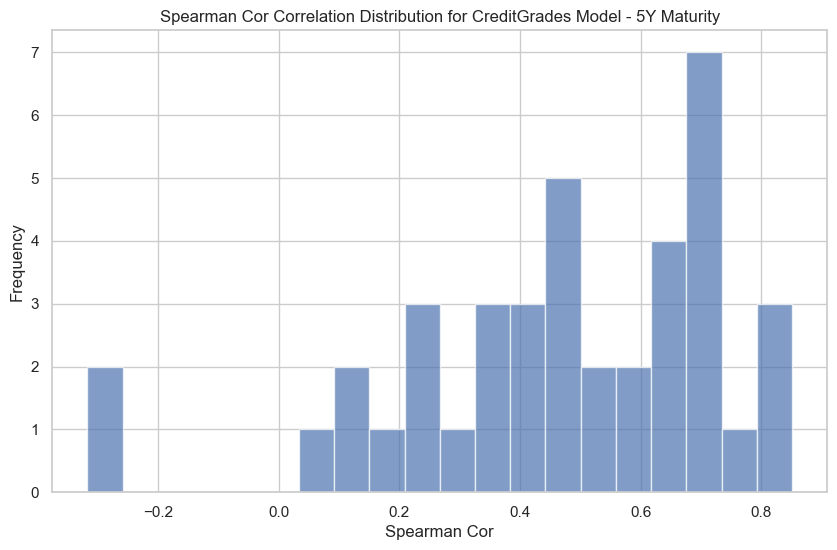

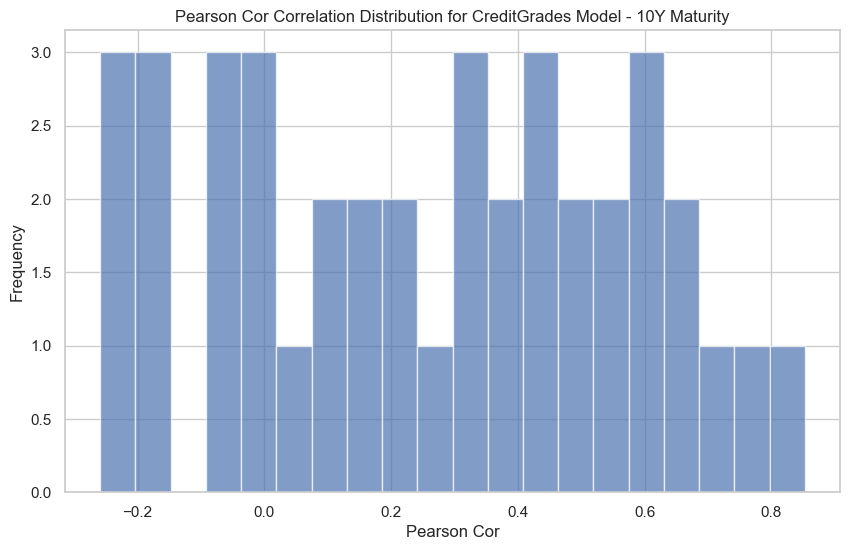

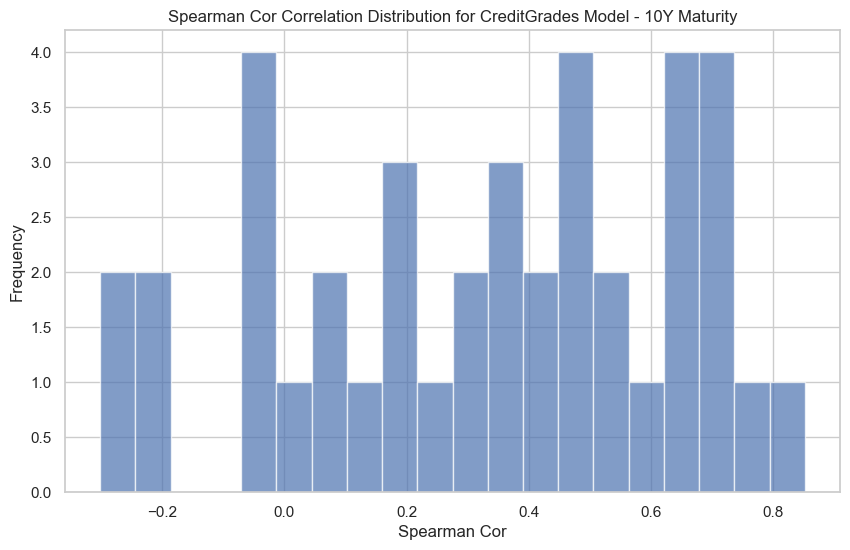

In [509]:
import matplotlib.pyplot as plt

# List of maturities and models
maturities_lst = ['0.5Y', '1Y', '2Y', '3Y', '5Y', '10Y']
models = ['Merton', 'KMV', 'CreditGrades']

# Define a function to plot histograms
def plot_histograms(data_dict, correlation_type, model, maturity):
    plt.figure(figsize=(10, 6))
    plt.hist(data_dict[maturity][correlation_type], bins=20, alpha=0.7)
    plt.title(f'{correlation_type} Correlation Distribution for {model} Model - {maturity} Maturity')
    plt.xlabel(correlation_type)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Iterate over models and maturities and plot histograms
for model in models:
    for maturity in maturities_lst:
        # Assuming your data is stored in dictionaries like Merton_results_dict, KMV_results_dict, etc.
        data_dict = eval(f'{model}_results_dict')  # Get the appropriate dictionary for the model

        # Plot histograms for Pearson and Spearman Correlations
        plot_histograms(data_dict, 'Pearson Cor', model, maturity)
        plot_histograms(data_dict, 'Spearman Cor', model, maturity)


In [511]:
Merton_results_summary = pd.DataFrame()
KMV_results_summary = pd.DataFrame()
CreditGrades_results_summary = pd.DataFrame()

maturities_lst = ['0.5Y', '1Y', '2Y', '3Y', '5Y', '10Y']
for i in range(len(maturities_lst)):
    maturity = maturities_lst[i]
    
    # Merton
    Pearson_cor_median = Merton_results_dict[maturity]['Pearson Cor'].median()
    Spearman_cor_median = Merton_results_dict[maturity]['Spearman Cor'].median()
    
    reg_beta_median = Merton_results_dict[maturity]['Beta of Implied Spread'].median()
    reg_p_value_median = Merton_results_dict[maturity]['p-value (coef of implied spread)'].median()
    
    if 'NA' in list(Merton_results_dict[maturity]['Dickey Fuller test p_value']):
        DF_test_p_value_median = 'NA'
    else:
        DF_test_p_value_median = Merton_results_dict[maturity]['Dickey Fuller test p_value'].median()
    
    row = pd.DataFrame({'Maturity':[maturity],\
                        'Median of Pearson cor' : [Pearson_cor_median],\
                        'Median of Spearman cor':[Spearman_cor_median],
                        'Median of (Implied Spread) coef':[reg_beta_median], \
                        'Median of p_value of (Implied Spread) coef':[reg_p_value_median],
                       'Median of p_value of Dickey Fuller test': [DF_test_p_value_median]})
    Merton_results_summary = pd.concat([Merton_results_summary, row], ignore_index=True)
    
    # KMV
    Pearson_cor_median = KMV_results_dict[maturity]['Pearson Cor'].median()
    Spearman_cor_median = KMV_results_dict[maturity]['Spearman Cor'].median()
    
    reg_beta_median = KMV_results_dict[maturity]['Beta of Implied Spread'].median()
    reg_p_value_median = KMV_results_dict[maturity]['p-value (coef of implied spread)'].median()
    
    if 'NA' in list(KMV_results_dict[maturity]['Dickey Fuller test p_value']):
        DF_test_p_value_median = 'NA'
    else:
        DF_test_p_value_median = KMV_results_dict[maturity]['Dickey Fuller test p_value'].median()
    
    row = pd.DataFrame({'Maturity':[maturity],\
                        'Median of Pearson cor' : [Pearson_cor_median],\
                        'Median of Spearman cor':[Spearman_cor_median],
                        'Median of (Implied Spread) coef':[reg_beta_median], \
                        'Median of p_value of (Implied Spread) coef':[reg_p_value_median],
                       'Median of p_value of Dickey Fuller test': [DF_test_p_value_median]})
    KMV_results_summary = pd.concat([KMV_results_summary, row], ignore_index=True)
    
    # Credit Grades
    Pearson_cor_median = CreditGrades_results_dict[maturity]['Pearson Cor'].median()
    Spearman_cor_median = CreditGrades_results_dict[maturity]['Spearman Cor'].median()
    
    reg_beta_median = CreditGrades_results_dict[maturity]['Beta of Implied Spread'].median()
    reg_p_value_median = CreditGrades_results_dict[maturity]['p-value (coef of implied spread)'].median()
    if 'NA' in list(CreditGrades_results_dict[maturity]['Dickey Fuller test p_value']):
        DF_test_p_value_median = 'NA'
    else:
        DF_test_p_value_median = CreditGrades_results_dict[maturity]['Dickey Fuller test p_value'].median()
    
    row = pd.DataFrame({'Maturity':[maturity],\
                        'Median of Pearson cor' : [Pearson_cor_median],\
                        'Median of Spearman cor':[Spearman_cor_median],
                        'Median of (Implied Spread) coef':[reg_beta_median], \
                        'Median of p_value of (Implied Spread) coef':[reg_p_value_median],
                       'Median of p_value of Dickey Fuller test': [DF_test_p_value_median]})
    CreditGrades_results_summary = pd.concat([CreditGrades_results_summary, row], ignore_index=True)



In [512]:
print('Merton')
display(Merton_results_summary)

print('KMV')
display(KMV_results_summary)

print('CreditGrades')
display(CreditGrades_results_summary)

Merton


,Maturity,Median of Pearson cor,Median of Spearman cor,Median of (Implied Spread) coef,Median of p_value of (Implied Spread) coef,Median of p_value of Dickey Fuller test
0,0.5Y,0.024946,0.316578,0.003907,0.162963,NA
1,1Y,0.038185,0.373217,0.032854,0.114618,NA
2,2Y,0.102003,0.396312,0.051865,0.088171,NA
3,3Y,0.146755,0.408753,0.067846,0.072224,NA
4,5Y,0.209076,0.429953,0.079690,0.016294,NA
5,10Y,0.161238,0.348776,0.031642,0.001476,NA


KMV


,Maturity,Median of Pearson cor,Median of Spearman cor,Median of (Implied Spread) coef,Median of p_value of (Implied Spread) coef,Median of p_value of Dickey Fuller test
0,0.5Y,0.017080,0.194018,0.000944,0.552280,NA
1,1Y,0.047944,0.269786,0.041196,0.377689,NA
2,2Y,0.073864,0.389780,0.117032,0.239121,NA
3,3Y,0.103504,0.425063,0.160285,0.162288,NA
4,5Y,0.162106,0.405654,0.127202,0.046073,NA
5,10Y,0.126677,0.290488,0.051147,0.023905,NA


CreditGrades


,Maturity,Median of Pearson cor,Median of Spearman cor,Median of (Implied Spread) coef,Median of p_value of (Implied Spread) coef,Median of p_value of Dickey Fuller test
0,0.5Y,0.199914,0.451824,0.417179,0.013814,NA
1,1Y,0.205441,0.501960,0.389649,0.015655,NA
2,2Y,0.289732,0.497155,0.247322,0.000796,0.136388
3,3Y,0.341095,0.552609,0.213461,0.000063,0.156889
4,5Y,0.386167,0.484007,0.140876,0.000005,0.227896
5,10Y,0.296992,0.368029,0.062289,0.000586,0.24063


# Trading Srategy

Check if default happens

In [296]:
def detect_default(DE_threshold = 2, dict_ = full_dict):
    ticker_lst = list(full_dict.keys())
    all_default_dict = {}
    for ticker in ticker_lst:
        ticker_df = full_dict[ticker][1]
        ticker_default_info = pd.DataFrame()
        for i, row in ticker_df.iterrows():
            long_short_debt = row['SHORT_AND_LONG_TERM_DEBT'] if (not np.isnan(row['SHORT_AND_LONG_TERM_DEBT'])) else 0
            cur_liab = row['BS_CUR_LIAB'] if (not np.isnan(row['BS_CUR_LIAB'])) else 0
            non_cur_liab = row['NON_CUR_LIAB'] if (not np.isnan(row['NON_CUR_LIAB'])) else 0
            equity = row['TOTAL_EQUITY'] if (not np.isnan(row['TOTAL_EQUITY'])) else 0
            debt = long_short_debt + 0.5*(cur_liab + non_cur_liab)
            debt = long_short_debt
            if debt == 0:
                default = False
            else:
                if equity == 0:
                    default = False
                else:
                    DE_ratio = debt/equity
                    if DE_ratio > DE_threshold:
                        default = True
                    else:
                        default = False
            row = pd.DataFrame({'Date':[row['Dates']], 'Default_occured':[default]})
            ticker_default_info = pd.concat([ticker_default_info, row], ignore_index = True)
        all_default_dict[ticker] = ticker_default_info
        

            

    return all_default_dict 

def present_value_of_cds(time_horizon, spread, discount_rate = 0.04):
    """
    Calculate the present value of CDS cashflows if no default happens.

    :param time_horizon: Total time in years (can be fractional)
    :param spread: CDS spread in basis points
    :param discount_rate: Annual discount rate (as a decimal)
    :return: Present value of the CDS cashflows
    """
    total_quarters = int(time_horizon * 4)
    quarterly_spread = spread / 10000 / 4  # Convert basis points to decimal and divide by 4
    quarterly_payment = quarterly_spread

    present_value = 0
    for quarter in range(1, total_quarters + 1):
        discounted_payment = quarterly_payment / ((1 + discount_rate/4) ** quarter)
        present_value += discounted_payment

    return present_value


        
def to_14th_next_month(date):
    # Set the day to 14th of the current month
    new_date = date.replace(day=14)
    # Add one month
    if new_date.month == 12:
        new_date = new_date.replace(year=new_date.year + 1, month=1)
    else:
        new_date = new_date.replace(month=new_date.month + 1)
    return new_date            

def examine_deviations(df, now_df, time_horizon, deviation=1.5):
    # Calculate error as the difference between the second and third columns
    error = df.iloc[:, 1] - df.iloc[:, 2]

    # Calculate the expected error (mean of the errors)
    expected_error = error.mean()

    # Calculate the standard deviation of the errors
    error_std_dev = error.std()

    # Calculate the error for now_df (assuming now_df has the same structure as df)
    now_error = now_df.iloc[0, 1] - now_df.iloc[0, 2]

    # Determine the action based on the deviation criteria
    upper_bound = expected_error + deviation * error_std_dev
    lower_bound = expected_error - deviation * error_std_dev

    if now_error > upper_bound:
        action = 'Short'
    elif now_error < lower_bound:
        action = 'Long'
    else:
        action = 'No action'

    return action, expected_error, error_std_dev

def calculate_cds_contracts(pv, rate, notional_amount):
    # Calculate the number of CDS contracts based on present value and rate
    return (pv / rate) / notional_amount

In [329]:
def strategy_implementation(df, time_horizon, pair_value=2, rate=0.8, recovery_rate=0.4):
    profit = 0
    months = int(time_horizon * 12)
    pnl_df = pd.DataFrame(index=df['Date'], columns=['CashFlow', 'PL'])
    pnl_df.fillna(0, inplace=True)
    long_count = 0
    short_count = 0

    for i in range(24, len(df) - months):
        testing_df = df.iloc[i-24:i]
        now_df = df.iloc[i: i + 1]
        holding_df = df.iloc[i + 1: i + months + 1]
        action, e_E, e_sd = examine_deviations(testing_df, now_df, time_horizon)
        now_date = now_df['Date'].iloc[0]
        now_price = now_df.iloc[0, 3]
        now_spread = now_df.iloc[0, 1]
        cds_pv = present_value_of_cds(time_horizon, spread=now_spread)
        num_cds_contracts = calculate_cds_contracts(pair_value * rate, cds_pv, 1)

        if action == 'No action':
#             print(now_date)
#             print('no action is taken')
              pass
        if action == 'Long':
            long_count += 1
            
            # Record stock purchase
            pnl_df.loc[now_date, 'CashFlow'] -= pair_value

            # Schedule CDS quarterly payments
            for quarter in range(1, months // 3 + 1):
                payment_date = now_date + pd.DateOffset(months=3 * quarter)
                if payment_date in holding_df['Date'].values:
                    if holding_df.loc[holding_df['Date'] == payment_date, 'Default_occured'].iloc[0]:
                        # Default occurs, close position
                        default_date = payment_date
                        recovery_payment = num_cds_contracts * (1 - recovery_rate)
                        pnl_df.loc[default_date, 'CashFlow'] += recovery_payment
                        break
                    else:
                        # No default, record CDS payment
                        pnl_df.loc[payment_date, 'CashFlow'] -= now_spread / 10000 / 4 * num_cds_contracts

            # Close position at the end of the holding period or at default
            close_date = default_date if 'default_date' in locals() else now_date + pd.DateOffset(months=months)
            if close_date in df['Date'].values:
                close_price = df.loc[df['Date'] == close_date, 'PX_LAST'].iloc[0]
                pnl_df.loc[close_date, 'CashFlow'] += pair_value * (close_price / now_price)
        if action == 'Short':
            short_count += 1

            # Record proceeds from stock short sale
            pnl_df.loc[now_date, 'CashFlow'] += pair_value

            # Schedule CDS quarterly payments and check for default
            for quarter in range(1, months // 3 + 1):
                payment_date = now_date + pd.DateOffset(months=3 * quarter)
                if payment_date in holding_df['Date'].values:
                    if holding_df.loc[holding_df['Date'] == payment_date, 'Default_occured'].iloc[0]:
                        # Default occurs, close position
                        default_date = payment_date
                        default_payment = num_cds_contracts * (1 - recovery_rate)
                        pnl_df.loc[default_date, 'CashFlow'] -= default_payment
                        break
                    else:
                        # No default, receive CDS payment
                        pnl_df.loc[payment_date, 'CashFlow'] += now_spread / 10000 / 4 * num_cds_contracts

            # Close position at the end of the holding period or at default
            close_date = default_date if 'default_date' in locals() else now_date + pd.DateOffset(months=months)
            if close_date in df['Date'].values:
                close_price = df.loc[df['Date'] == close_date, 'PX_LAST'].iloc[0]
                pnl_df.loc[close_date, 'CashFlow'] -= pair_value * (close_price / now_price)

        # Calculate cumulative P&L
        pnl_df['PL'] = pnl_df['CashFlow'].cumsum()
#     print(long_count)
#     print(short_count)

    return pnl_df
def trading_strategy(dic, default_dict, start_date = pd.to_datetime(start_date), end_date = pd.to_datetime(end_date)):
    ticker_lst = list(dic.keys())
    time_horizon_lst = [0.5, 1, 2, 3, 5, 10]
    model_name_lst = ['Merton', 'KMV', 'CreditGrades']

    # Initialize a nested dictionary to store the total P&L by model and maturity
    total_PL_by_model_and_maturity = {model: {th: pd.DataFrame() for th in time_horizon_lst} for model in model_name_lst}

    for ticker in ticker_lst: 
#         print(ticker)
        default_df = default_dict[ticker]
        default_df['Date'] = default_df['Date'].apply(to_14th_next_month)

        for model_index, model_name in enumerate(model_name_lst):
            model_IS_df = dic[ticker][model_index]

            # Process stock price data
            price = full_dict[ticker][1][['Dates', 'PX_LAST']]
            price = price.rename(columns={'Dates': 'Date'})
            price['PX_LAST'] = price['PX_LAST'].fillna(method='ffill').fillna(method='bfill')
            price['Date'] = price['Date'].apply(to_14th_next_month)
            model_IS_df = pd.merge(model_IS_df, price[['Date', 'PX_LAST']], on='Date', how='inner')
            model_IS_df = pd.merge(model_IS_df, default_df[['Date', 'Default_occured']], on='Date', how='inner')
            model_IS_df = model_IS_df[(model_IS_df['Date'] >= start_date) & (model_IS_df['Date'] <= end_date)]

            for time_horizon in time_horizon_lst:
                model_IS_sub_df = model_IS_df[['Date', model_IS_df.columns[model_index + 1], model_IS_df.columns[model_index + 25], 'PX_LAST', 'Default_occured']]
                pnl_result = strategy_implementation(model_IS_sub_df, time_horizon)
#                 print(pnl_result)

                # Sum up the P&L for each time horizon and model
                if total_PL_by_model_and_maturity[model_name][time_horizon].empty:
                    total_PL_by_model_and_maturity[model_name][time_horizon] = pnl_result
                else:
                    total_PL_by_model_and_maturity[model_name][time_horizon] = total_PL_by_model_and_maturity[model_name][time_horizon].add(pnl_result, fill_value=0)

    return total_PL_by_model_and_maturity

# Trading Strategy results analysis

In [334]:
start_date = '2010-01-01'
end_date = '2021-01-01'
default_dict = detect_default()  
total_PL_results = trading_strategy(IS_full_dict, default_dict)

#### Plot the PNL for each model seperately

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cumulative_pl(total_PL_results, maturities_lst, initial_asset_level=10000, start_date='2012-01-01'):
    """
    Plot the cumulative P&L with initial asset level added for each model, enhanced for better visual appeal.

    :param total_PL_results: Dictionary containing PnL results for different models and maturities.
    :param initial_asset_level: Initial asset level of the portfolio (default: 10000).
    :param start_date: The starting date for the plot (default: '2012-01-01').
    """
    sns.set(style="whitegrid")  # Set the Seaborn style
    colors = sns.color_palette("husl", len(maturities_lst))  # Generate a color palette

    for model, maturities in total_PL_results.items():
        plt.figure(figsize=(20, 9))
        for idx, maturity in enumerate(maturities_lst):
            df = total_PL_results[model][maturity]
            if not df.empty:
                df_filtered = df[df.index >= start_date]
                cumulative_pl_with_initial = df_filtered['PL'] + initial_asset_level
                plt.plot(cumulative_pl_with_initial.index, cumulative_pl_with_initial, label=f'{maturity} Maturity', color=colors[idx])

        plt.title(f'{model}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Cumulative P&L', fontsize=14)
        fontsize='large'
        plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1.05, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_cumulative_pl(total_PL_results, maturities_lst)


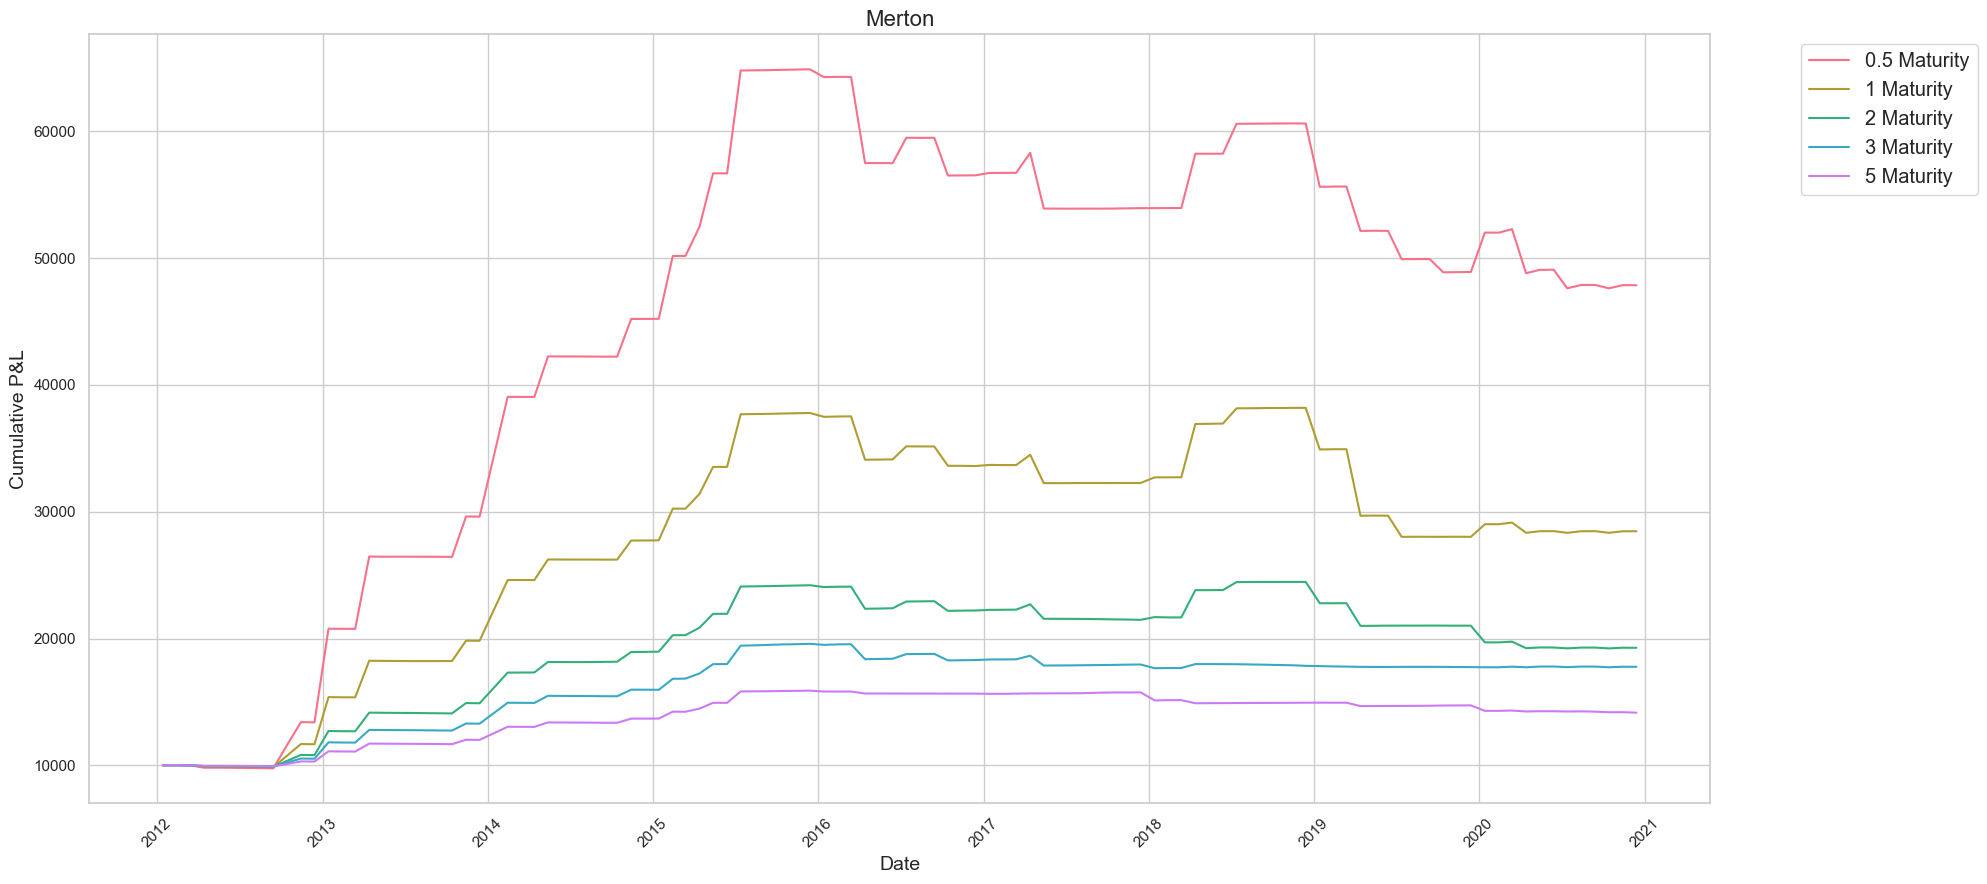

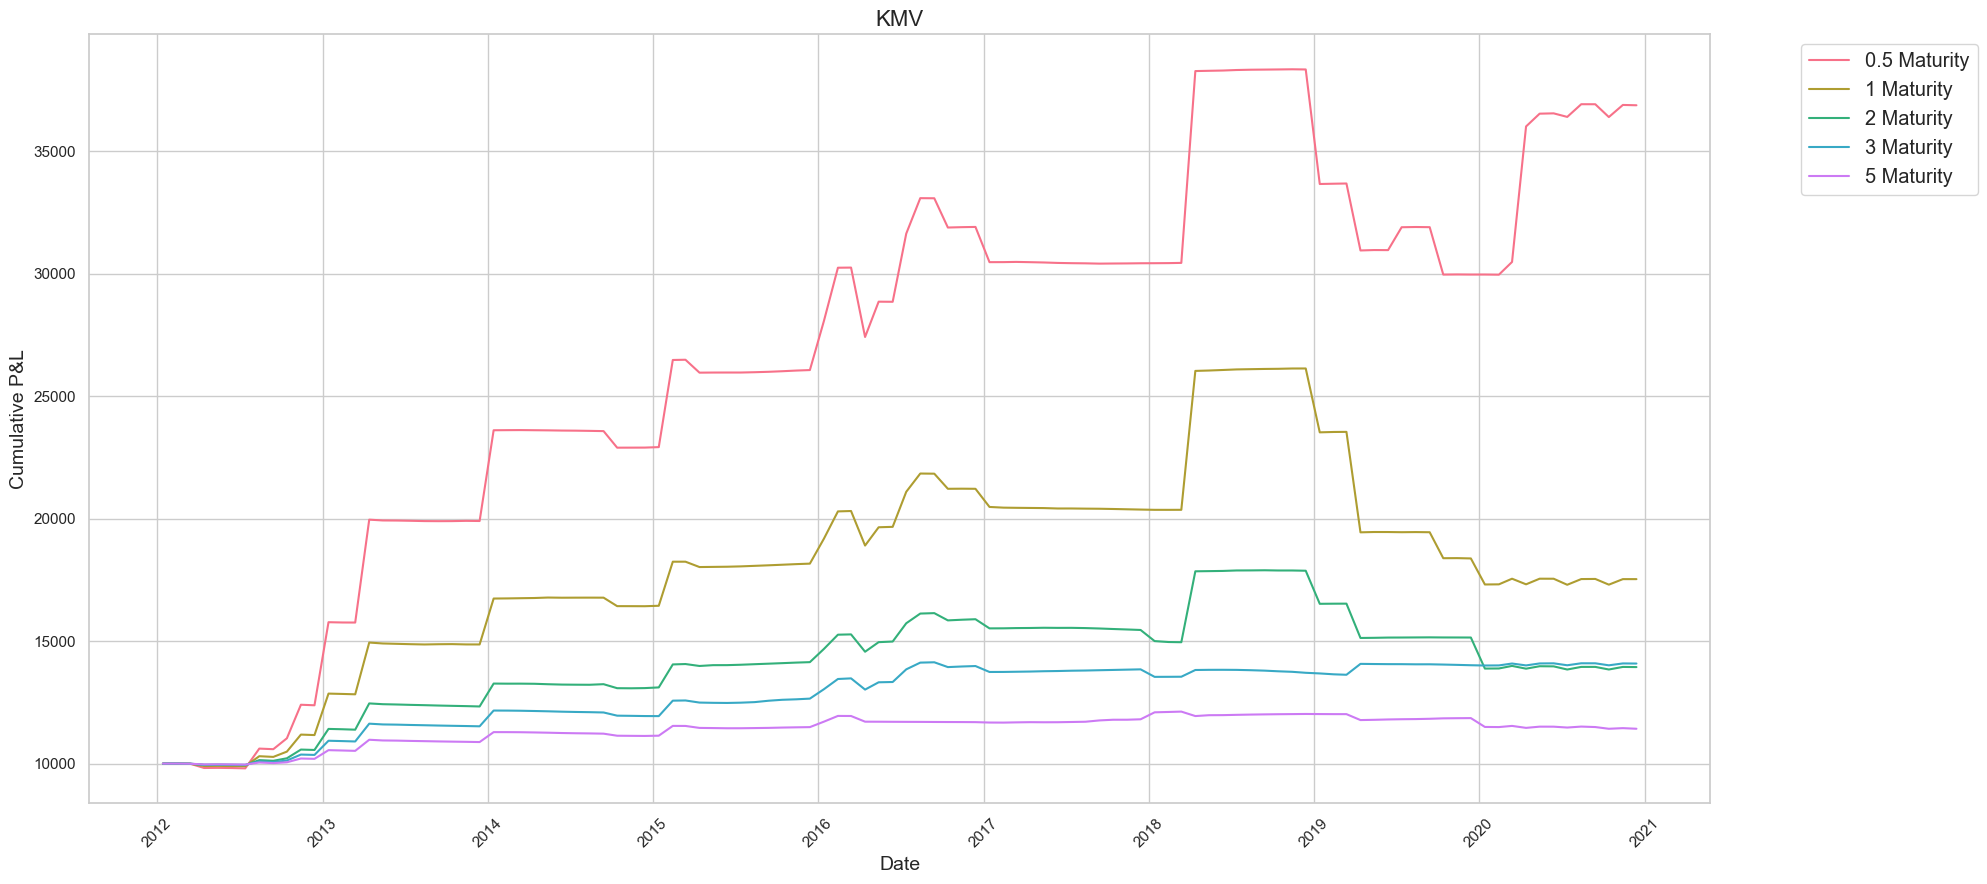

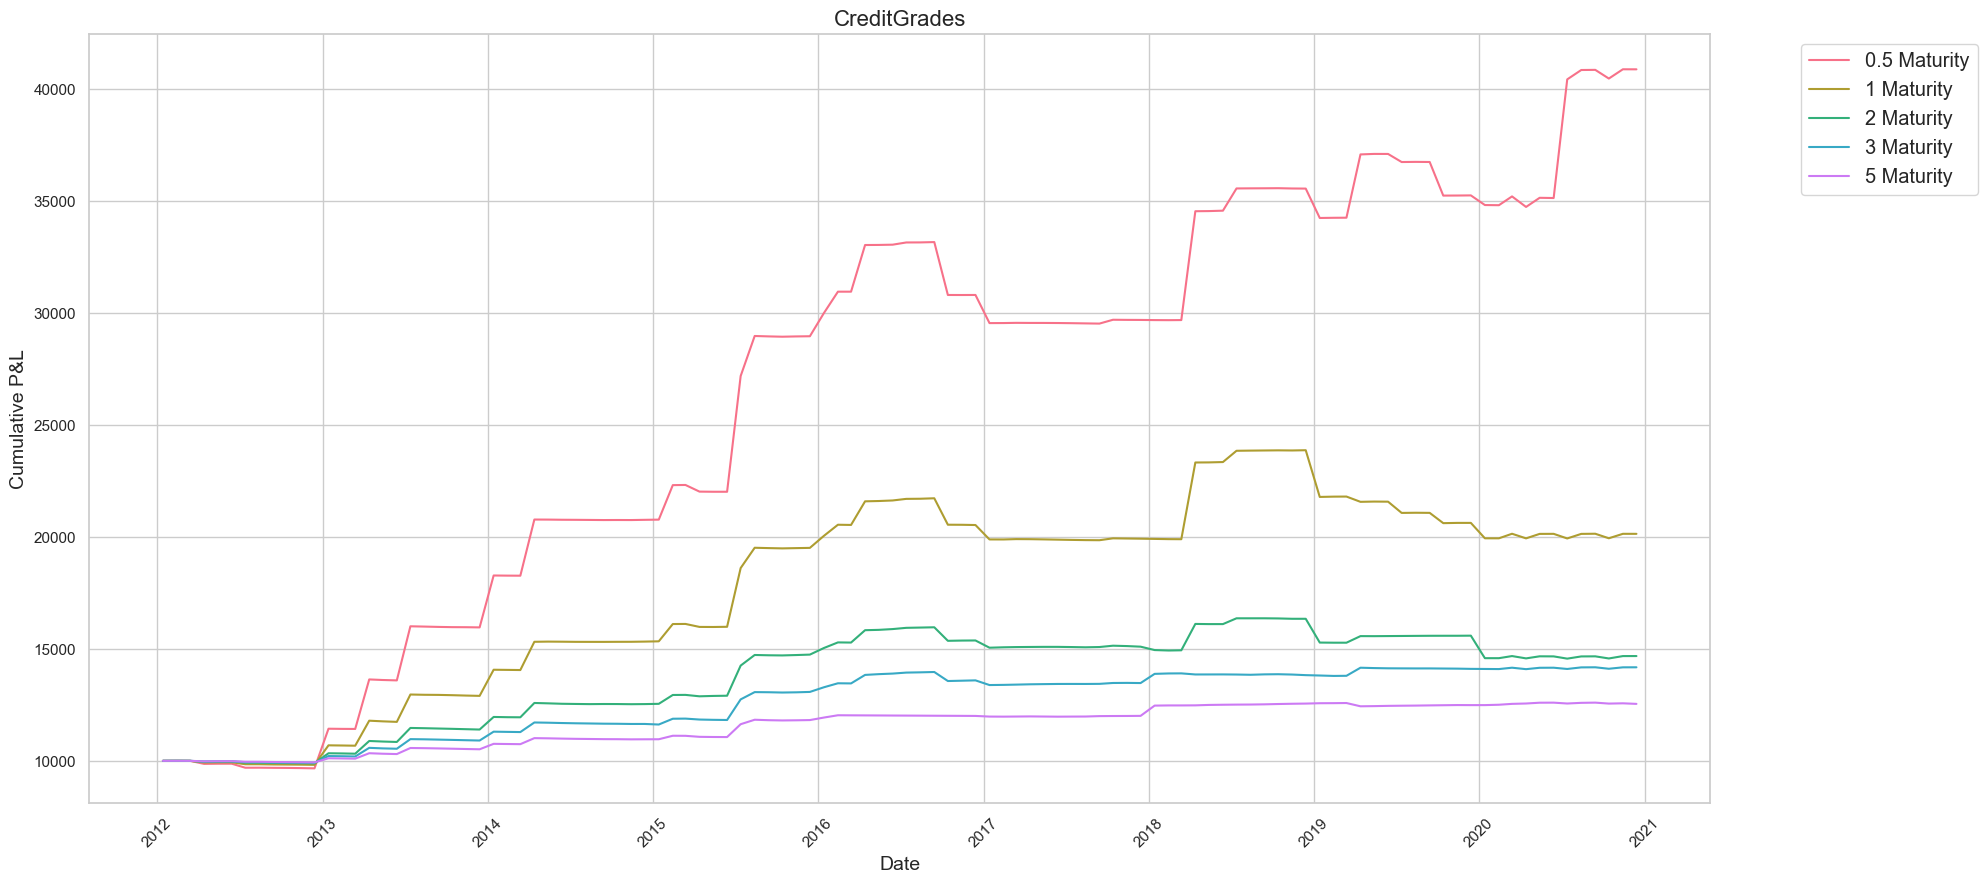

In [387]:
plot_cumulative_pl(total_PL_results, [0.5,1,2,3,5])

#### Fixed maturities, Plot the graphs for each model to compare model performance of a given maturity

In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_cumulative_pl(total_PL_results, maturities_lst, models_lst, initial_asset_level=10000, start_date='2012-01-01'):
    """
    Plot the cumulative P&L for each maturity across different models with larger graphs and distinct colors for each model.

    :param total_PL_results: Dictionary containing PnL results for different models and maturities.
    :param maturities_lst: List of maturities.
    :param models_lst: List of models.
    :param initial_asset_level: Initial asset level of the portfolio (default: 10000).
    :param start_date: The starting date for the plot (default: '2012-01-01').
    """
    sns.set(style="whitegrid")
    model_colors = sns.color_palette("husl", len(models_lst))

    for idx, maturity in enumerate(maturities_lst):
        plt.figure(figsize=(20, 9))  # Increased size of the plot
        for model_idx, model in enumerate(models_lst):
            df = total_PL_results.get(model, {}).get(maturity)
            if df is not None and not df.empty:
                # Ensure the index is in datetime format
                df.index = pd.to_datetime(df.index)
                df_filtered = df.loc[df.index >= pd.to_datetime(start_date)].copy()

                # Convert 'PL' to numeric and add the initial asset level
                df_filtered['PL'] = pd.to_numeric(df_filtered['PL'], errors='coerce')
                cumulative_pl_with_initial = df_filtered['PL'] + initial_asset_level

                plt.plot(cumulative_pl_with_initial.index, cumulative_pl_with_initial, label=f'{model} Model', color=model_colors[model_idx])

        plt.title(f'Cumulative P&L - {maturity} Maturity', fontsize=20)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Cumulative P&L', fontsize=18)
        plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1.05, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
# total_PL_results = { ... } # Your data here
# maturities_lst = [0.5, 1, 2, 3, 5]
# models_lst = ['Model1', 'Model2', 'Model3'] # Replace with your model names
# plot_cumulative_pl(total_PL_results, maturities_lst, models_lst)


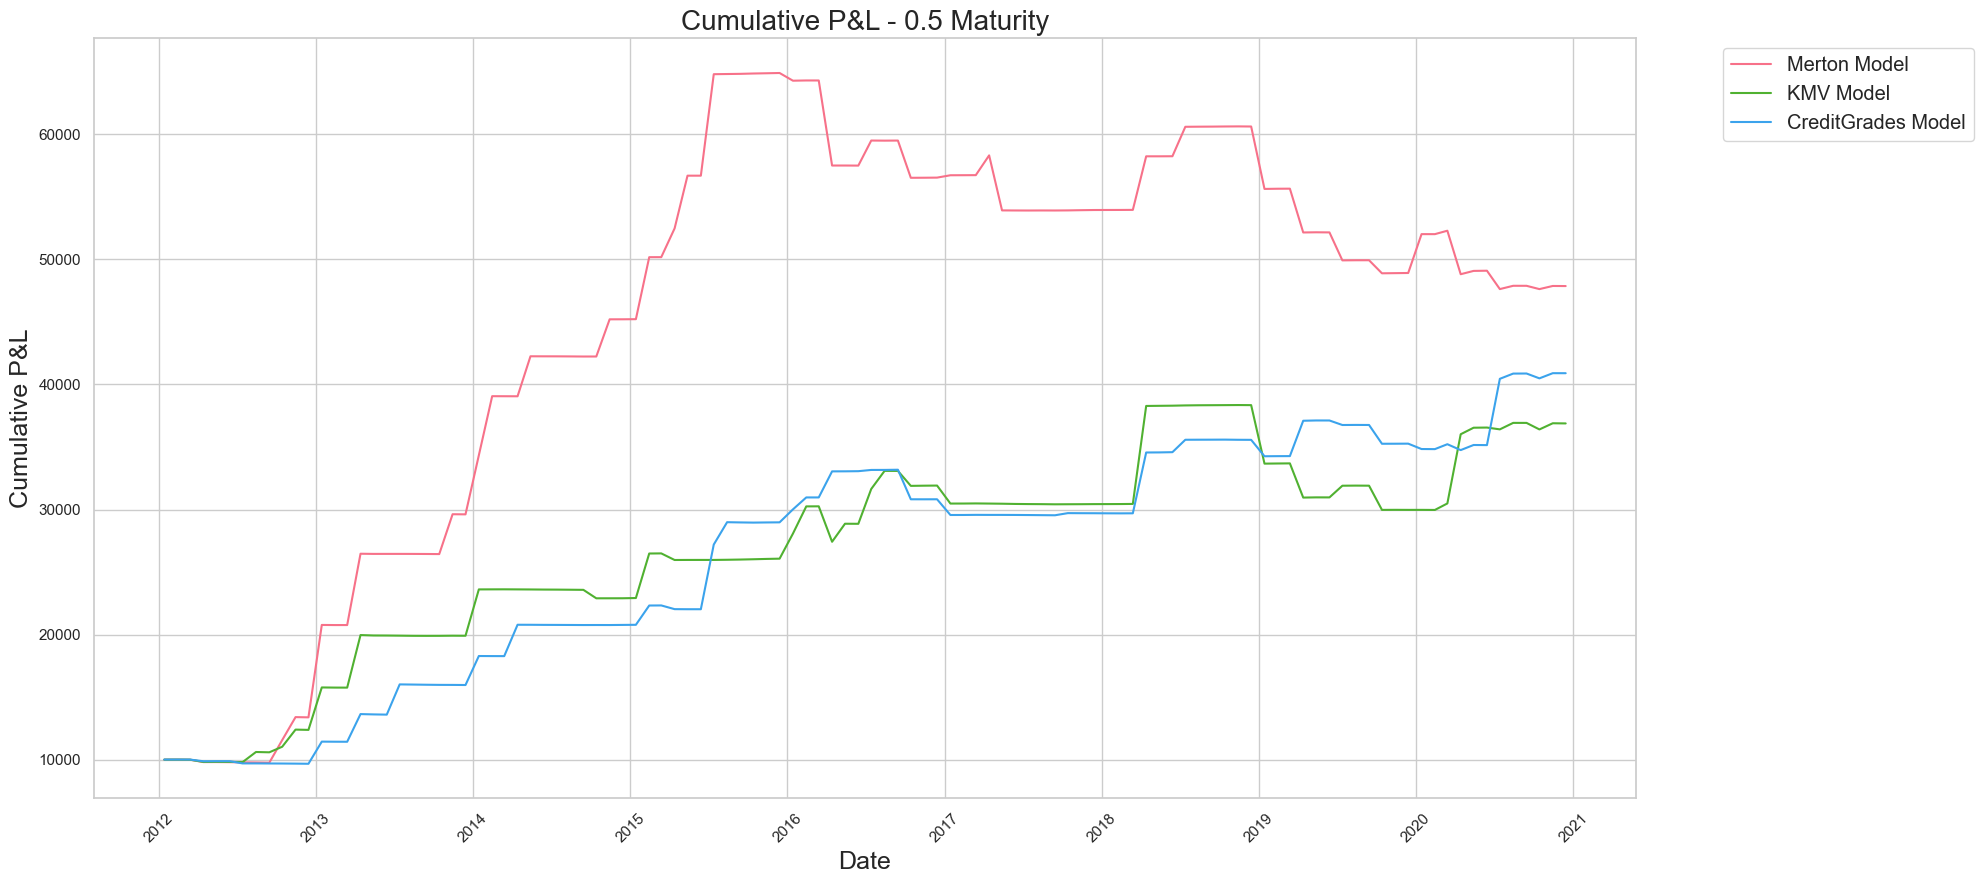

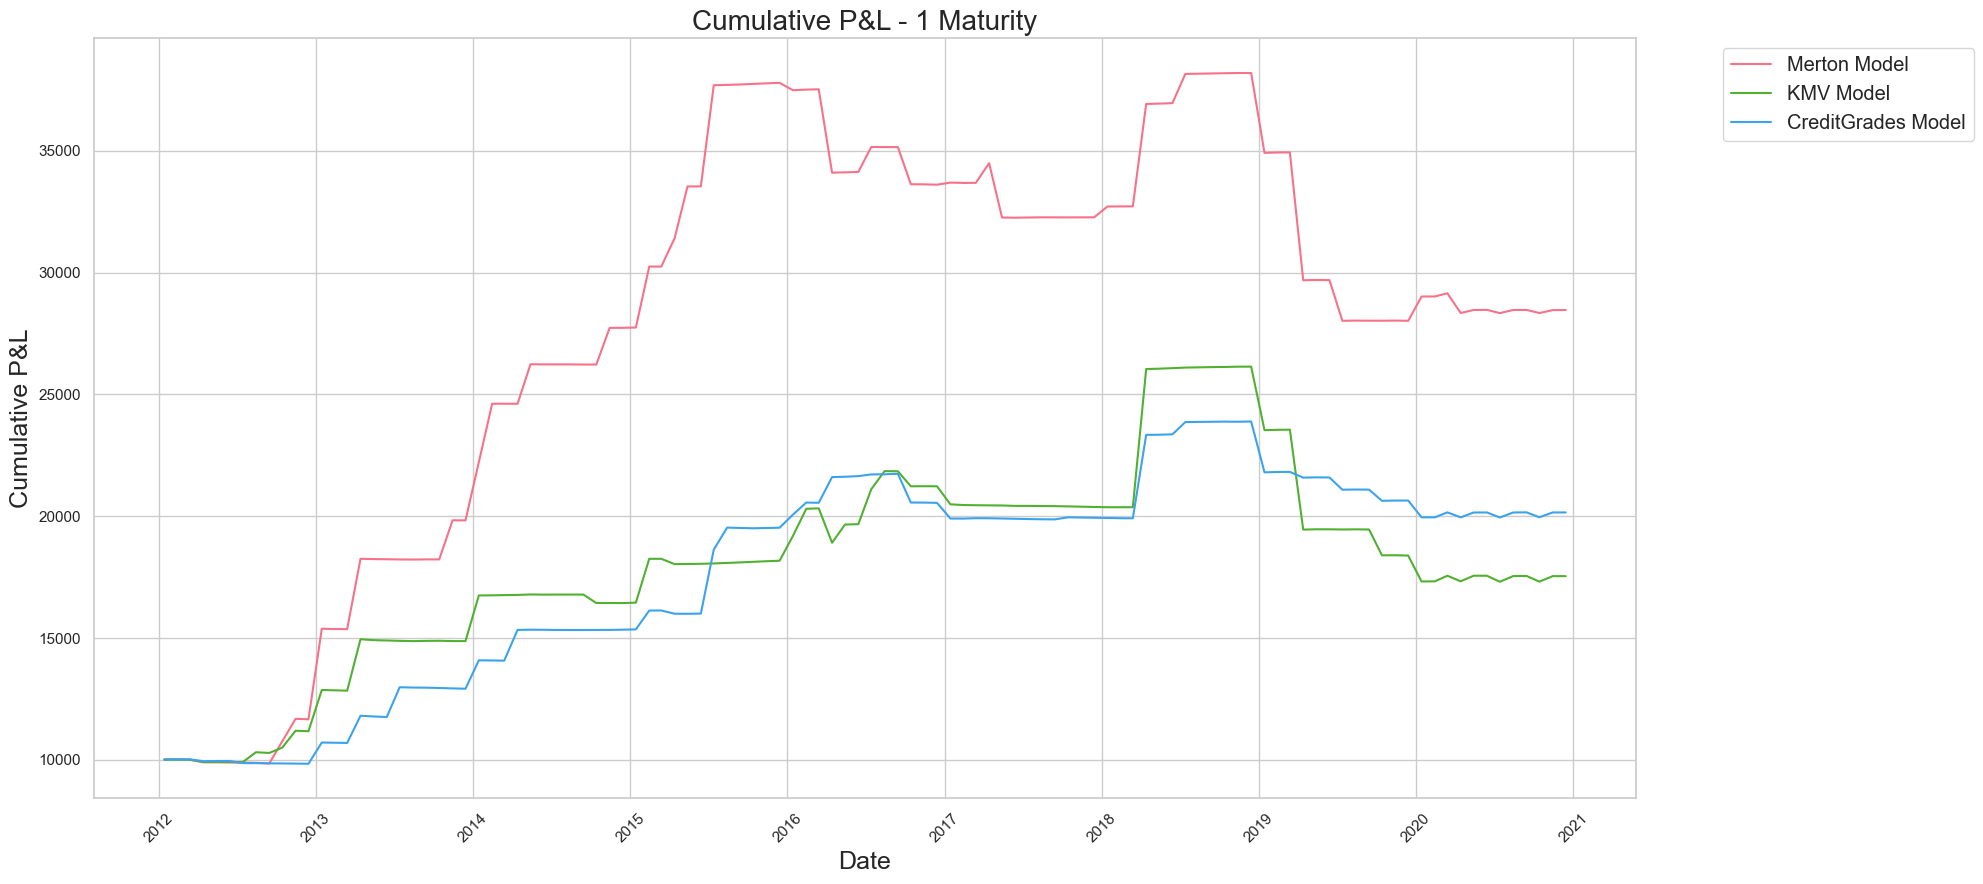

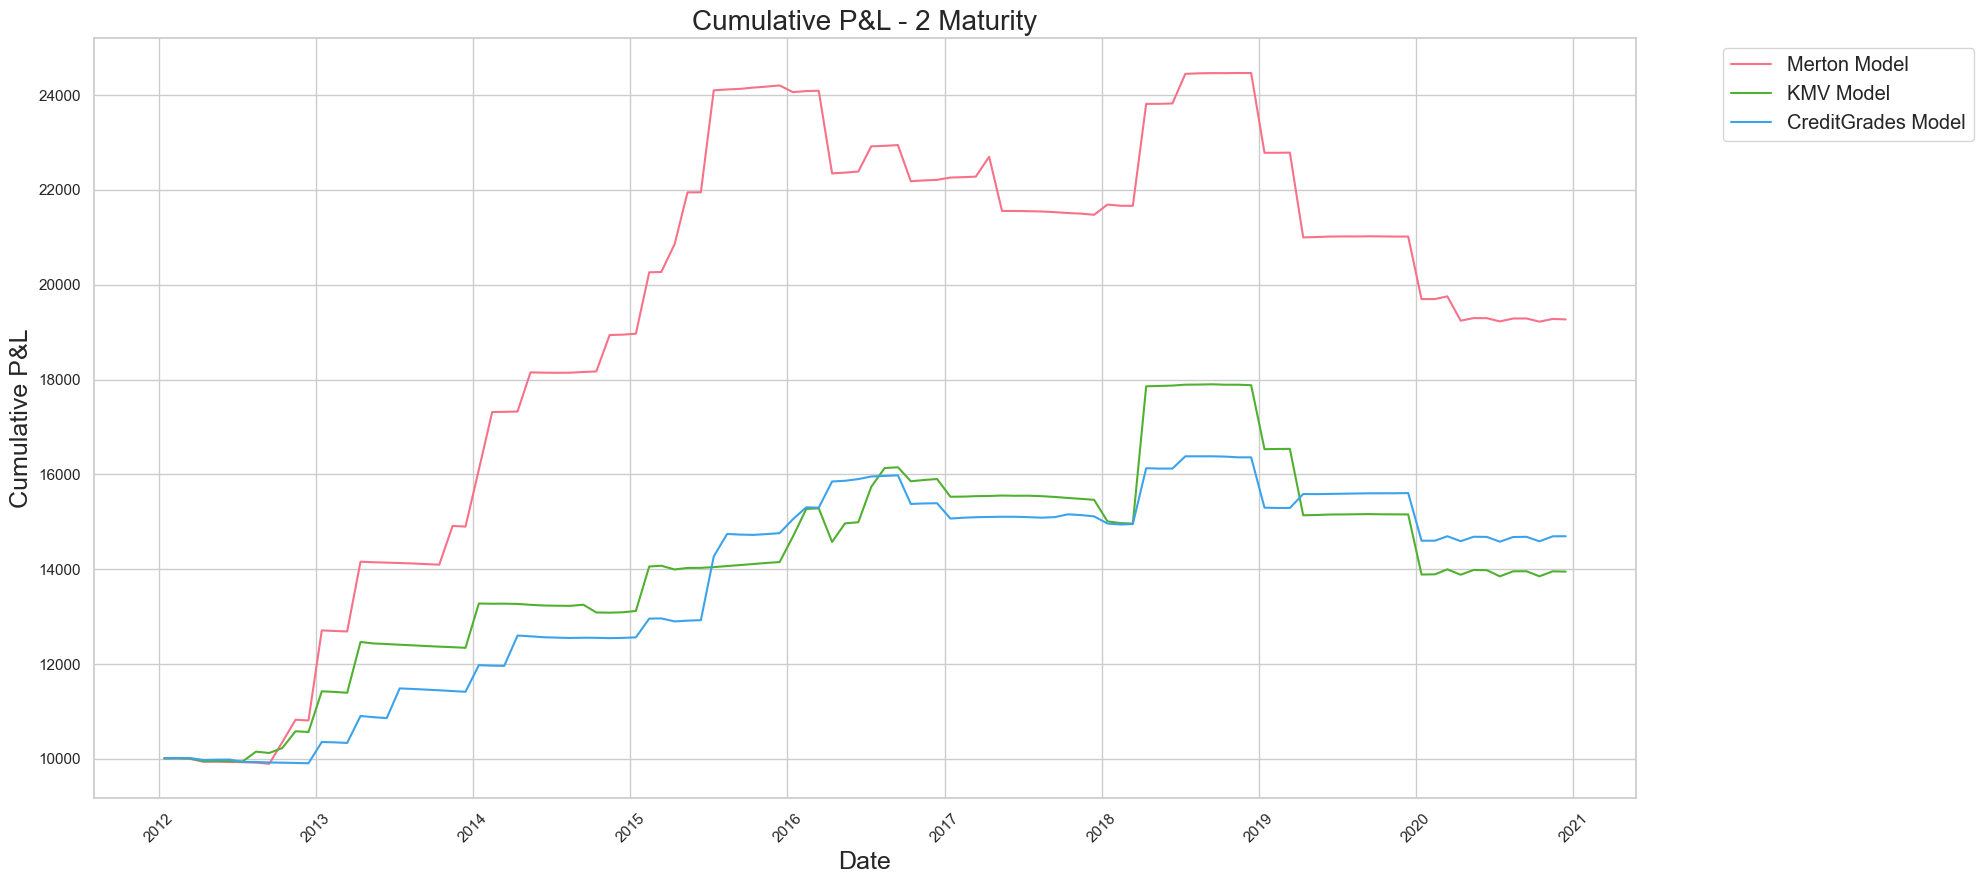

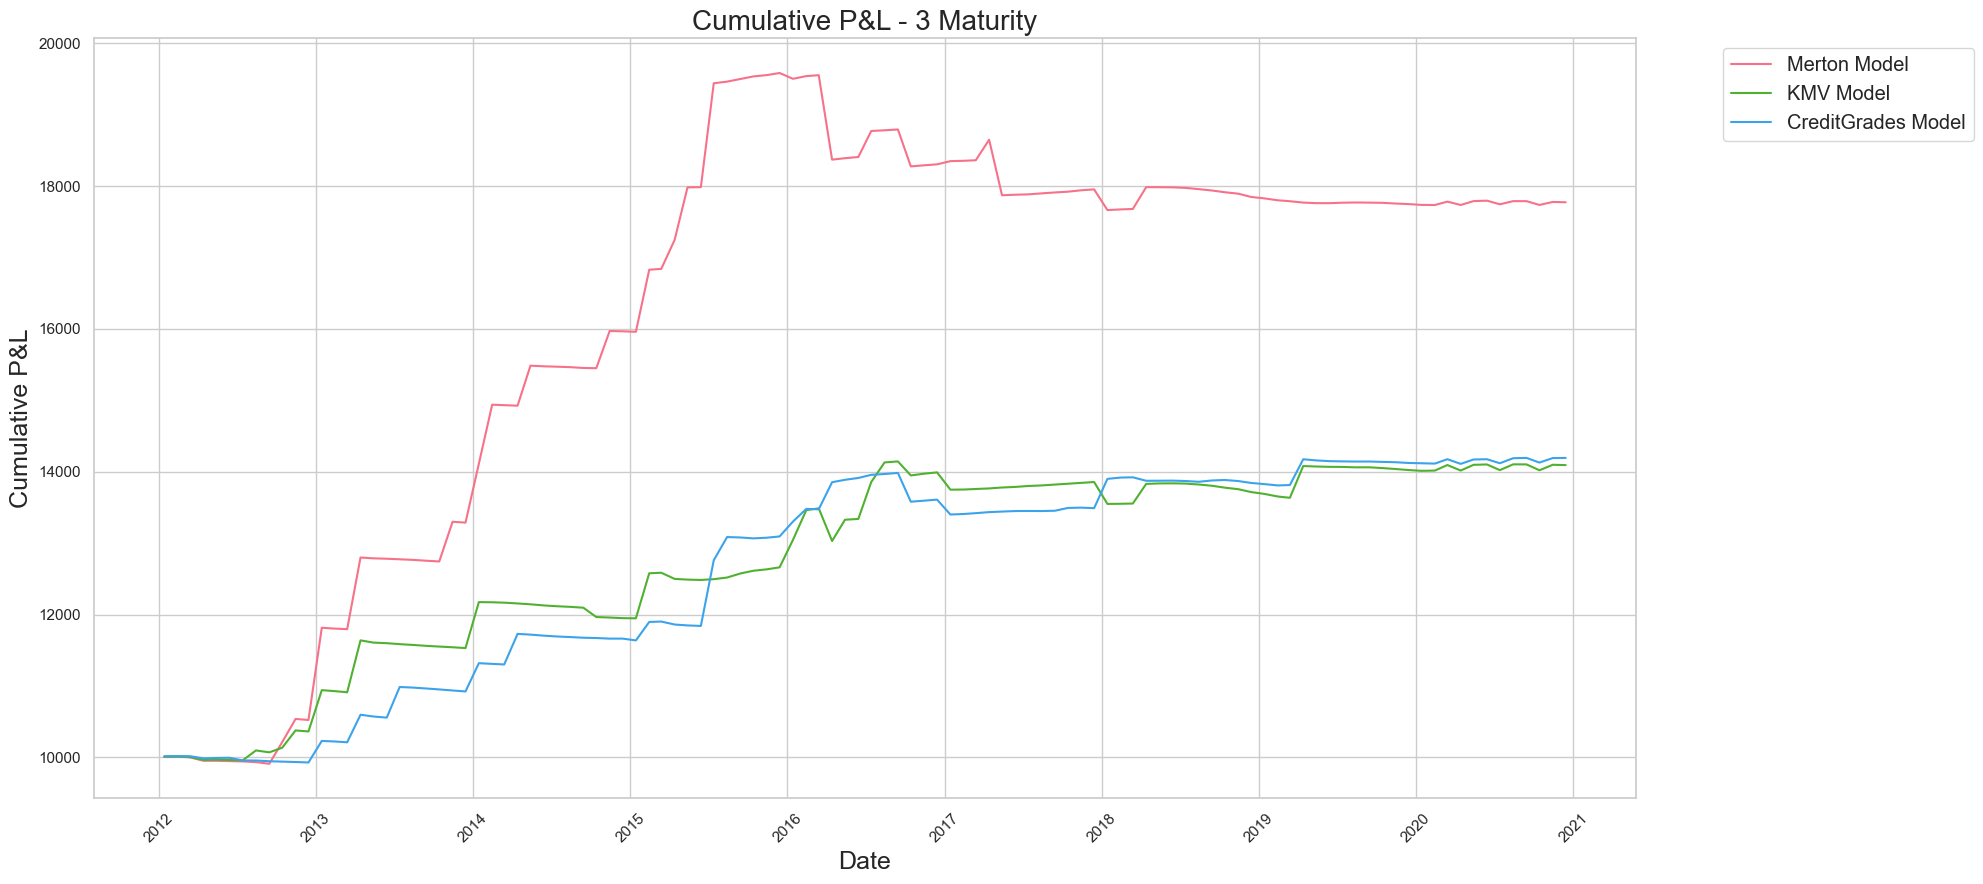

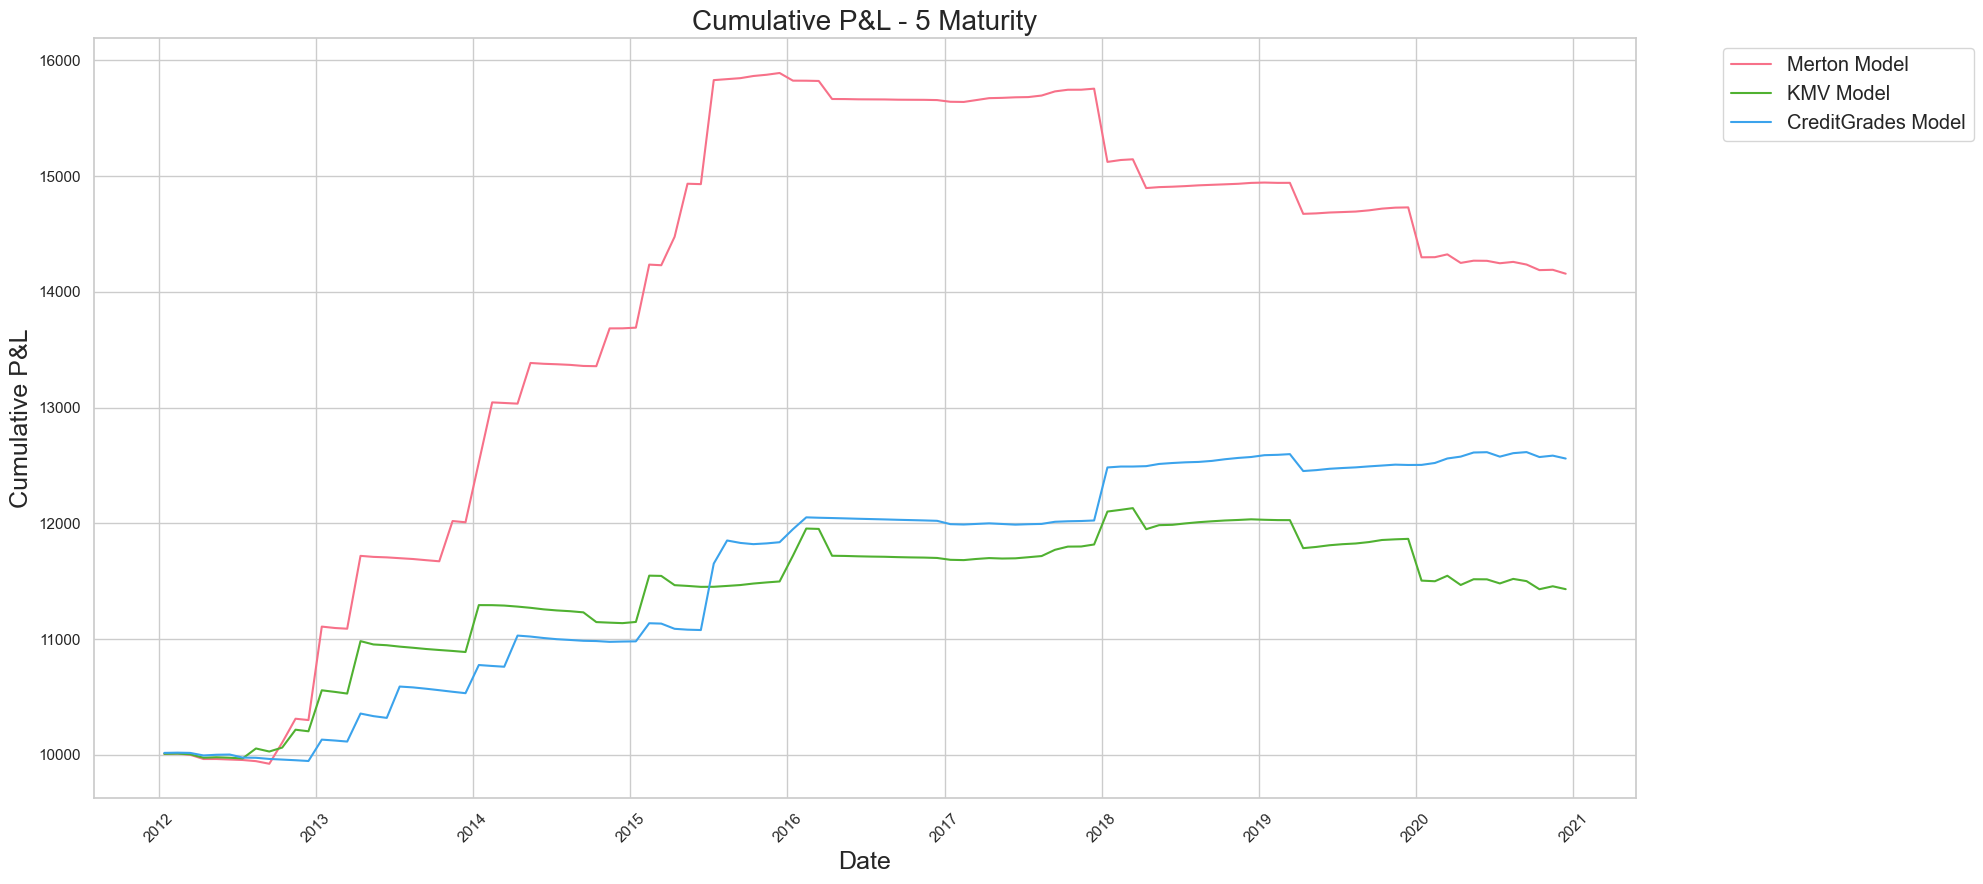

In [404]:
maturities_lst = [0.5,1,2,3,5]
models_lst = ['Merton', 'KMV', 'CreditGrades'] # Replace with your model names
plot_cumulative_pl(total_PL_results, maturities_lst, models_lst)

#### Show the performance of trading strategy of each model

In [ ]:
def evaluate_portfolio(total_PL_results, maturities_lst, initial_asset_level=10000, risk_free_rate=0.03):
    """
    Evaluate portfolio performance.

    :param total_PL_results: Dictionary containing PnL results for different models and maturities.
    :param initial_asset_level: Initial asset level of the portfolio (default: 10000).
    :param risk_free_rate: Annual risk-free rate (default: 0.03).
    :return: A dictionary containing evaluation results for each maturity.
    """
    def max_drawdown(return_series):
        cumulative_returns = (1 + return_series).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min()

    # Adjust the annual risk-free rate for monthly data
    monthly_rf_rate = risk_free_rate / 12

    evaluation_results = {}

    for maturity in maturities_lst:
        model_results = {}
        
        for model in total_PL_results:
            # Adjust the asset level
            asset_levels = initial_asset_level + total_PL_results[model][maturity]['PL']
            
            # Calculate monthly returns
            returns = asset_levels.pct_change().dropna()[1:]

            # Calculate Annual Return
            annual_return = returns.mean() * 12

            # Annualize Volatility
            volatility = returns.std() * np.sqrt(12)

            # Calculate Max Drawdown
            max_drawdown_val = max_drawdown(returns)

            # Adjust Sharpe Ratio for annual data
            sharpe_ratio = ((returns.mean() - monthly_rf_rate) * 12) / (returns.std() * np.sqrt(12))

            model_results[model] = {
                'Annual Return': annual_return,
                'Annual Volatility': volatility,
                'Max Drawdown': max_drawdown_val,
                'Annual Sharpe Ratio': sharpe_ratio
            }
        
        evaluation_results[maturity] = pd.DataFrame(model_results)

    return evaluation_results

In [391]:
evaluate_portfolio(total_PL_results,[0.5,1,2,3,5])

{0.5:                        Merton       KMV  CreditGrades
 Annual Return        0.167520  0.136763      0.141782
 Annual Volatility    0.231715  0.187362      0.156768
 Max Drawdown        -0.266160 -0.218596     -0.109688
 Annual Sharpe Ratio  0.593488  0.569822      0.713039,
 1:                        Merton       KMV  CreditGrades
 Annual Return        0.108944  0.061907      0.070146
 Annual Volatility    0.161986  0.145732      0.106462
 Max Drawdown        -0.266308 -0.337768     -0.164919
 Annual Sharpe Ratio  0.487354  0.218944      0.377089,
 2:                        Merton       KMV  CreditGrades
 Annual Return        0.065929  0.034983      0.037618
 Annual Volatility    0.104841  0.094342      0.064631
 Max Drawdown        -0.214354 -0.226285     -0.109947
 Annual Sharpe Ratio  0.342701  0.052817      0.117870,
 3:                        Merton       KMV  CreditGrades
 Annual Return        0.055545  0.032698      0.033144
 Annual Volatility    0.069946  0.045010      0.